# Calculate subsidence in BKK at wellnests with 8 aquifers but simulates top four.

- BK, PD, NL, NB
- All are confined and overlain by clay layer
- Implicit method according to USGS SUB package Hoffman report pg. 14

- Output:

1. Bar graph of annual subsidence (cm) for well nest BKK013 for 1979-2020
(Figure 10 of main text)
2. Bar graphs of annual subsidence (cm) for each well nest during 1978-2020
(Shown in supplemental information)
3. RMSE map of simulated annual subsidence vs observed from benchmark leveling
stations
4. Line graphs of cumulative subsidence (cm) into the future depending on the
pumping scenario for each well nest during 1978-2060 (Shown in the main text and
supplemental information)
5. Map of cumulative subsidence for 2020-2060 for each well nest for each
pumping scenario
6. Line graphs of annual subsidence (cm) for sensitivity analyses of each parameter
(Sskv, Sske, K, thickness) for one well nest (long run time so only calculating for
one well nest at a time) (Shown in supplemental information)


Author: Jenny Soonthornrangsan 2023, TU Delft

In [1]:
###############################################################################
# Installing packages on colab
###############################################################################
!pip install scikit_learn
!pip install pastas
!pip install scipy
!pip install mycolorpy
!pip install "basemap == 1.3.2" "basemap-data == 1.3.2" 
!pip install "basemap-data-hires == 1.3.2"
!pip install "matplotlib == 3.5.2"
!pip install xlrd
!pip install pickle
!pip install hampel
!git clone https://github.com/jsoontho/BKKSubPastasModels.git
    
# Changing current directory to location of python script
%cd '/content/BKKSubPastasModels'

!git pull

  Using cached basemap-1.3.2.zip (155 kB)
  Installing build dependencies: started
  Installing build dependencies: finished with status 'error'


  error: subprocess-exited-with-error
  
  pip subprocess to install build dependencies did not run successfully.
  exit code: 1
  
  [10 lines of output]
  Ignoring numpy: markers 'python_version == "2.7" or (python_version >= "3.4" and python_version <= "3.9")' don't match your environment
  Ignoring numpy: markers 'python_version == "2.6" or (python_version >= "3.2" and python_version <= "3.3")' don't match your environment
  Ignoring cython: markers 'python_version == "3.2"' don't match your environment
    Using cached setuptools-70.0.0-py3-none-any.whl.metadata (5.9 kB)
    Using cached wheel-0.43.0-py3-none-any.whl.metadata (2.2 kB)
  ERROR: Ignored the following versions that require a different python version: 1.21.2 Requires-Python >=3.7,<3.11; 1.21.3 Requires-Python >=3.7,<3.11; 1.21.4 Requires-Python >=3.7,<3.11; 1.21.5 Requires-Python >=3.7,<3.11; 1.21.6 Requires-Python >=3.7,<3.11
  ERROR: Could not find a version that satisfies the requirement numpy==1.21.4 (from version

  Using cached matplotlib-3.5.2.tar.gz (35.2 MB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Running setup.py clean for matplotlib
Failed to build matplotlib


  error: subprocess-exited-with-error
  
  python setup.py bdist_wheel did not run successfully.
  exit code: 1
  
  [600 lines of output]
  
  Edit mplsetup.cfg to change the build options; suppress output with --quiet.
  
  BUILDING MATPLOTLIB
        python: yes [3.11.5 | packaged by Anaconda, Inc. | (main, Sep 11 2023,
                    13:26:23) [MSC v.1916 64 bit (AMD64)]]
      platform: yes [win32]
         tests: no  [skipping due to configuration]
        macosx: no  [Mac OS-X only]
  
  C:\Users\jtsoonthornran\Anaconda3\Lib\site-packages\setuptools\__init__.py:84: _DeprecatedInstaller: setuptools.installer and fetch_build_eggs are deprecated.
  !!
  
          ********************************************************************************
          Requirements should be satisfied by a PEP 517 installer.
          If you are using pip, you can try `pip install --use-pep517`.
          ********************************************************************************
  
  !!

ERROR: Could not find a version that satisfies the requirement pickle (from versions: none)
ERROR: No matching distribution found for pickle


[WinError 3] The system cannot find the path specified: "'/content/BKKSubPastasModels'"
C:\Users\jtsoonthornran\BKKSubPastasModels\JupyterNotebooks


fatal: destination path 'BKKSubPastasModels' already exists and is not an empty directory.
There is no tracking information for the current branch.
Please specify which branch you want to merge with.
See git-pull(1) for details.

    git pull <remote> <branch>

If you wish to set tracking information for this branch you can do so with:

    git branch --set-upstream-to=origin/<branch> main



__Note that if imports don't work. Check results from cell above and click `Restart Runtime.` Then rerun cells below (including import cell)__

In [2]:
###############################################################################
# import statements
###############################################################################

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import datetime as dt

# Hampel filter
from hampel import hampel

# Changing current directory to location of main directory
%cd "C:\Users\jtsoonthornran\BKKSubPastasModels"

# Bangkok Subsidence Model Package
import bkk_sub_gw

C:\Users\jtsoonthornran\BKKSubPastasModels


## Figure of simulated annual subsidence rate vs observed for BKK013 (Figure 10 in main paper)

C:\Users\jtsoonthornran\BKKSubPastasModels\bkk_sub_gw\bkk_plotting.py:234: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticks(), rotation=45)


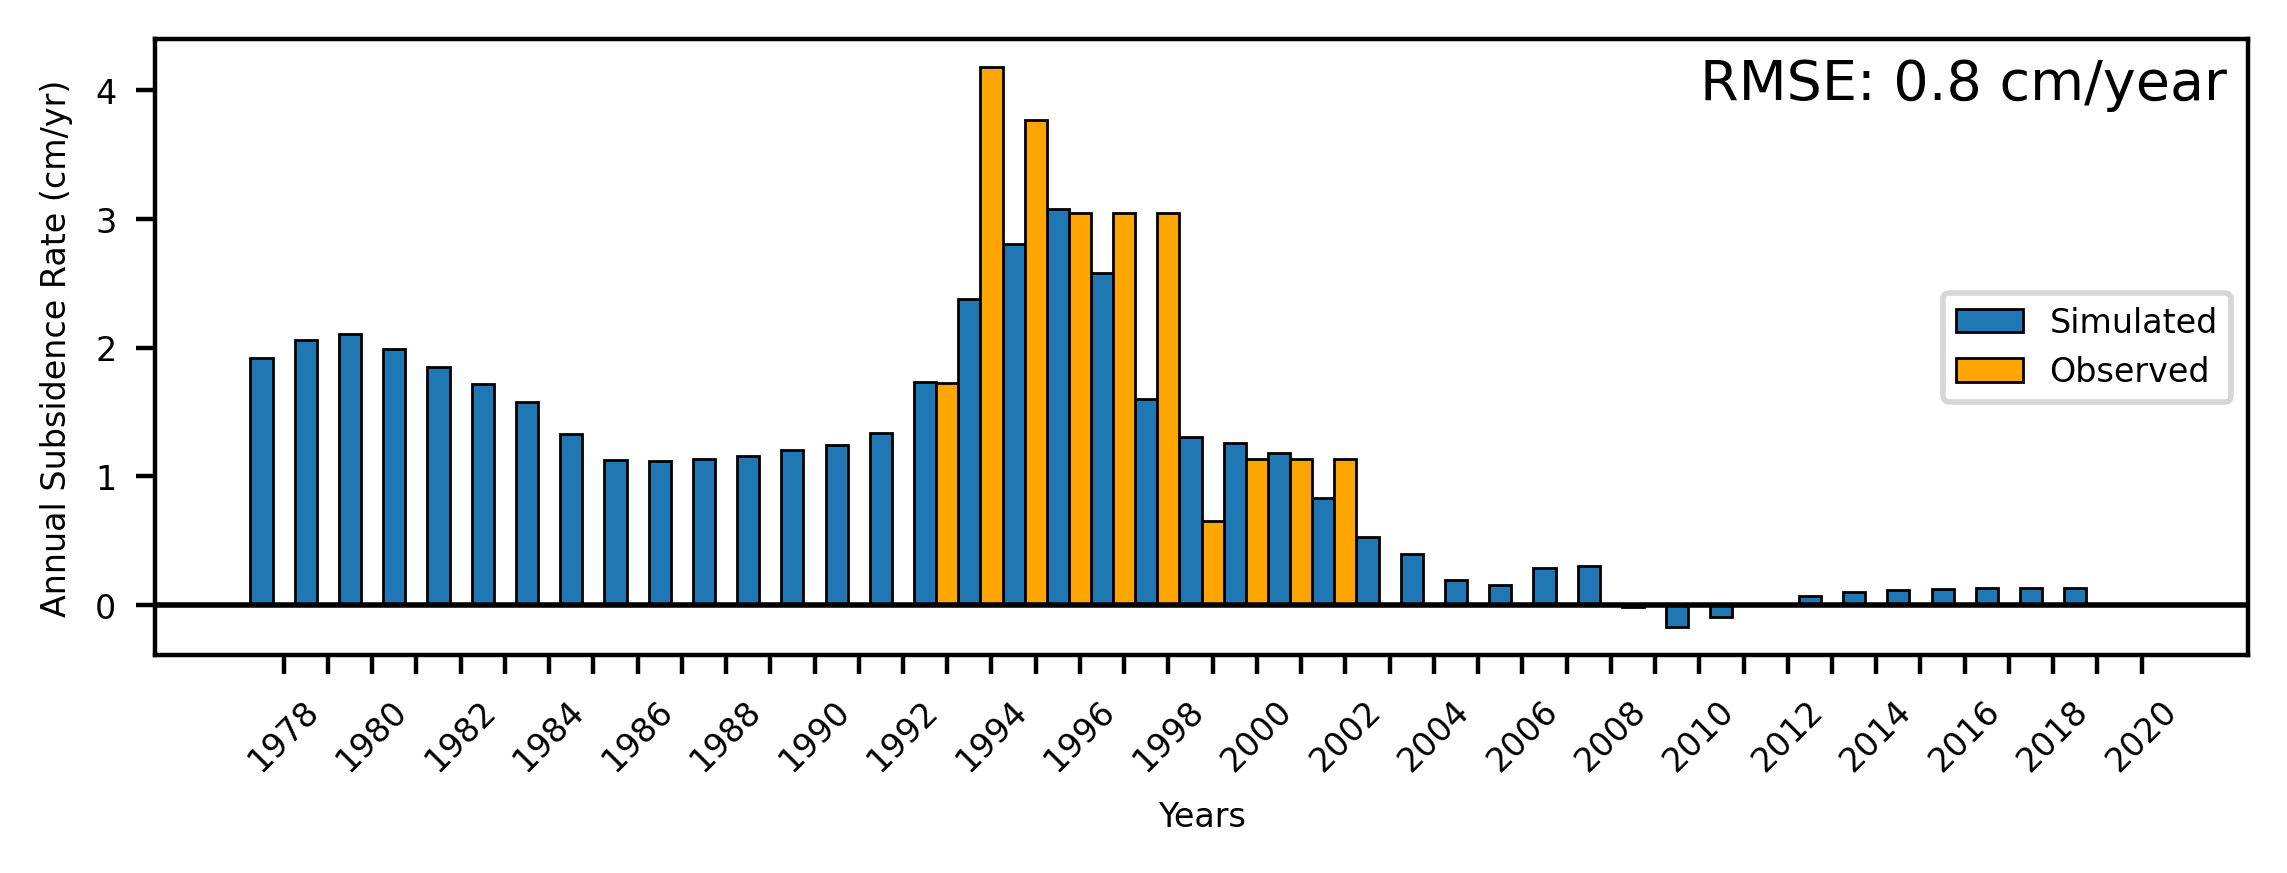

In [3]:
# Creating (0) or importing (1)
importing = 1

# If saving model
saving = 0

# For well nest BKK013 (in paper) = LCBKK013
wellnestlist = ["LCBKK013"]

# If creating results for first time
if importing == 0:

    tmin = "1978"
    tmax = "2020"

    # Reading in thickness and storage data
    path = os.path.join(os.path.abspath("inputs"), "SUBParameters.xlsx")
    Thick_data = pd.read_excel(path, sheet_name="Thickness",
                               index_col=0)  # Thickness
    Sskv_data = pd.read_excel(path,
                              sheet_name="Sskv",
                              index_col=0)  # Sskv
    Sske_data = pd.read_excel(path,
                              sheet_name="Sske",
                              index_col=0)  # Ssk
    K_data = pd.read_excel(path,
                           sheet_name="K",
                           index_col=0)  # K

    # Mode can be "raw" as in raw groundwater data vs "Pastas" for importing Pastas
    # simulated groundwater in the aquifers
    mode = "Pastas"

    # If mode is Pastas, need model path
    if mode == "Pastas":

        mpath = os.path.abspath("models")

    # Pumping flag, for PASTAS, if changing pumping scenario
    pumpflag = 1
    # If changing pumping scenario, need pumping sheet/path
    if pumpflag == 1:

        ppath = os.path.join(os.path.abspath("inputs"), "BasinPumping.xlsx")
        psheet = "EstTotalPump_54-60_Int50"

    # Convergence criteria
    CC = 1 * 10**-5

    # Number of nodes in clay
    node_num = 10

    # Using available heads as proxy for missing
    proxyflag = 1

    # Calculates subsidence
    all_results, sub_total, subv_total = bkk_sub_gw.\
        bkk_sub.bkk_subsidence(wellnestlist,
                               mode, tmin,
                               tmax,
                               Thick_data,
                               K_data,
                               Sskv_data,
                               Sske_data,
                               CC=CC,
                               Nz=node_num,
                               ic_run=True,
                               proxyflag=proxyflag,
                               pumpflag=pumpflag,
                               pump_path=ppath,
                               pump_sheet=psheet,
                               model_path=mpath)

    # Post process data
    sub_total, subv_total, ann_sub, \
        avgsub = bkk_sub_gw.bkk_sub.bkk_postproc(wellnestlist,
                                                 sub_total,
                                                 subv_total,
                                                 all_results)

    # Dictionary to store everything
    model_sub = {"wellnestlist": wellnestlist,
                 "all_results": all_results,
                 "sub_total": sub_total,
                 "subv_total": subv_total,
                 "ann_sub": ann_sub,
                 "avgsub": avgsub,
                 "tmin": tmin,
                 "tmax": tmax,
                 "Thick_data": Thick_data,
                 "Sske_data": Sske_data,
                 "Sskv_data": Sskv_data,
                 "K_data": K_data,
                 "pumping_scenario": psheet,
                 "CC": CC,
                 "clay_nodes": node_num,
                 "proxyflag": proxyflag,
                 "mode": mode}

    # If saving model
    if saving == 1:

        # Path to save models
        path = os.path.abspath("models")

        # Saving dict for this model
        afile = open(path + "\\LCBKK013_sub.pkl", "wb")
        pickle.dump(model_sub, afile)
        afile.close()

# if importing subsidence model results
else:

    # Path to import models
    path = os.path.abspath("models")

    # Reload object from file
    file2 = open(path + "\\" + wellnestlist[0] + "_sub.pkl", "rb")
    model_sub = pickle.load(file2)
    file2.close()

# Plotting
# path to save figures
path = os.path.abspath("figures")

###############################################################################
# Plots Results: Bar graph for main paper for BKK013
##############################################################################

bkk_sub_gw.bkk_plotting.sub_bar(path, model_sub["wellnestlist"],
                                model_sub["all_results"],
                                model_sub["sub_total"],
                                model_sub["subv_total"],
                                model_sub["ann_sub"],
                                tmin=model_sub["tmin"],
                                tmax=model_sub["tmax"], save=0,
                                benchflag=1)

## Bar graphs of annual subsidence (cm) for each well nest during 1978-2020
(Shown in supplemental information)

In [4]:
# %%###########################################################################
# Runs the functions to calculate subsidence at point locations in BKK 
# Graphs in supplemental information 1.5
##############################################################################

# Creating (0) or importing (1)
importing = 1

# If saving model
saving = 0

# If creating results for first time
if importing == 0:

    # For each well nest
    wellnestlist = ["LCBKK003",
                    "LCBKK005",
                    "LCBKK006",
                    "LCBKK007",
                    "LCBKK009",
                    "LCBKK011",
                    "LCBKK012",
                    "LCBKK013",
                    "LCBKK014",
                    "LCBKK015",
                    "LCBKK016",
                    "LCBKK018",
                    "LCBKK020",
                    "LCBKK021",
                    "LCBKK026",
                    "LCBKK027",
                    "LCBKK036",
                    "LCBKK038",
                    "LCBKK041",
                    "LCNBI003",
                    "LCNBI007",
                    "LCSPK007",
                    "LCSPK009"]

    tmin = "1978"
    tmax = "2020"

    # Reading in thickness and storage data
    path = os.path.join(os.path.abspath("inputs"), "SUBParameters.xlsx")
    Thick_data = pd.read_excel(path, sheet_name="Thickness",
                               index_col=0)  # Thickness
    Sskv_data = pd.read_excel(path,
                              sheet_name="Sskv",
                              index_col=0)  # Sskv
    Sske_data = pd.read_excel(path,
                              sheet_name="Sske",
                              index_col=0)  # Ssk
    K_data = pd.read_excel(path,
                           sheet_name="K",
                           index_col=0)  # K

    # Mode can be "raw" as in raw groundwater data vs "Pastas" for importing Pastas
    # simulated groundwater in the aquifers
    mode = "Pastas"

    # If mode is Pastas, need model path
    if mode == "Pastas":

        mpath = os.path.abspath("models")

    # Pumping flag, for PASTAS, if changing pumping scenario
    pumpflag = 1
    # If changing pumping scenario, need pumping sheet/path
    if pumpflag == 1:

        ppath = os.path.join(os.path.abspath("inputs"), "BasinPumping.xlsx")
        psheet = "EstTotalPump_54-60_Int50"

    # Convergence criteria
    CC = 1 * 10**-5

    # Number of nodes in clay
    node_num = 10

    # Using available heads as proxy for missing
    proxyflag = 1

    # Calculates subsidence
    all_results, sub_total, subv_total = bkk_sub_gw.\
        bkk_sub.bkk_subsidence(wellnestlist,
                               mode, tmin,
                               tmax,
                               Thick_data,
                               K_data,
                               Sskv_data,
                               Sske_data,
                               CC=CC,
                               Nz=node_num,
                               ic_run=True,
                               proxyflag=proxyflag,
                               pumpflag=pumpflag,
                               pump_path=ppath,
                               pump_sheet=psheet,
                               model_path=mpath)

    # Post process data
    sub_total, subv_total, ann_sub, \
        avgsub = bkk_sub_gw.bkk_sub.bkk_postproc(wellnestlist,
                                                 sub_total,
                                                 subv_total,
                                                 all_results)

    # Dictionary to store everything
    model_sub = {"wellnestlist": wellnestlist,
                 "all_results": all_results,
                 "sub_total": sub_total,
                 "subv_total": subv_total,
                 "ann_sub": ann_sub,
                 "avgsub": avgsub,
                 "tmin": tmin,
                 "tmax": tmax,
                 "Thick_data": Thick_data,
                 "Sske_data": Sske_data,
                 "Sskv_data": Sskv_data,
                 "K_data": K_data,
                 "pumping_scenario": psheet,
                 "CC": CC,
                 "clay_nodes": node_num,
                 "proxyflag": proxyflag,
                 "mode": mode}

    # If saving
    if saving == 1:

        # Path to save models
        path = os.path.abspath("models")

        # Saving dict for this model
        afile = open(path + "\\Allnests_sub.pkl", "wb")
        pickle.dump(model_sub, afile)
        afile.close()

# if importing subsidence model results
else:

    # Path to import models
    path = os.path.abspath("models")

    # Reload object from file
    file2 = open(path + "\\Allnests_sub.pkl", "rb")
    model_sub = pickle.load(file2)
    file2.close()

# Average perc of each clay layer to total for all well nest
BKClayavg = np.average([i[2] for i in model_sub["avgsub"][0::4]])*100
PDClayavg = np.average([i[2] for i in model_sub["avgsub"][1::4]])*100
NLClayavg = np.average([i[2] for i in model_sub["avgsub"][2::4]])*100
NBClayavg = np.average([i[2] for i in model_sub["avgsub"][3::4]])*100

list_ = ["LCBKK003", "LCBKK006", "LCBKK011", "LCBKK036", "LCBKK038"]
# Average perc of each clay layer to total for well nests with BK
BKClayavg_list1 = np.average([i[2] for i in model_sub["avgsub"][0::4]
                              if i[0] in list_])*100
PDClayavg_list1 = np.average([i[2] for i in model_sub["avgsub"][1::4]
                              if i[0] in list_])*100
NLClayavg_list1 = np.average([i[2] for i in model_sub["avgsub"][2::4]
                              if i[0] in list_])*100
NBClayavg_list1 = np.average([i[2] for i in model_sub["avgsub"][3::4]
                              if i[0] in list_])*100

# Average perc of each clay layer to total for well nests without BK
BKClayavg_list0 = np.average([i[2] for i in model_sub["avgsub"][0::4]
                              if i[0] not in list_])*100
PDClayavg_list0 = np.average([i[2] for i in model_sub["avgsub"][1::4]
                              if i[0] not in list_])*100
NLClayavg_list0 = np.average([i[2] for i in model_sub["avgsub"][2::4]
                              if i[0] not in list_])*100
NBClayavg_list0 = np.average([i[2] for i in model_sub["avgsub"][3::4]
                              if i[0] not in list_])*100

# Plotting
# path to save figures
path = os.path.abspath("figures")

### Plots Results: Bar graph of annual rates of simulated and observed subsidence

C:\Users\jtsoonthornran\BKKSubPastasModels\bkk_sub_gw\bkk_plotting.py:234: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticks(), rotation=45)
C:\Users\jtsoonthornran\BKKSubPastasModels\bkk_sub_gw\bkk_plotting.py:234: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticks(), rotation=45)
C:\Users\jtsoonthornran\BKKSubPastasModels\bkk_sub_gw\bkk_plotting.py:234: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticks(), rotation=45)
C:\Users\jtsoonthornran\BKKSubPastasModels\bkk_sub_gw\bkk_plotting.py:234: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticks(

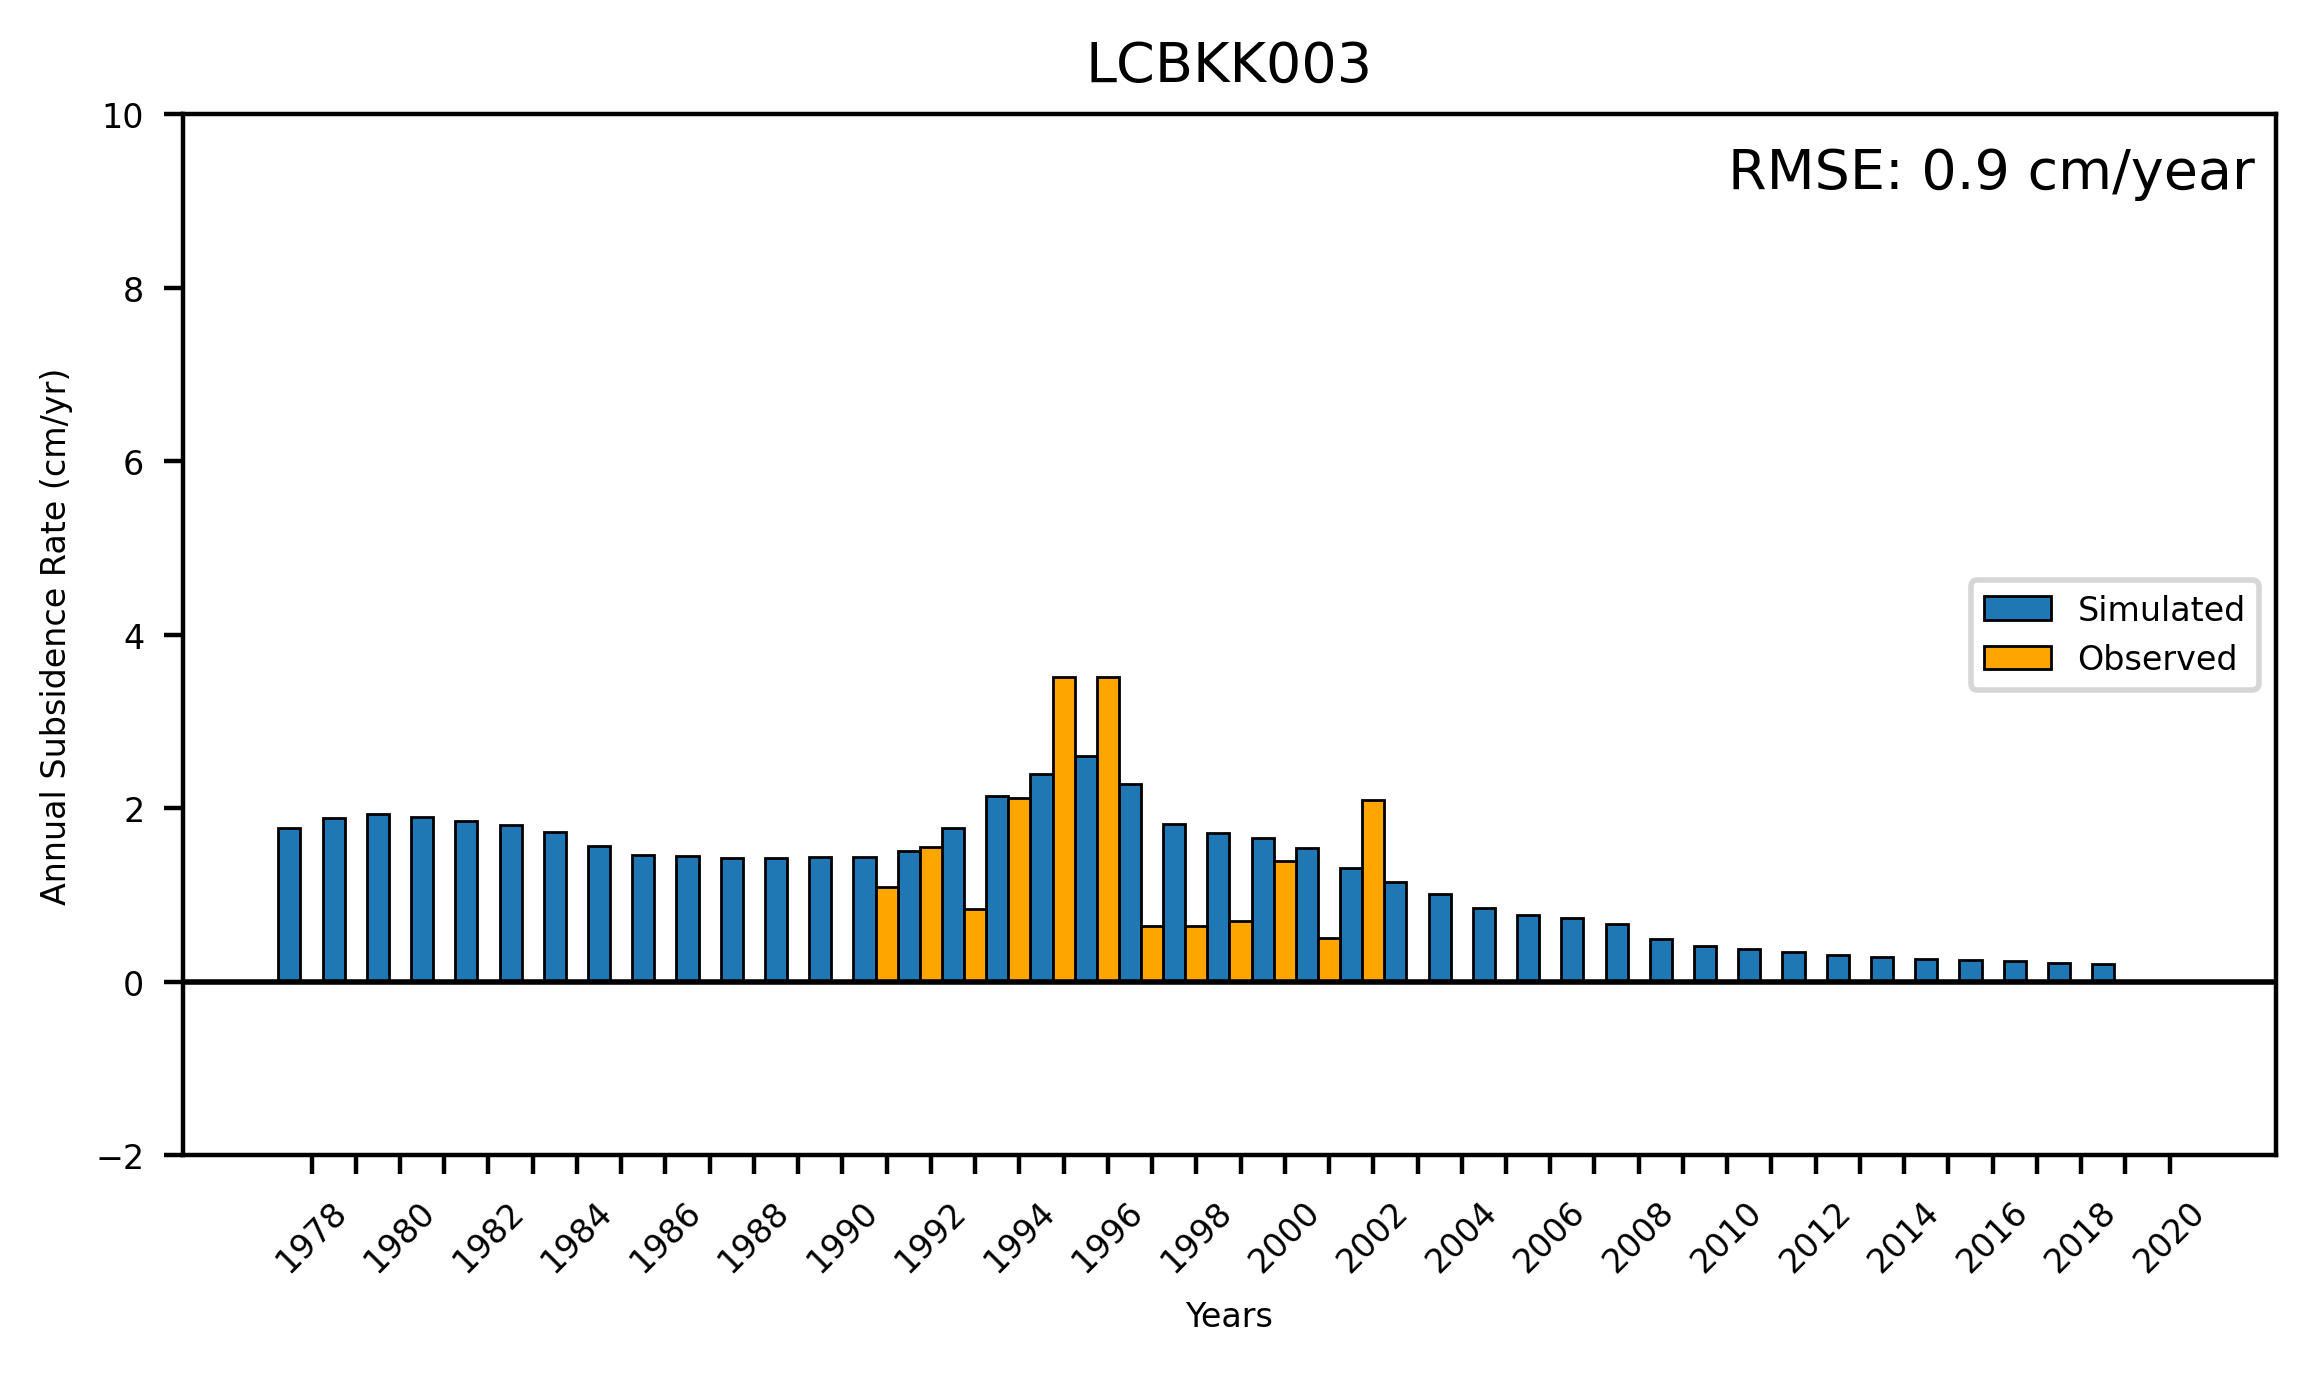

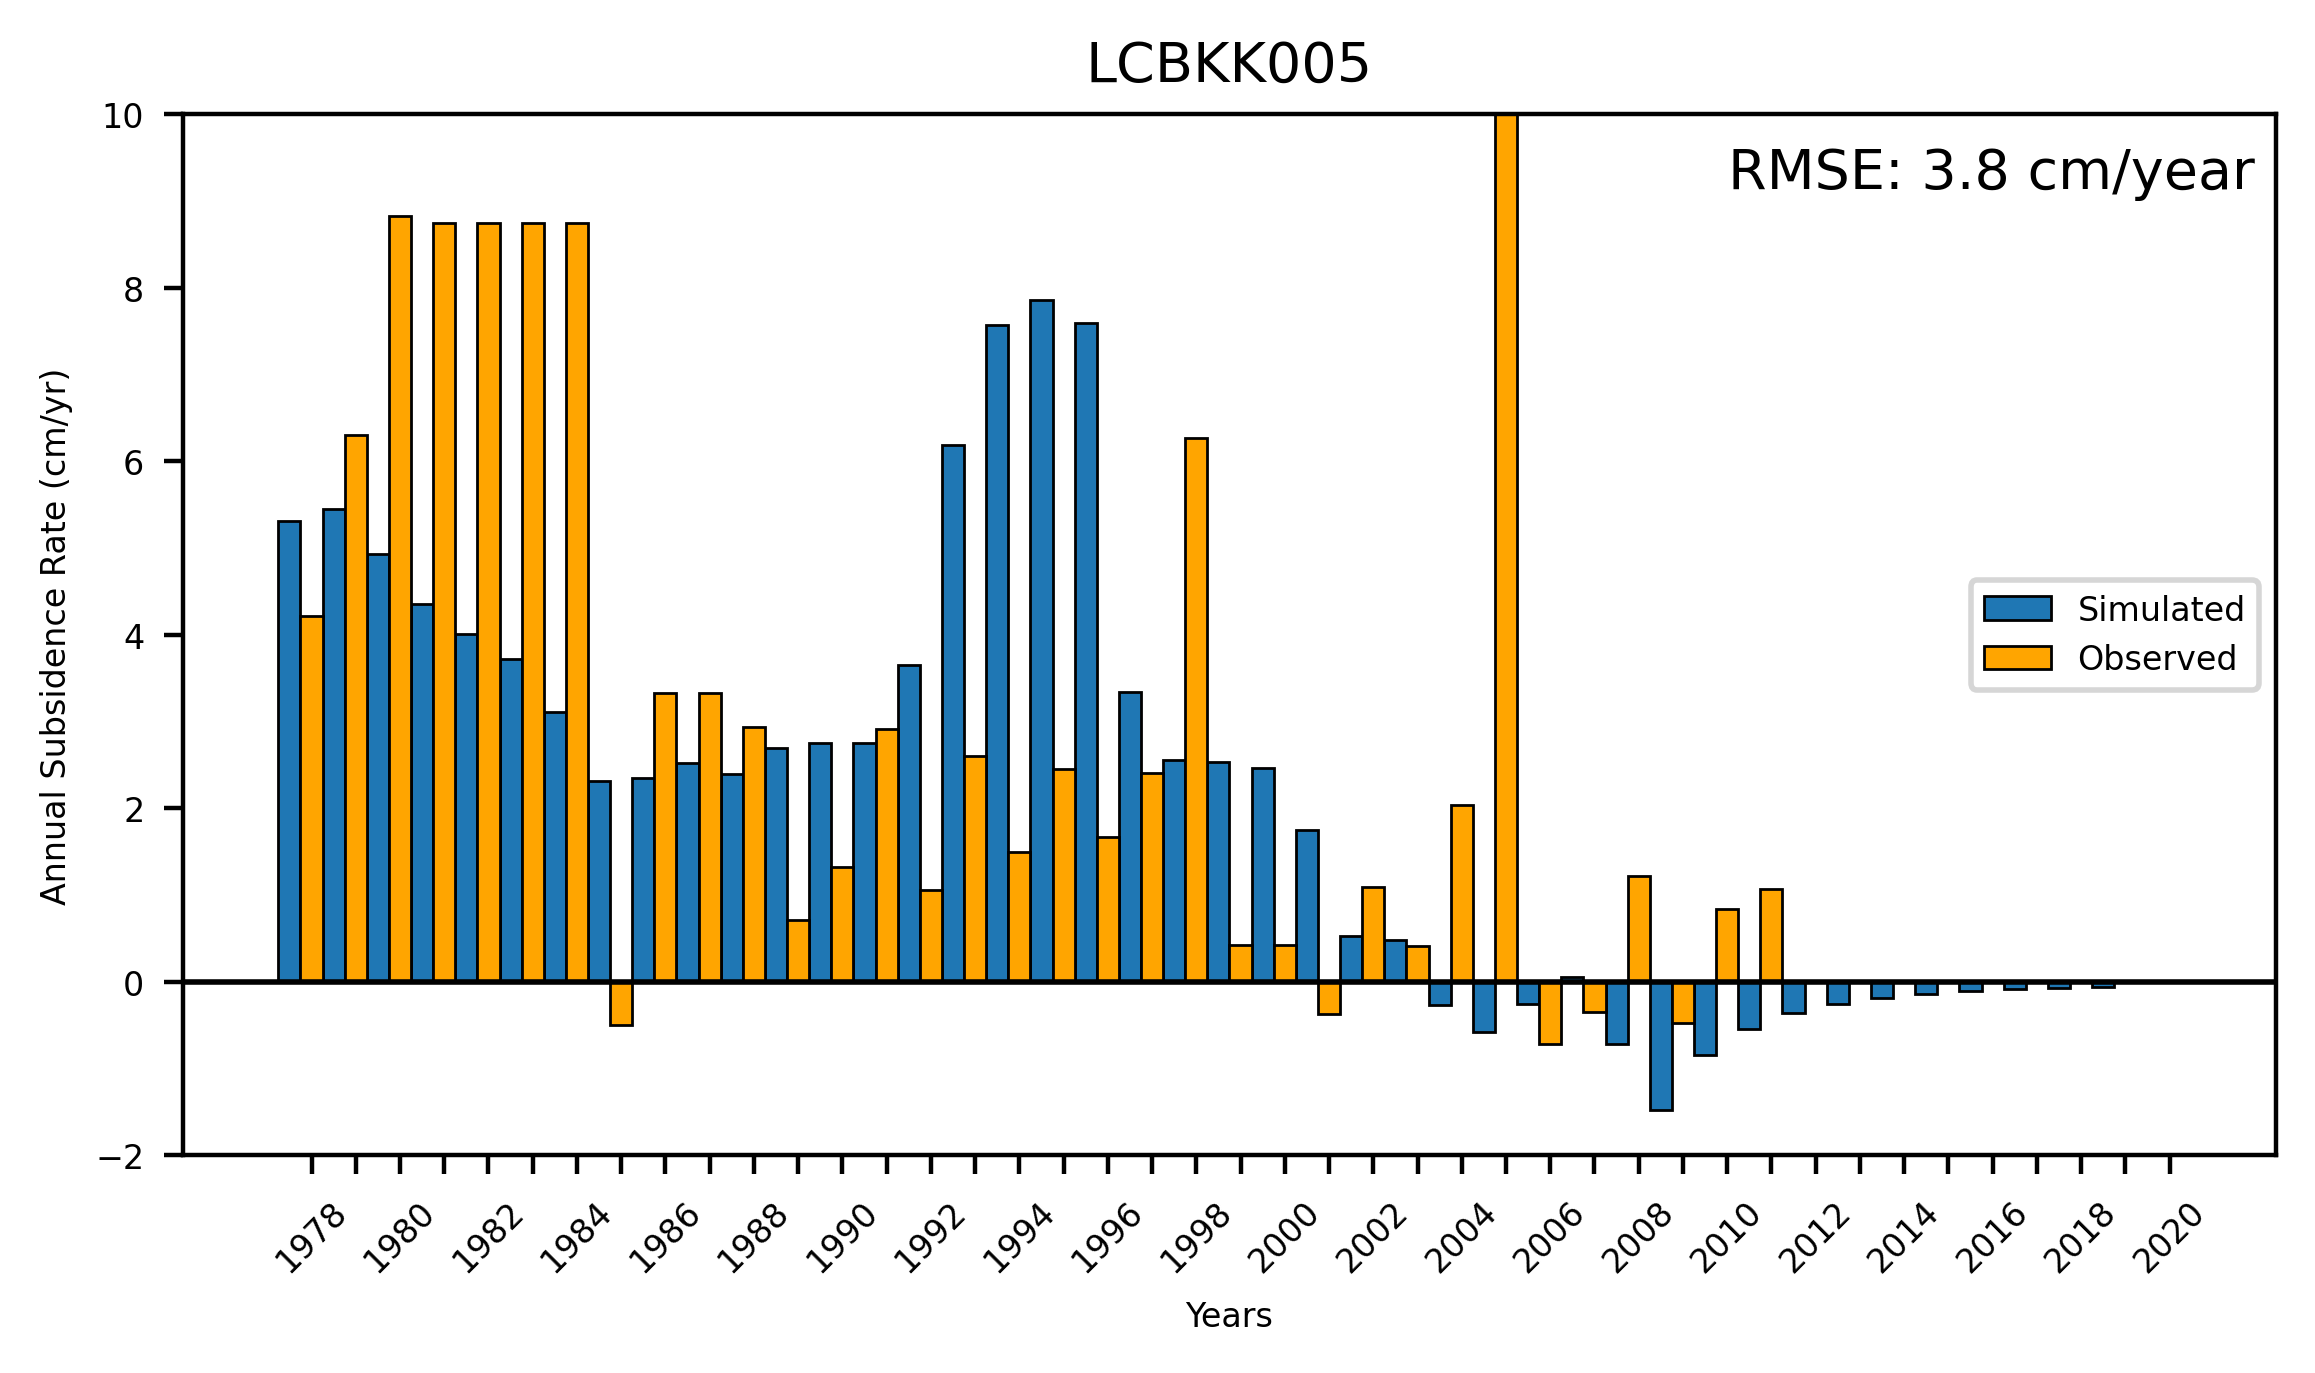

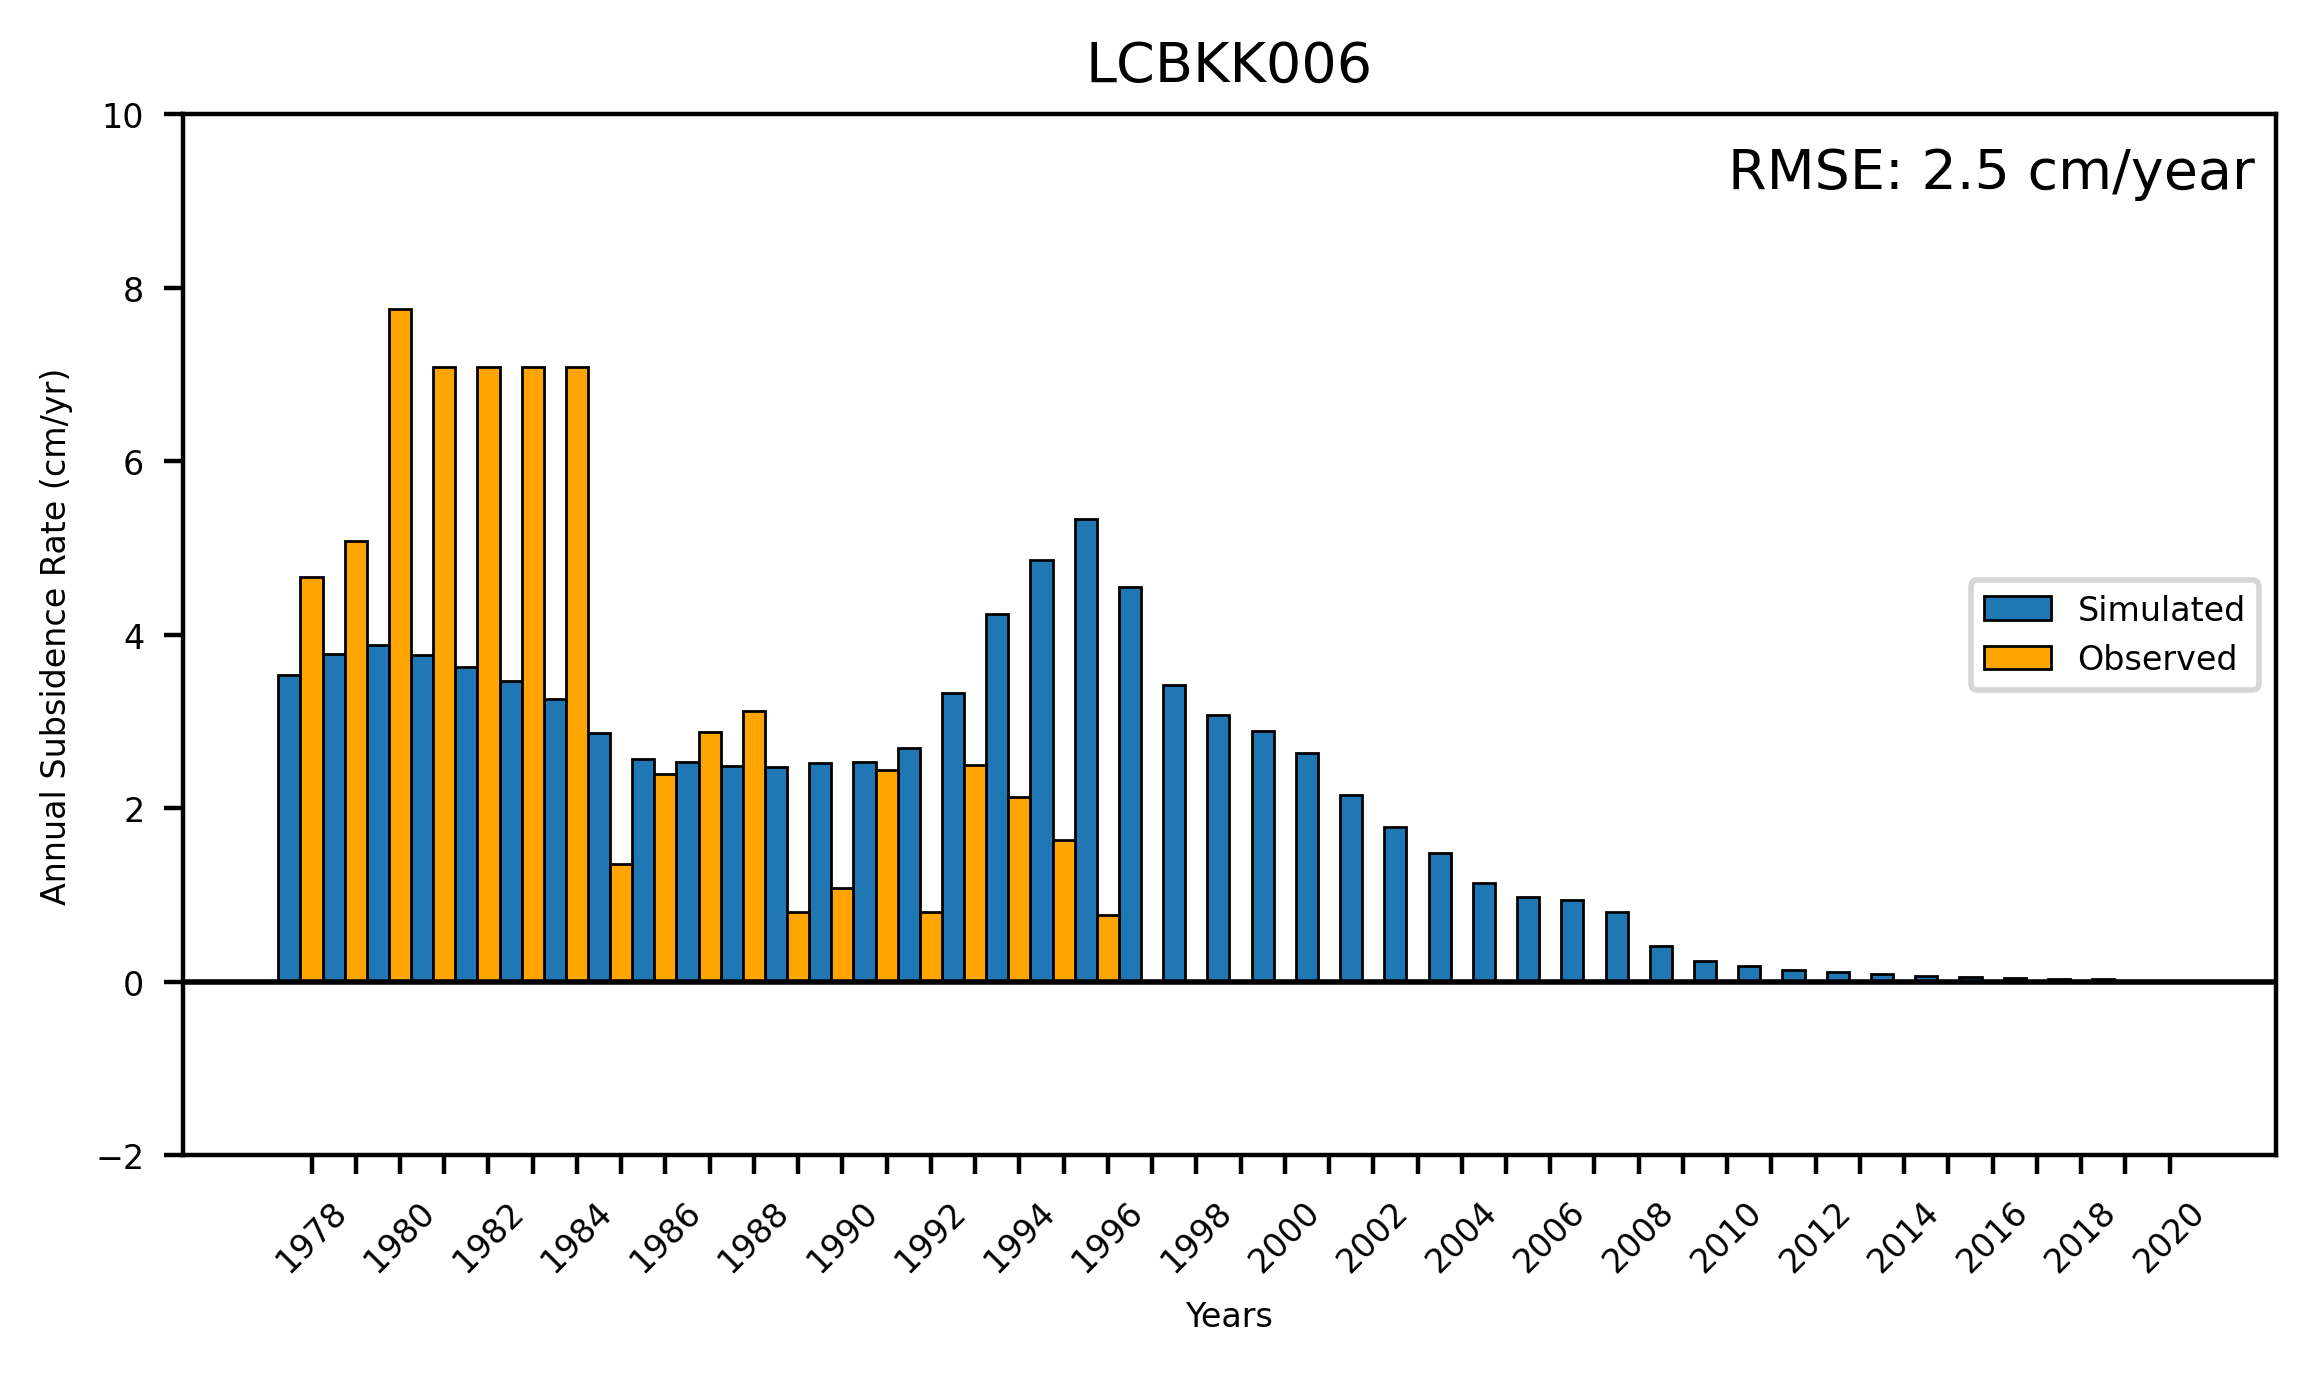

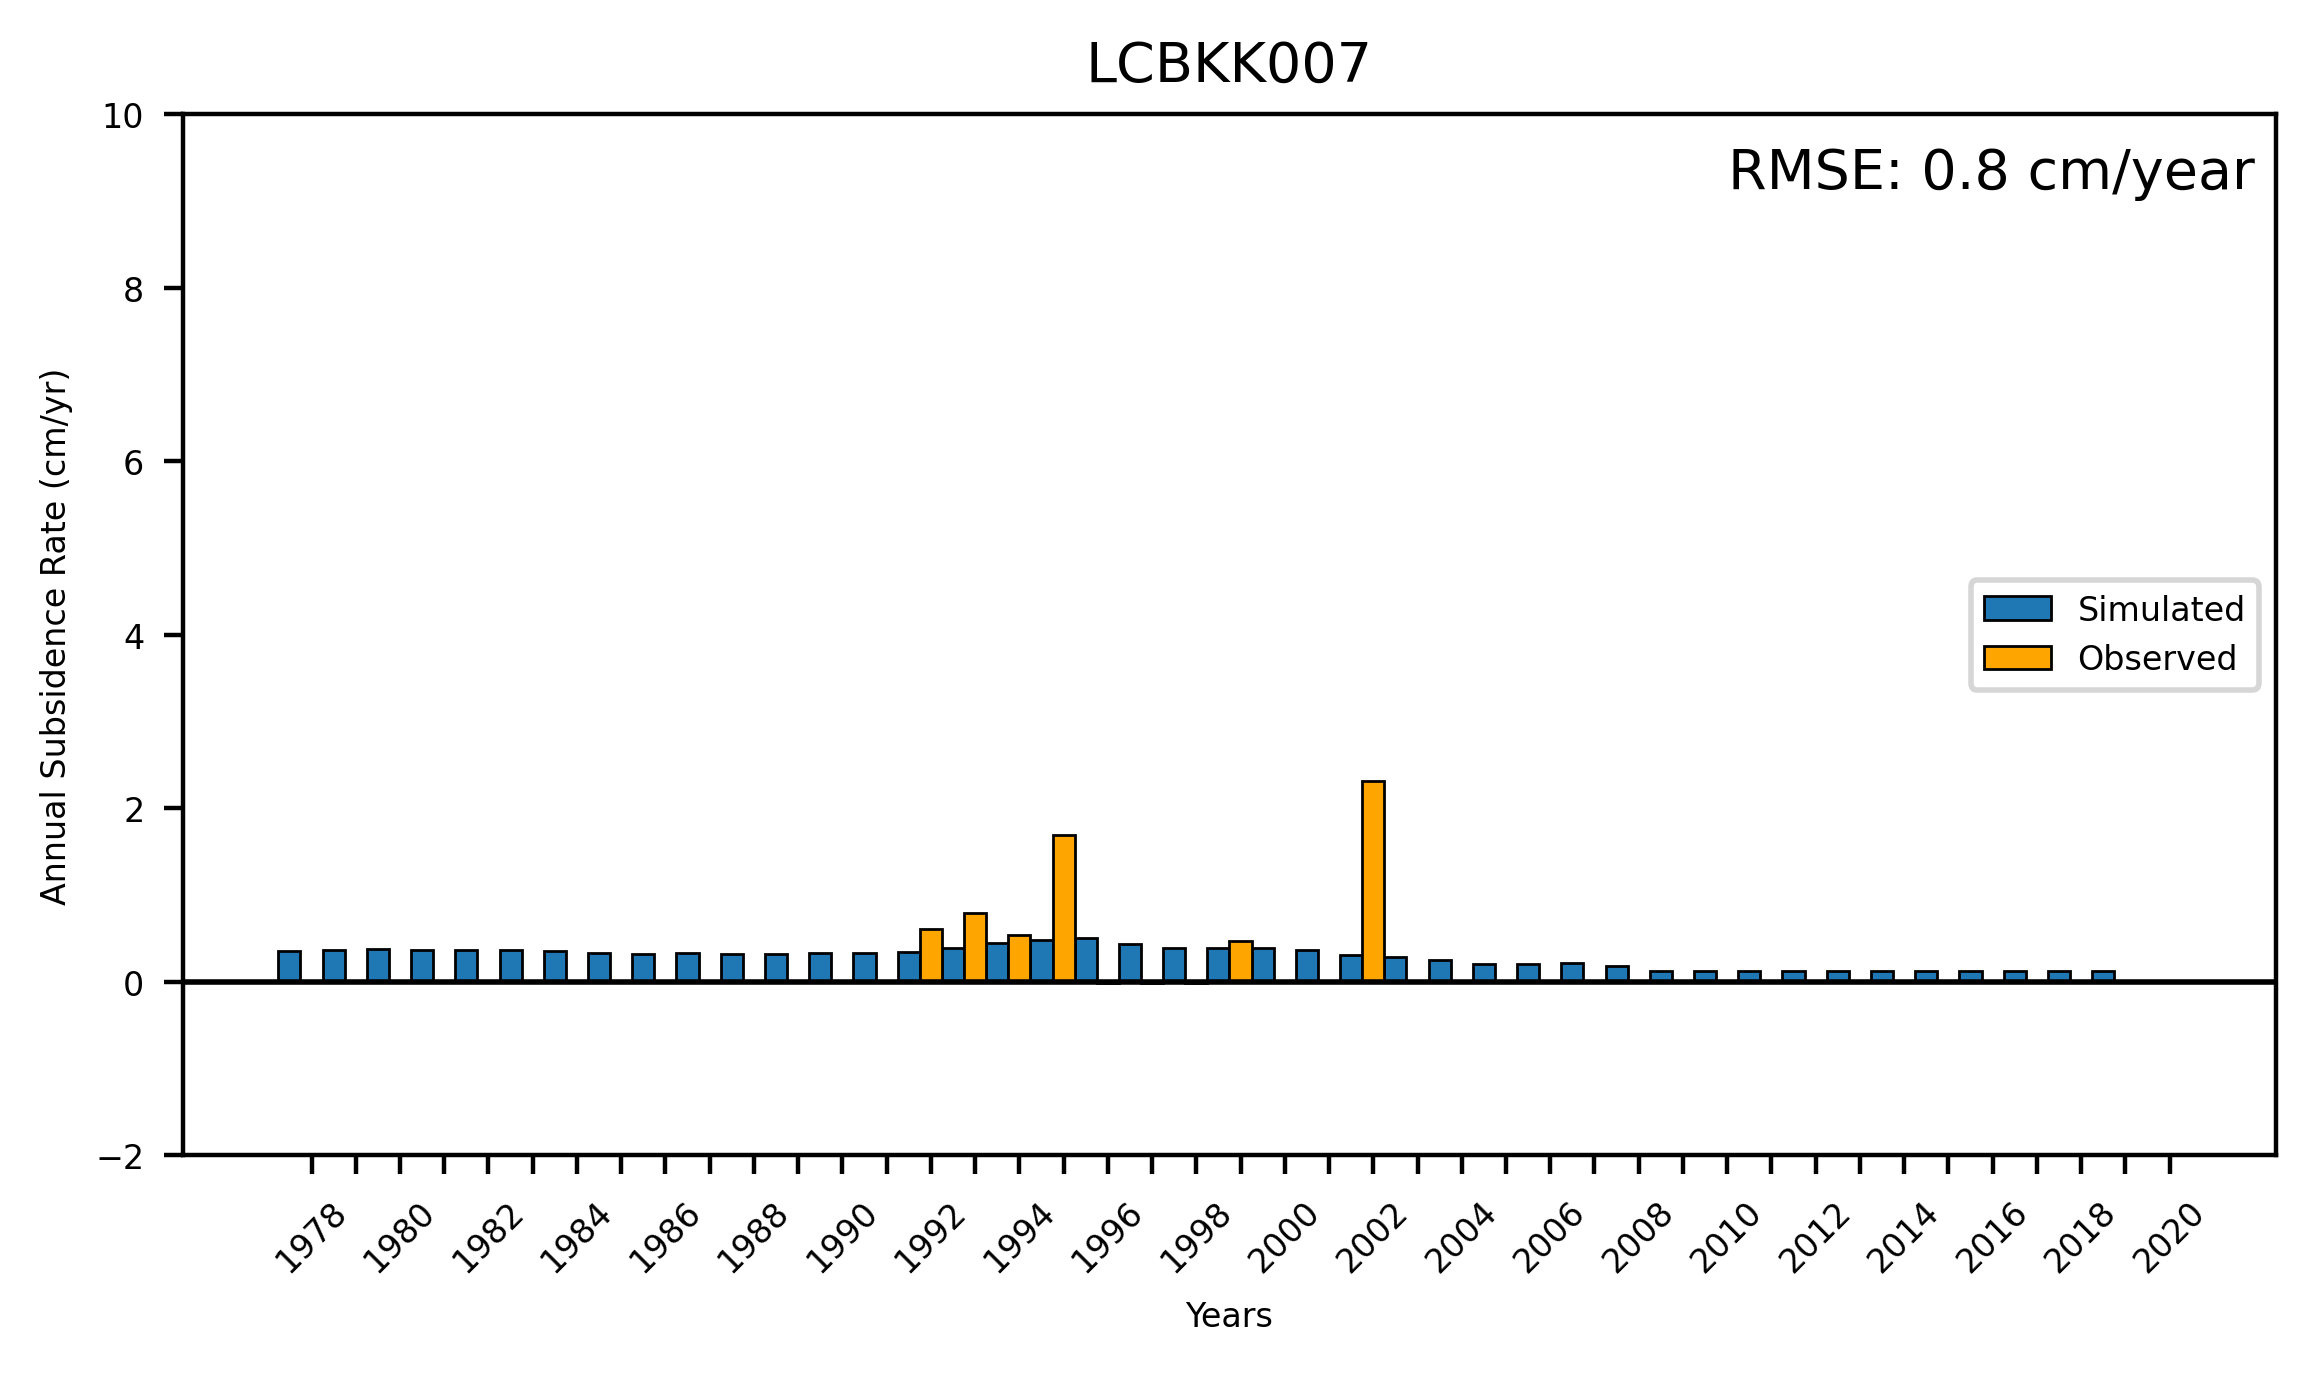

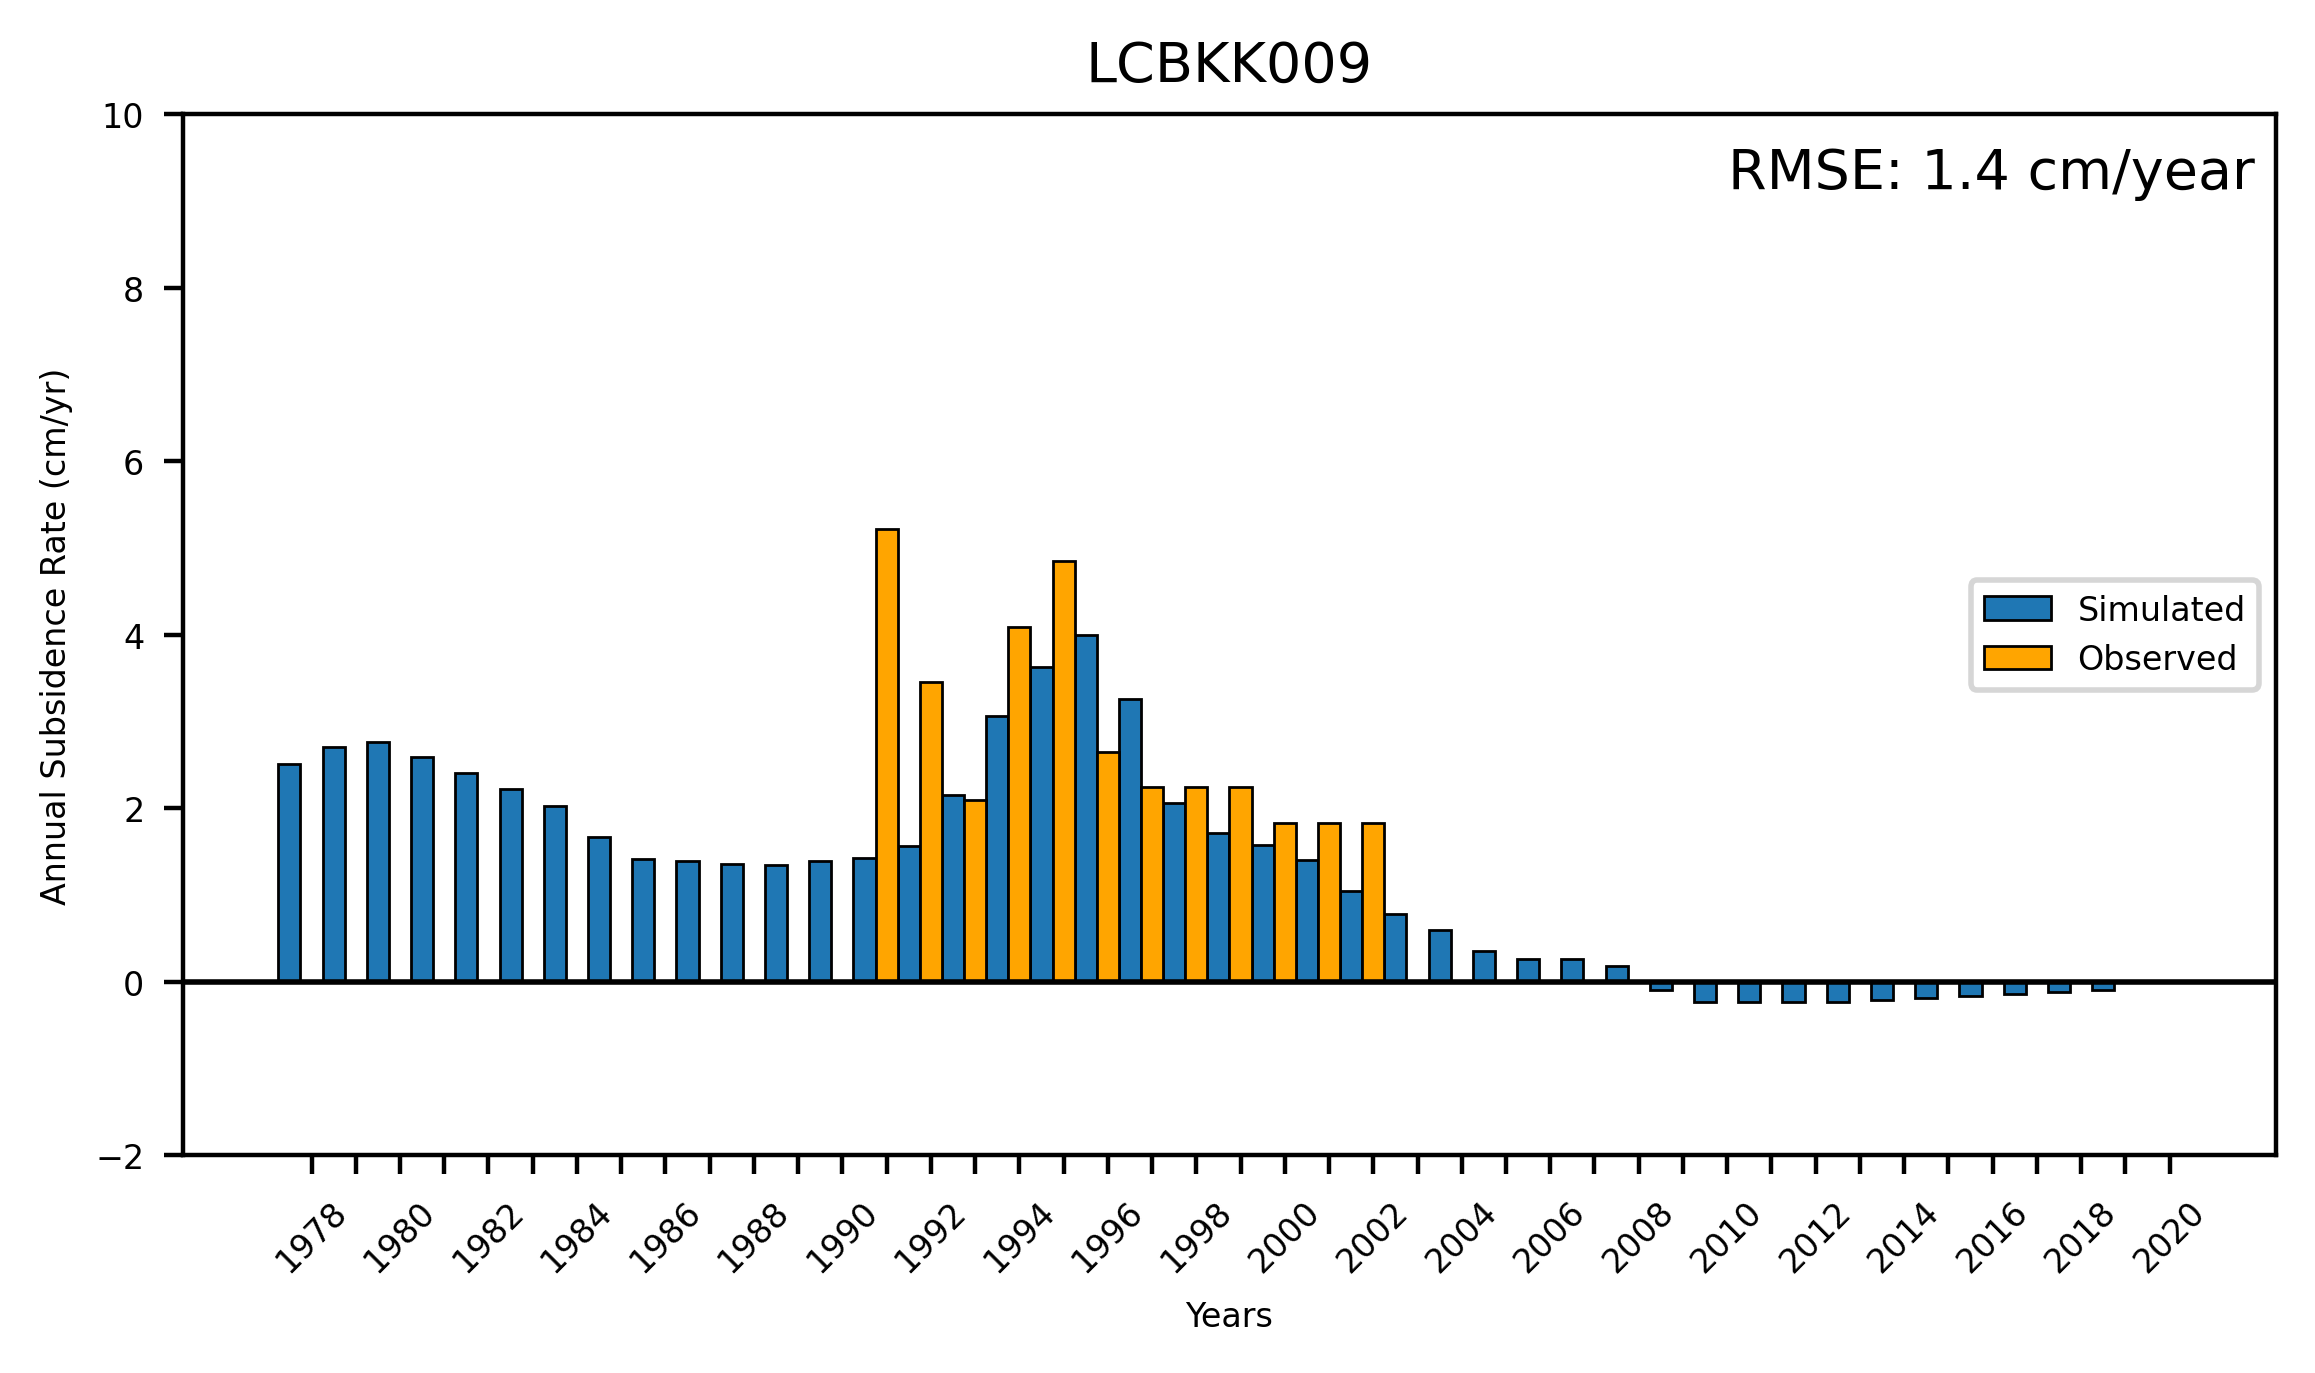

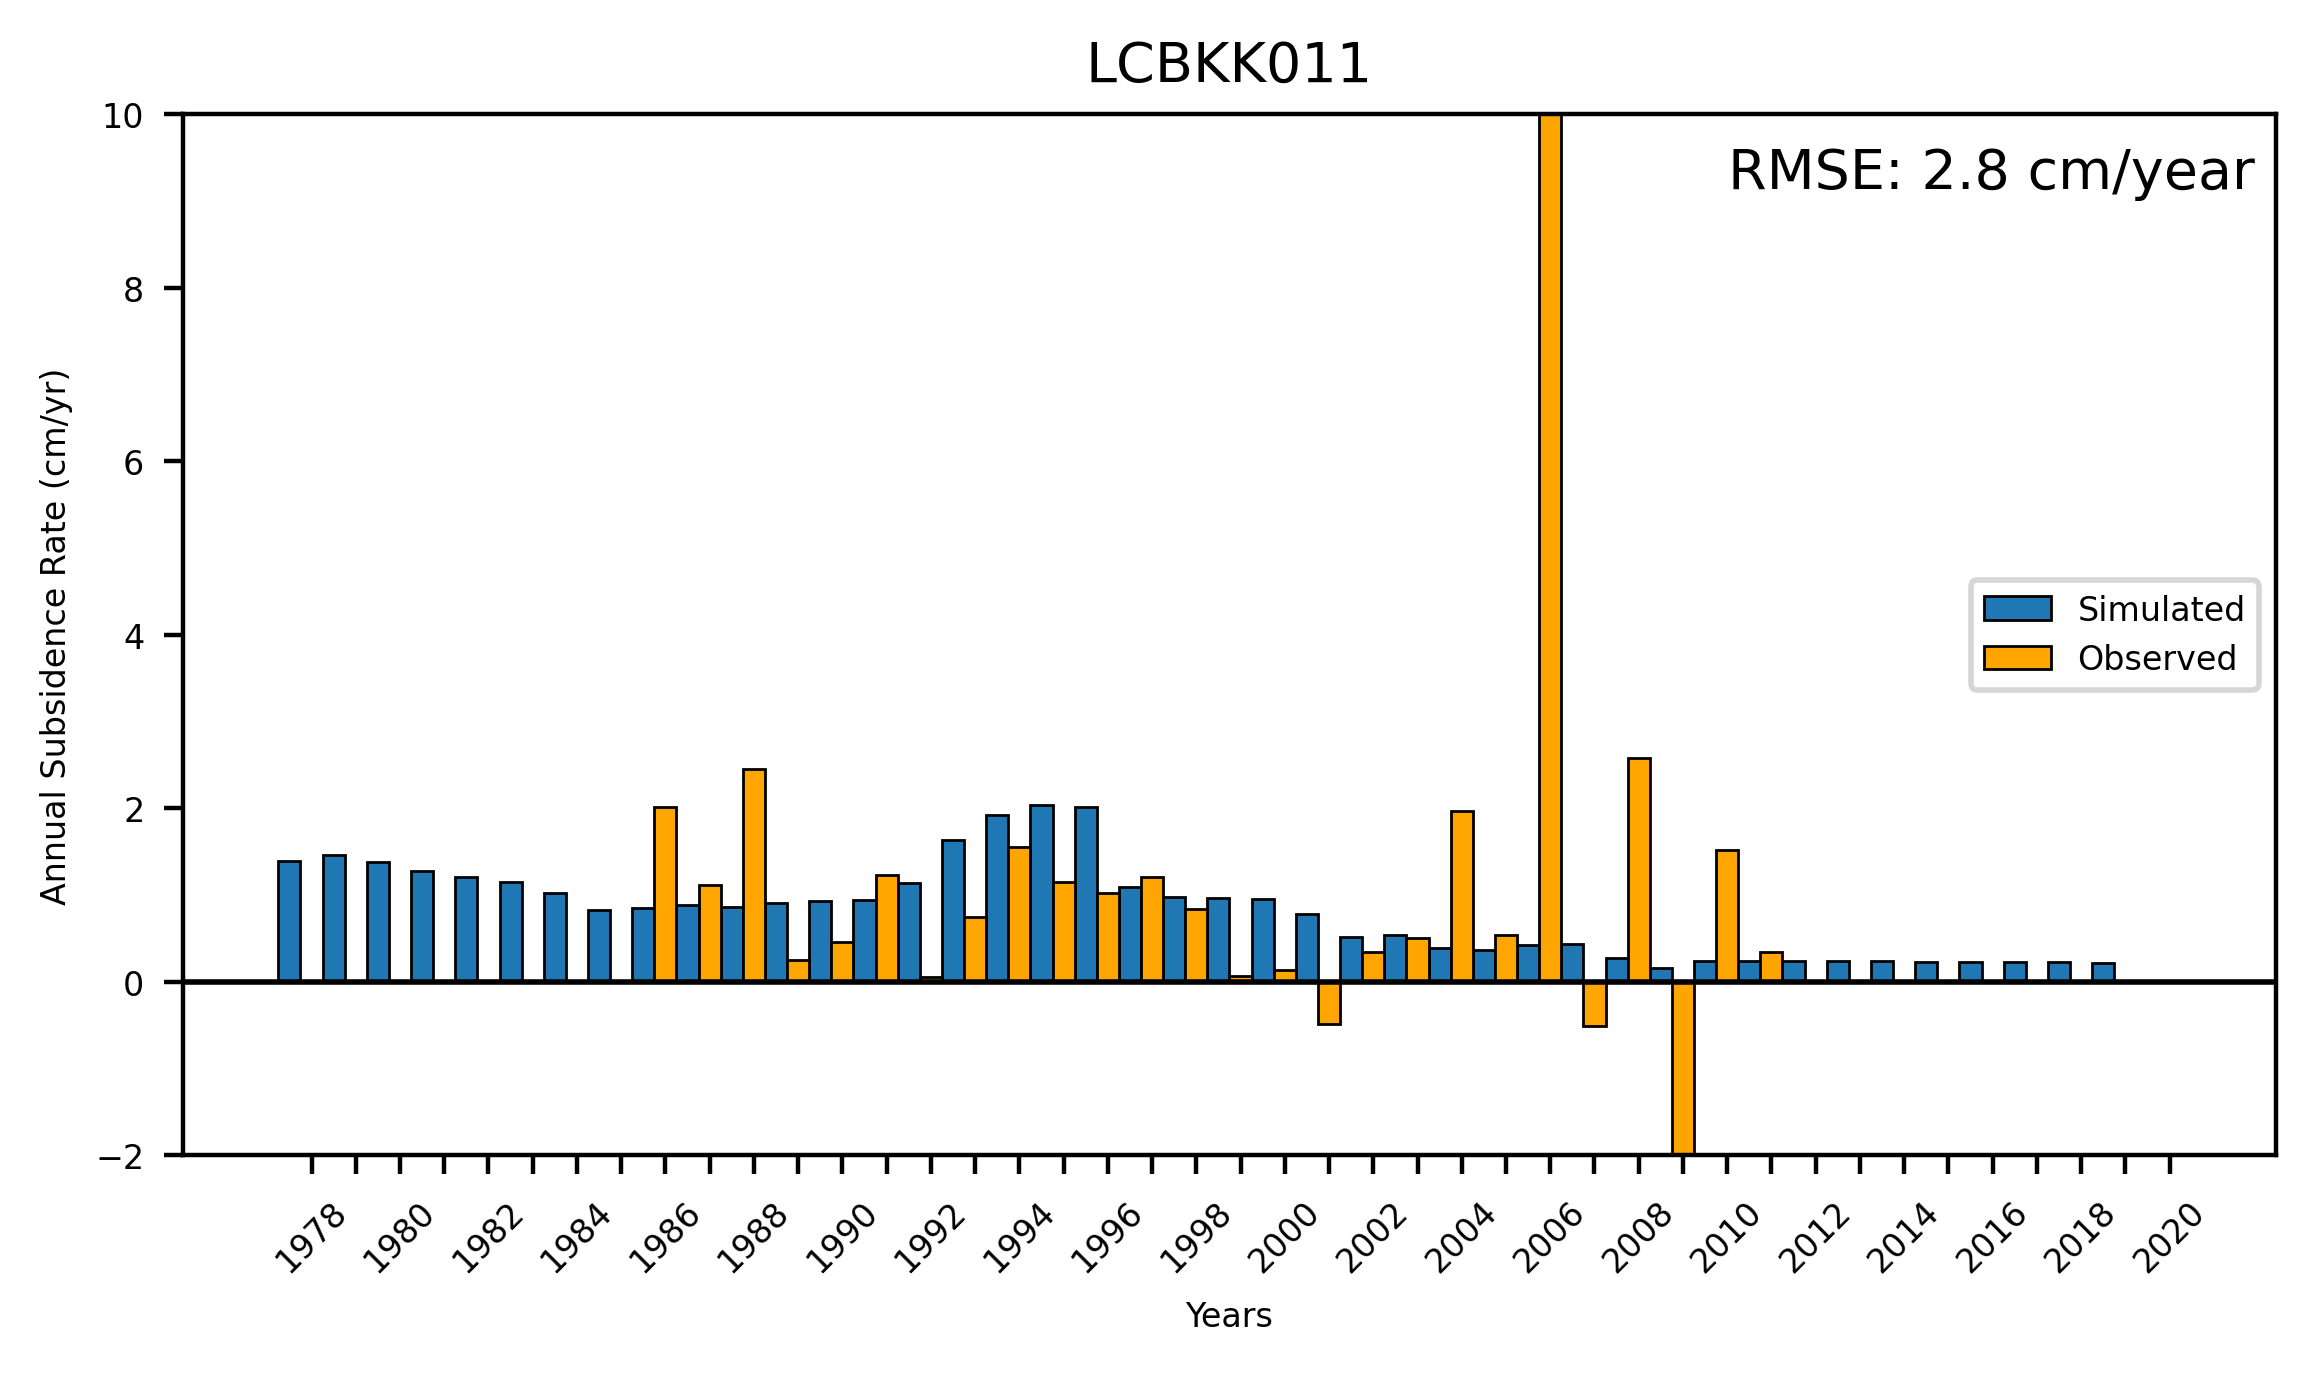

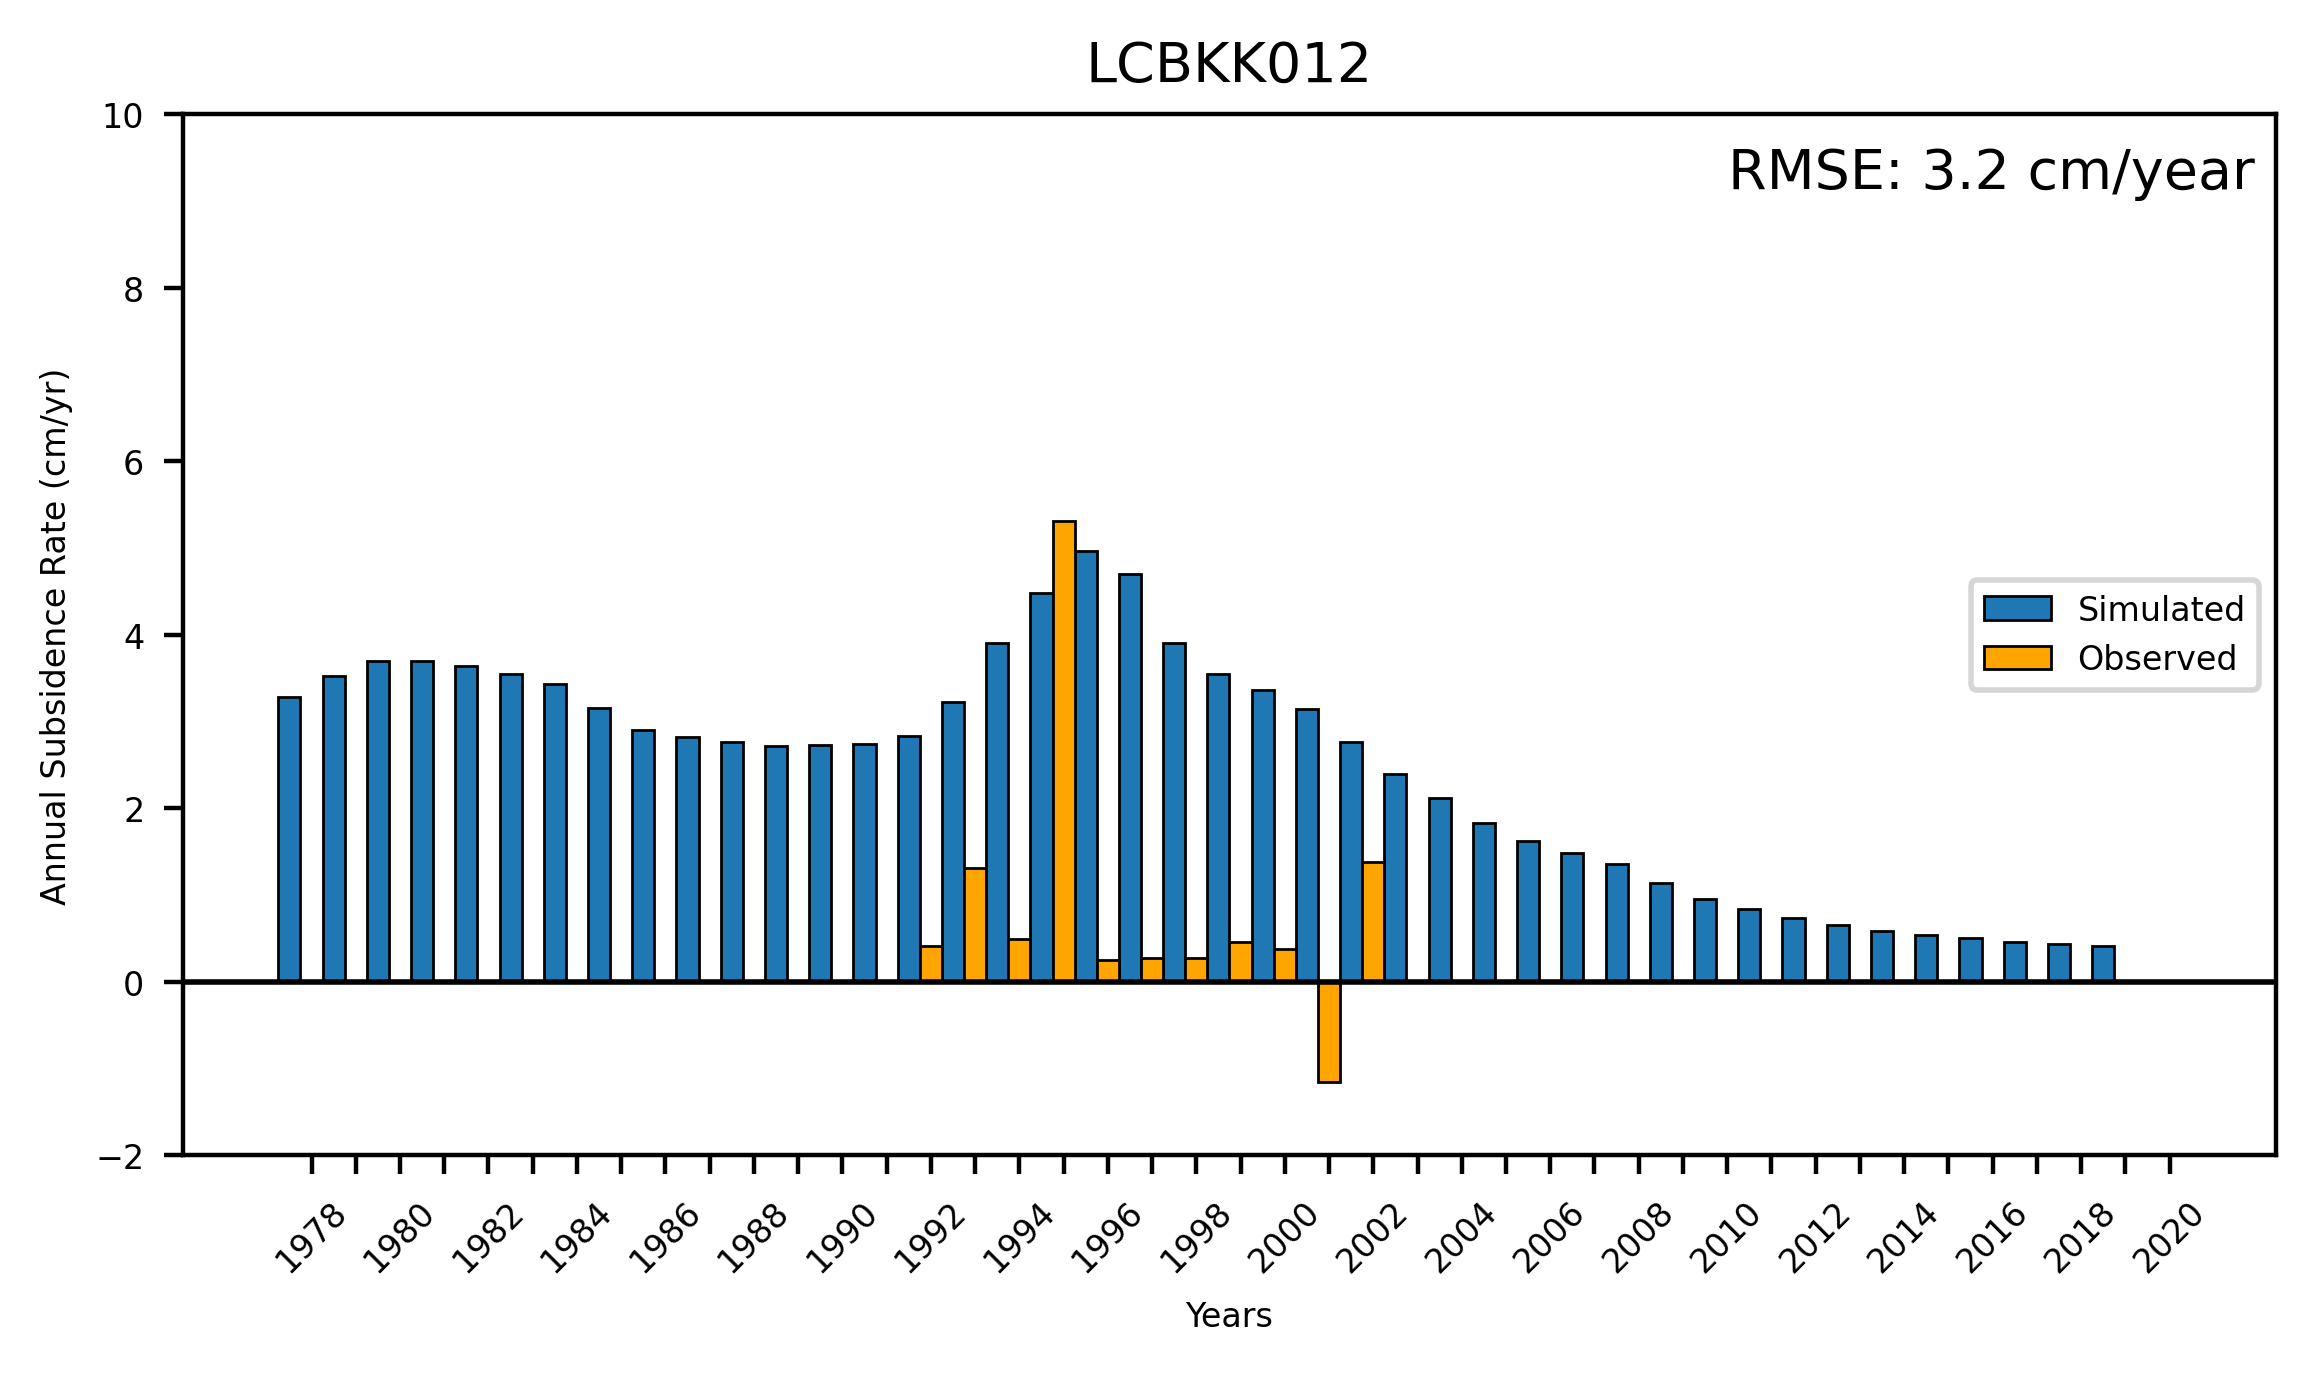

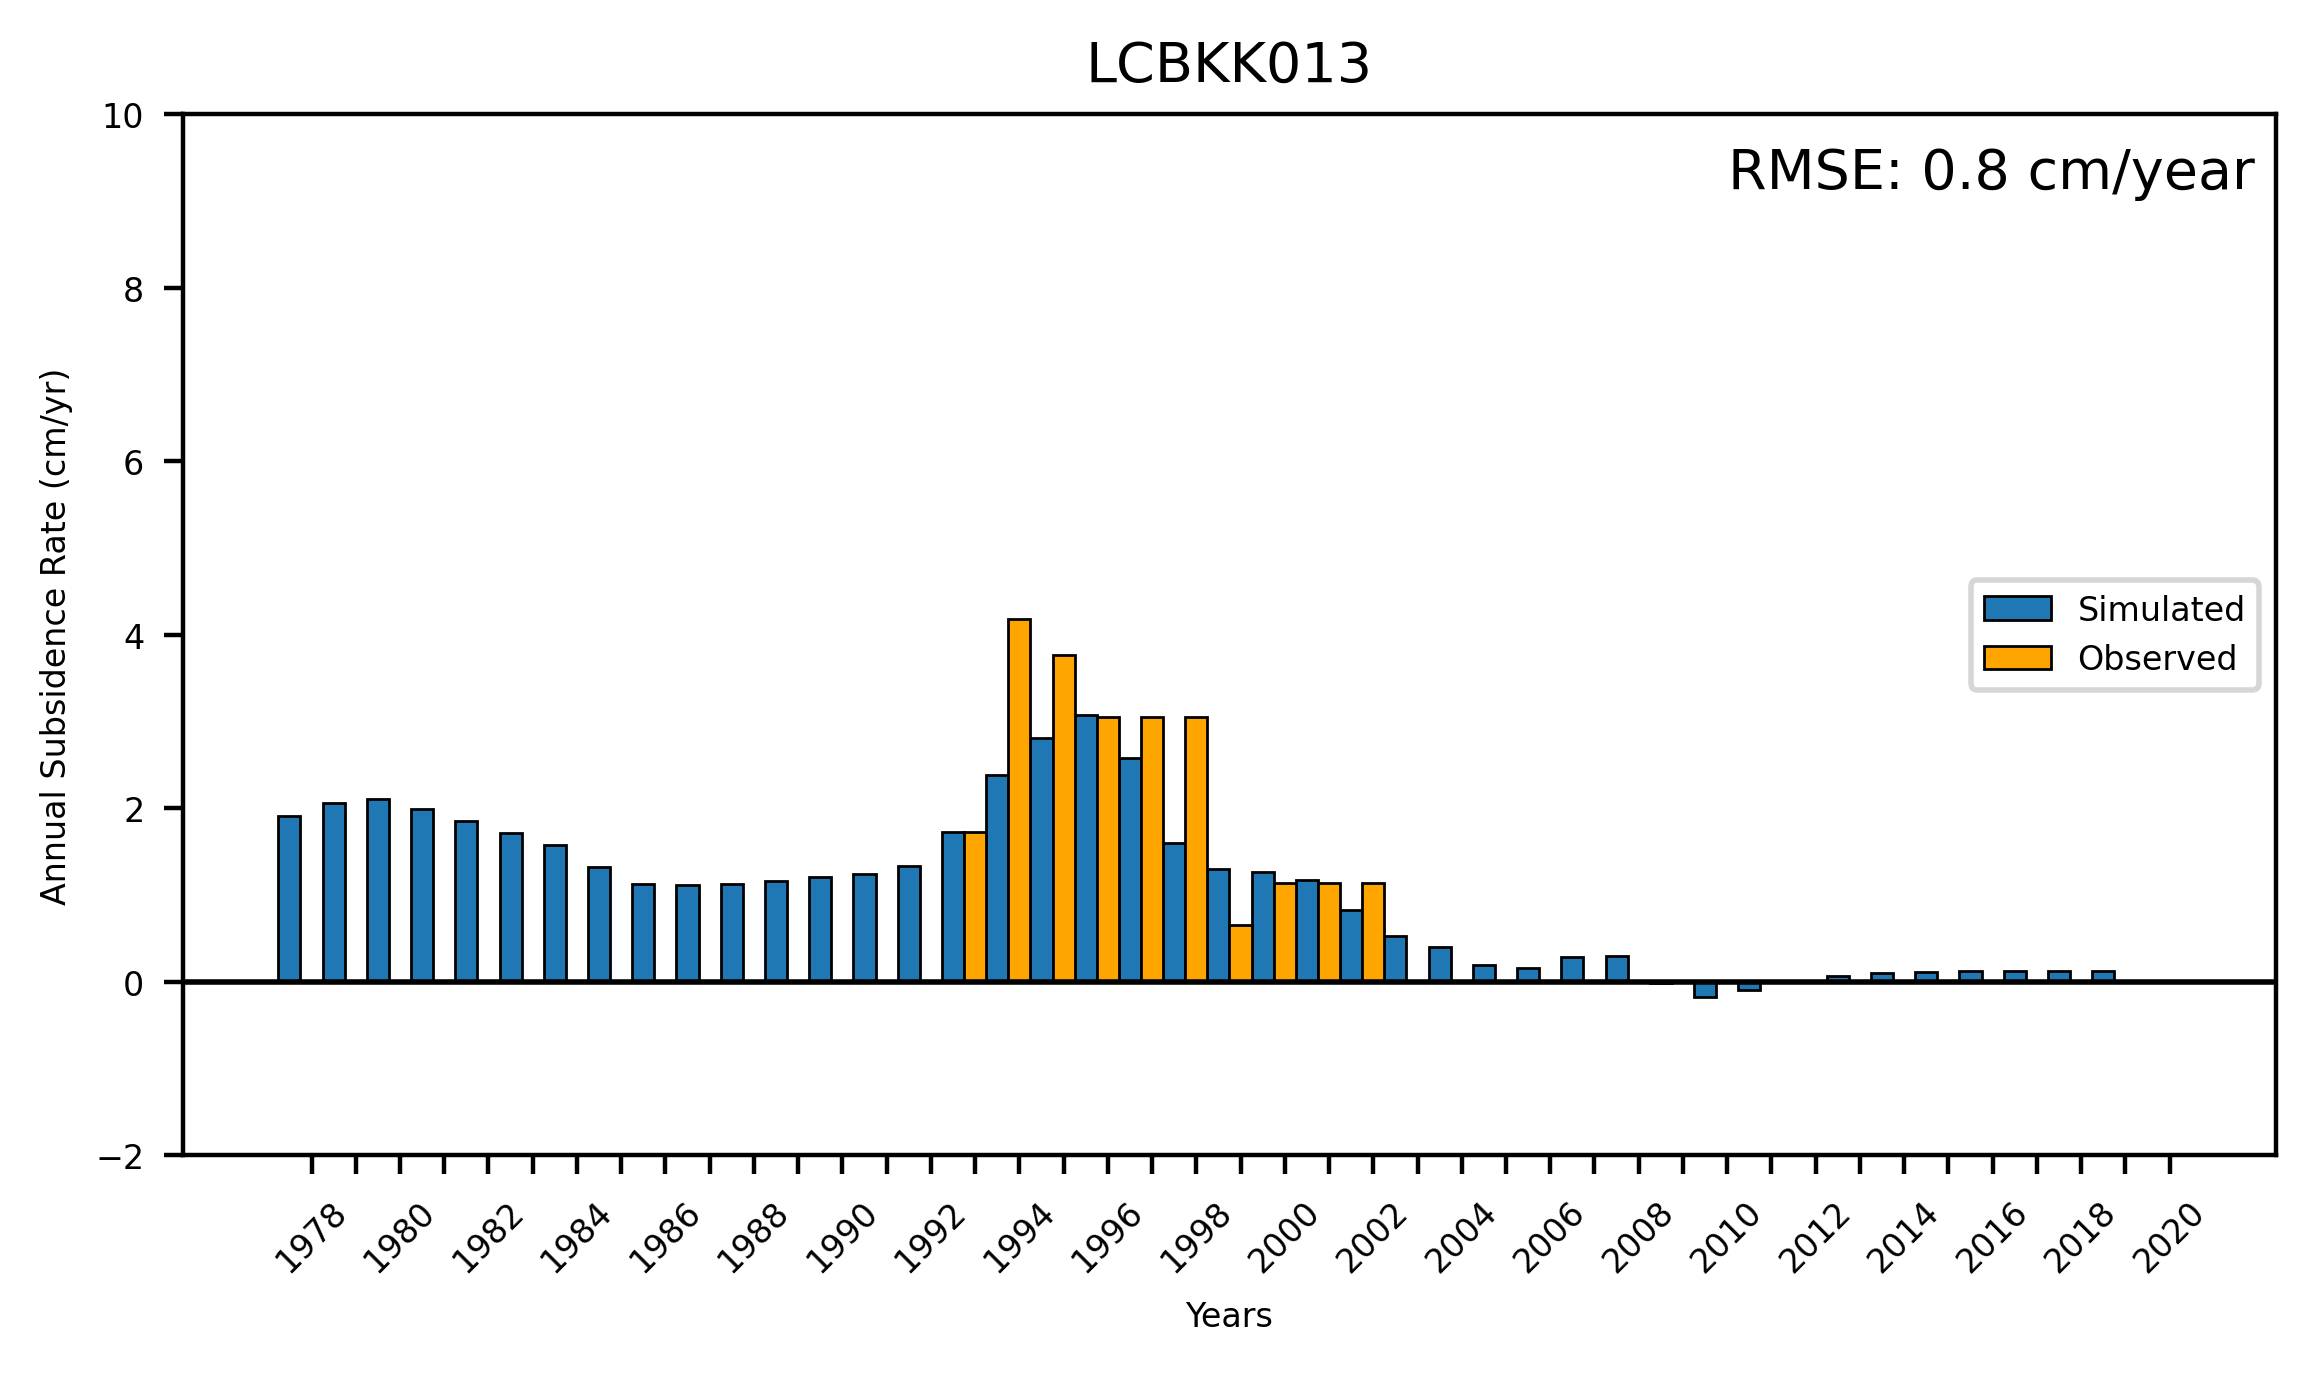

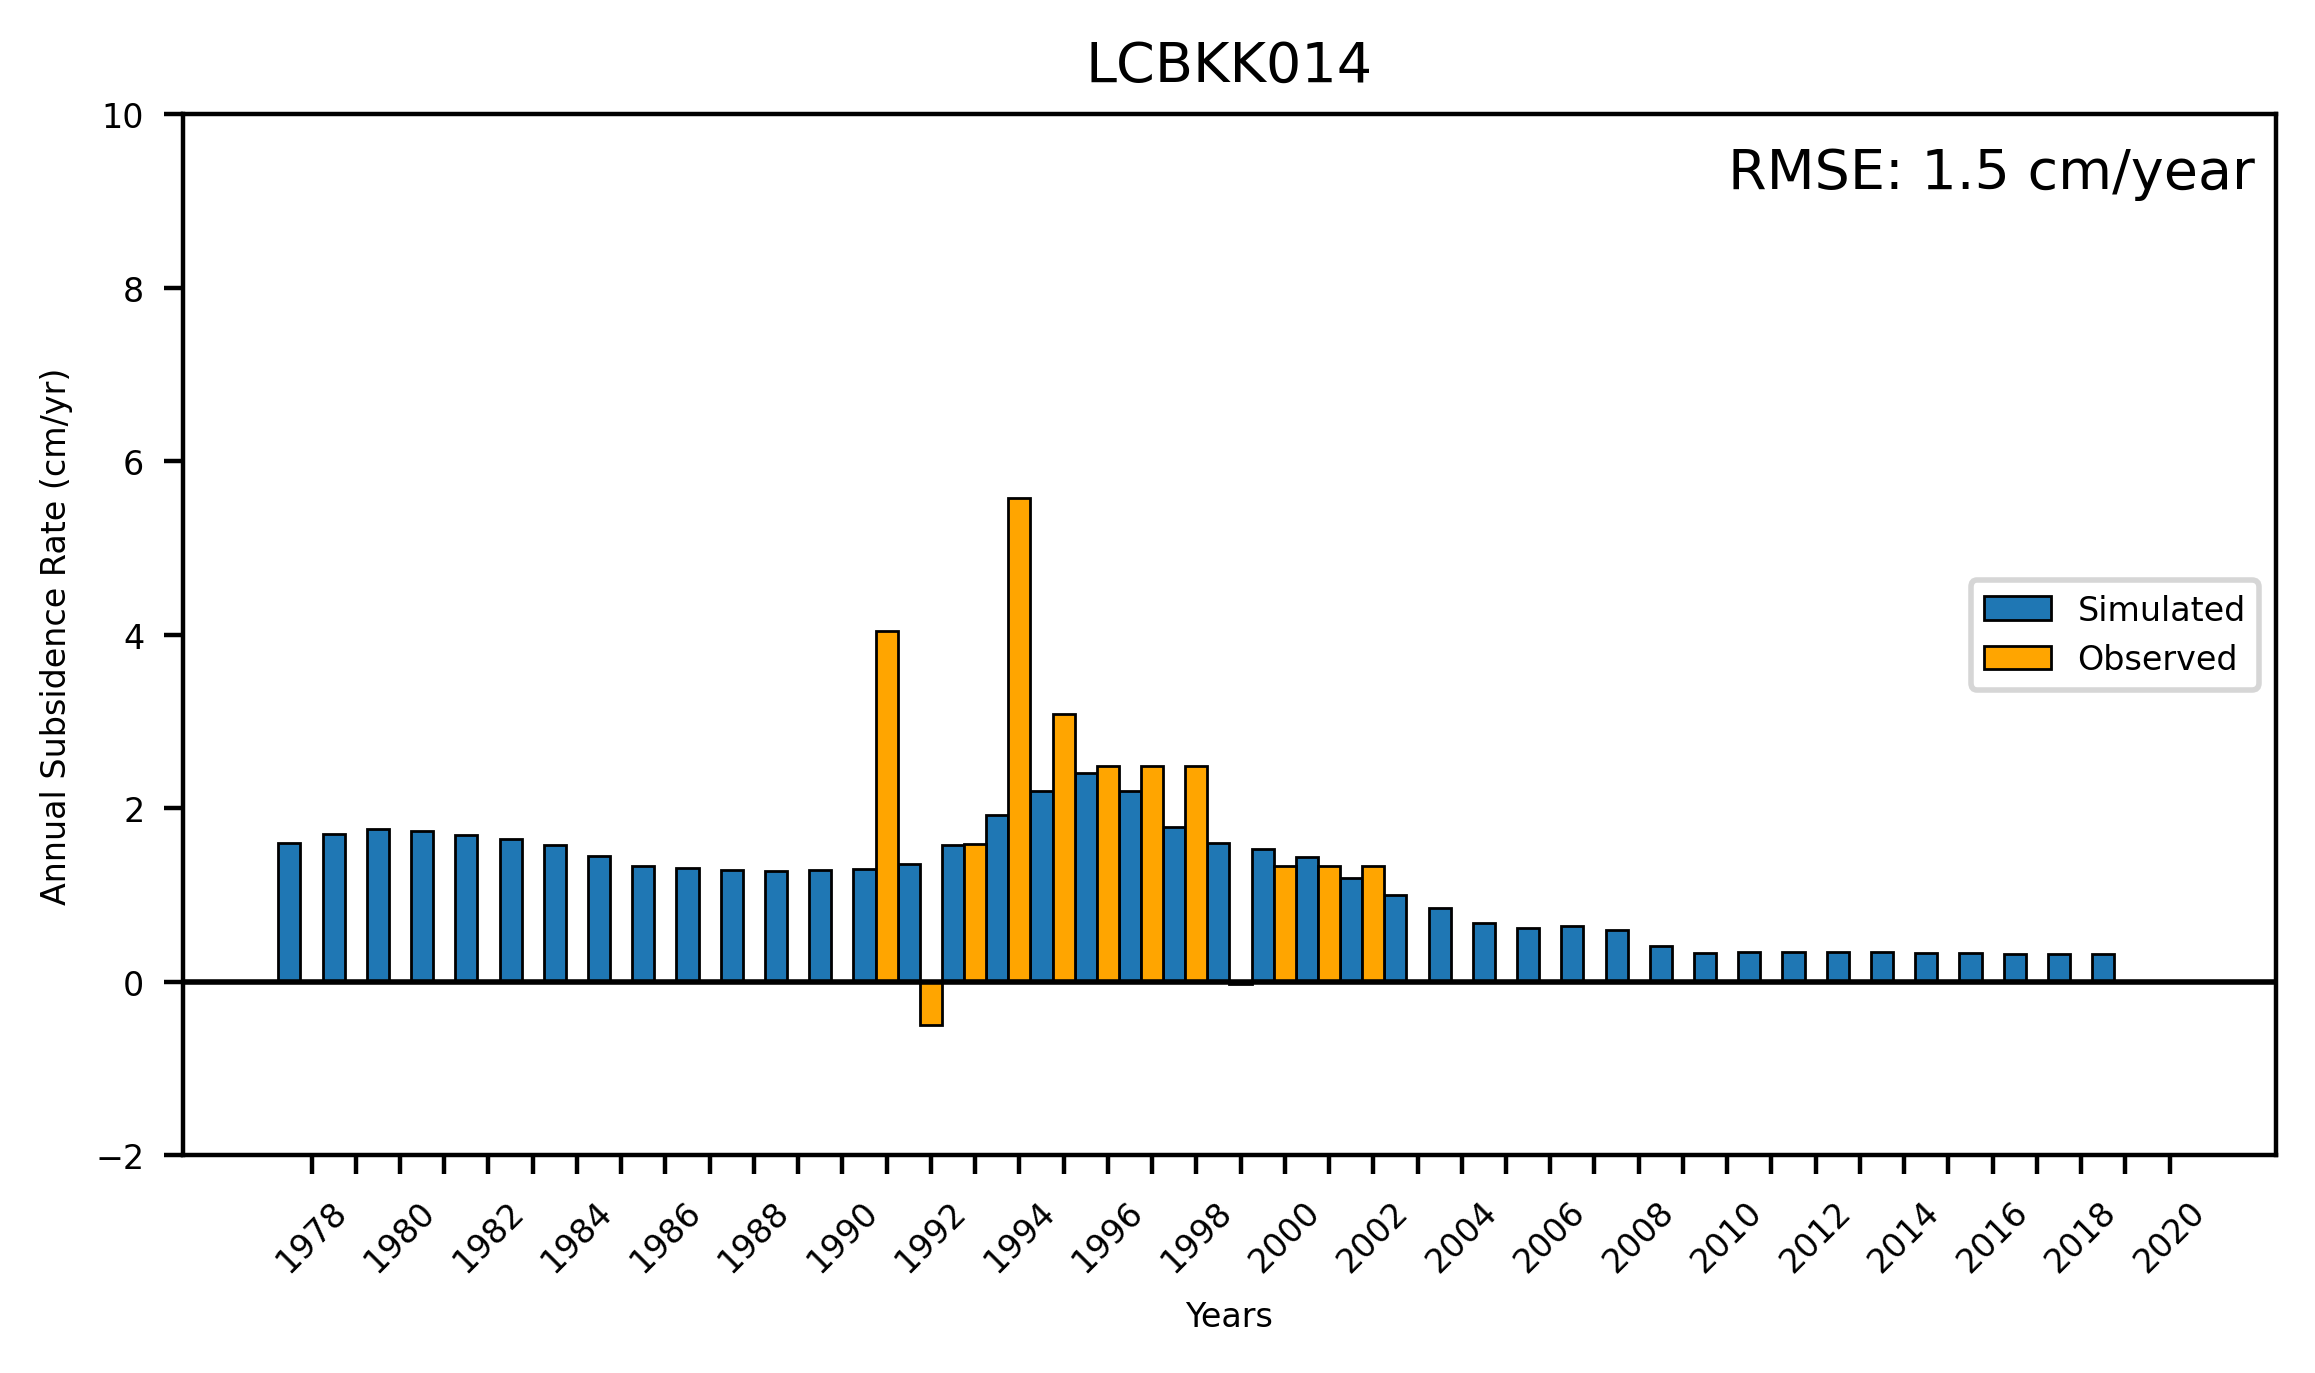

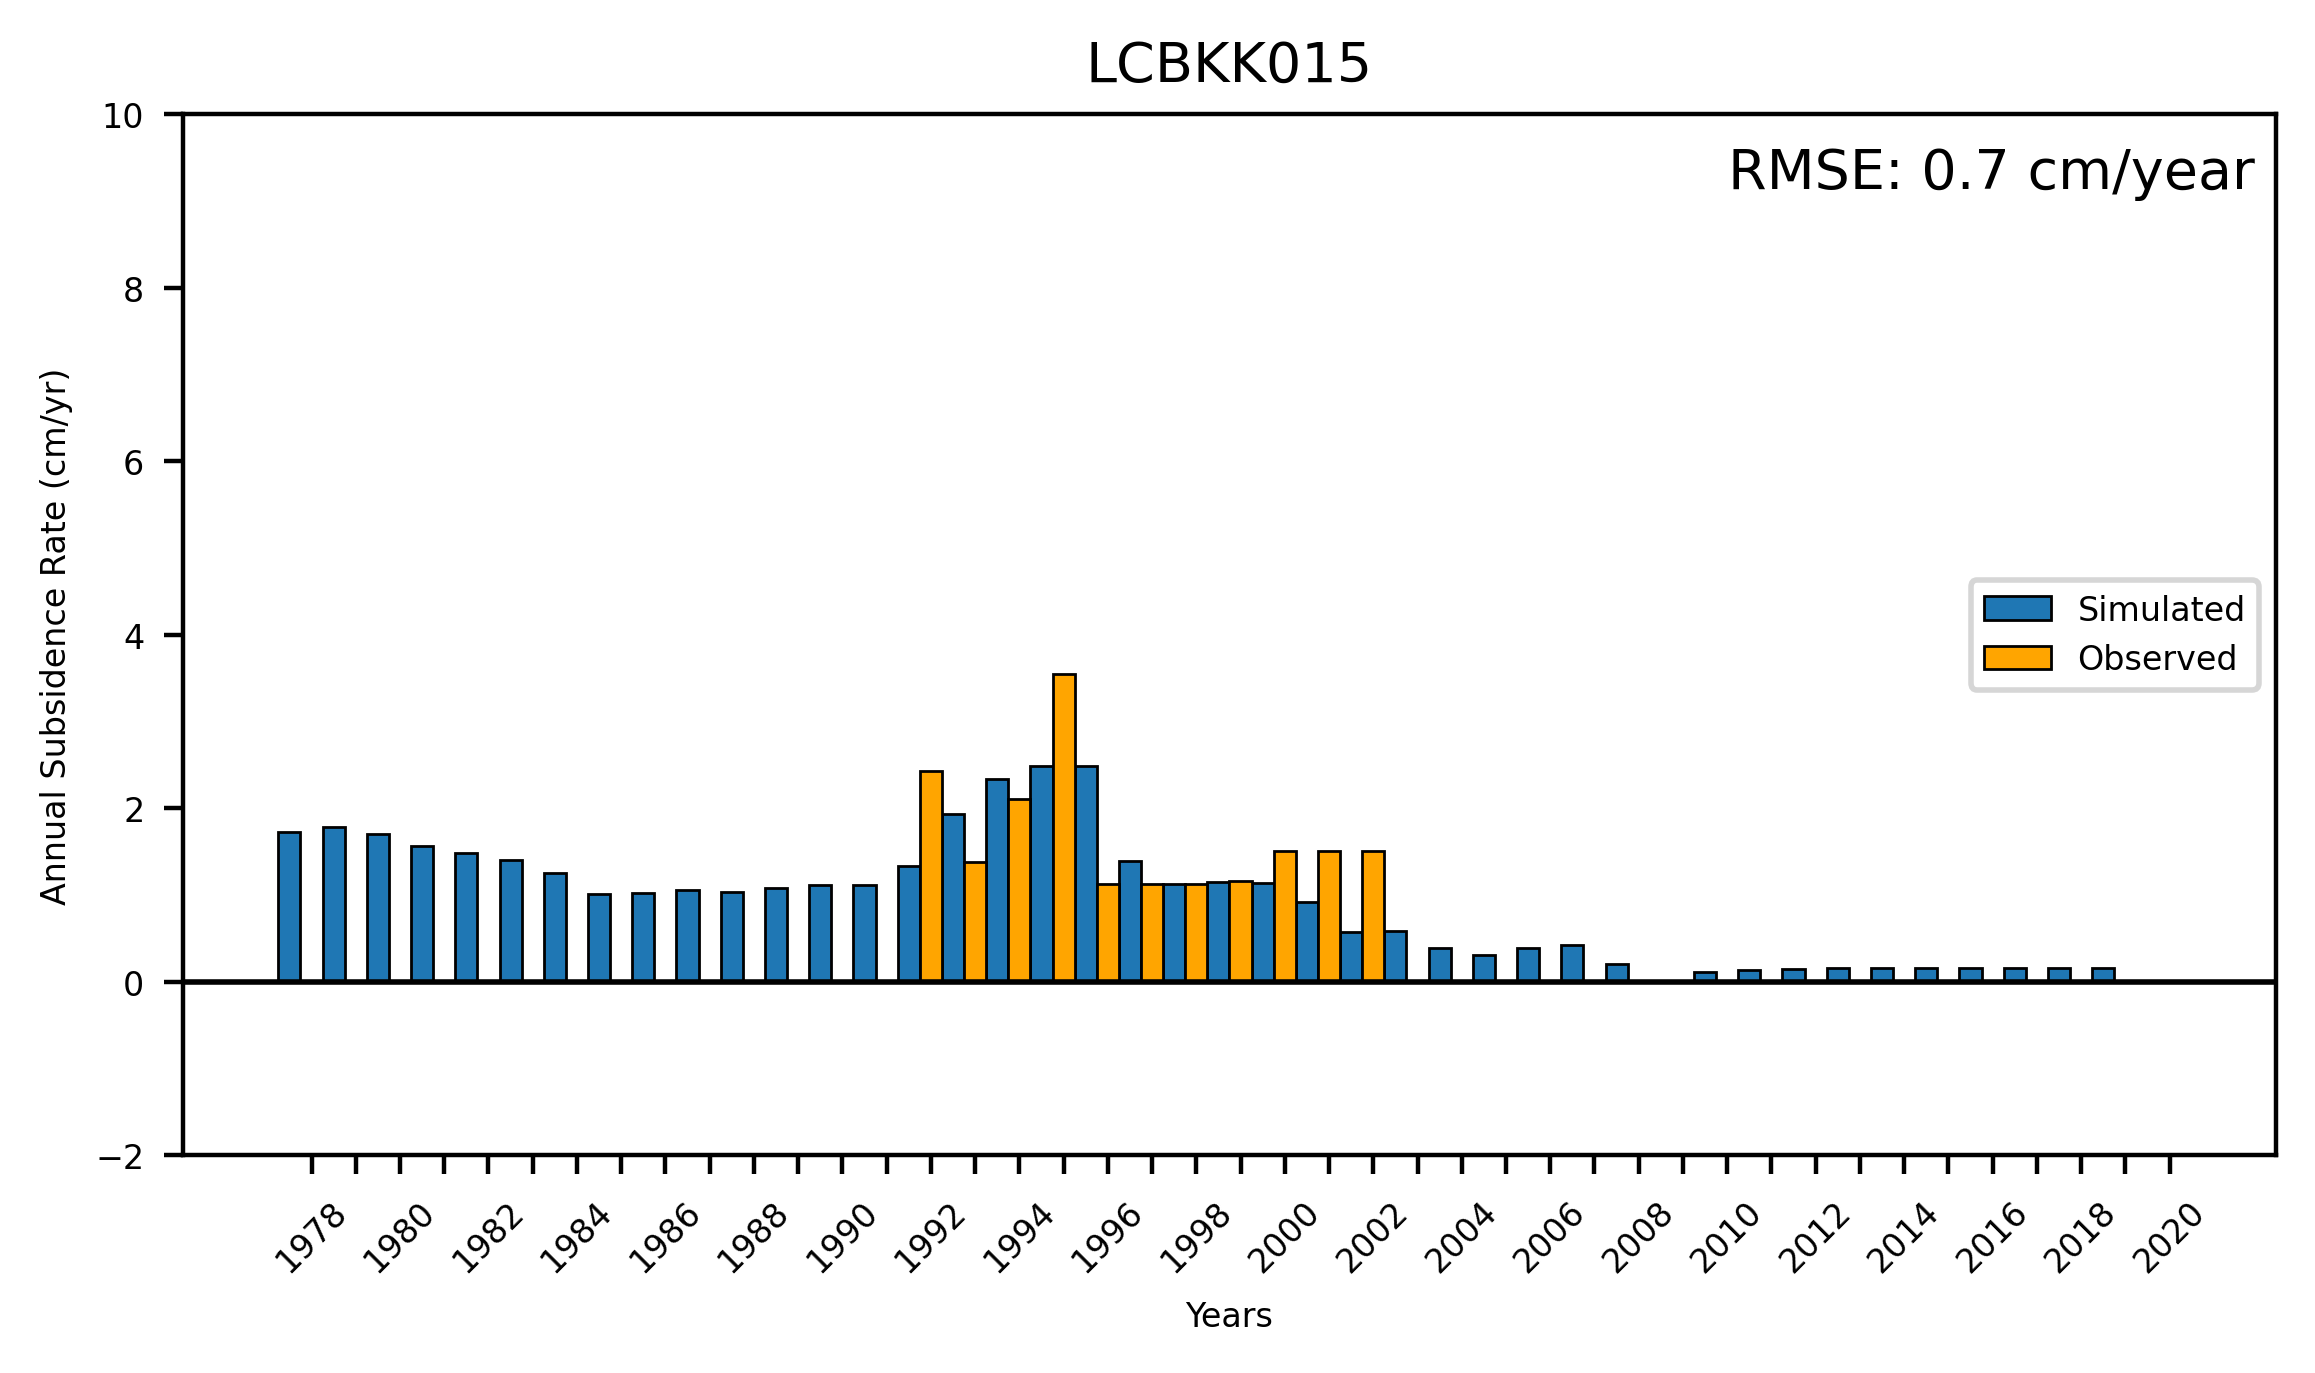

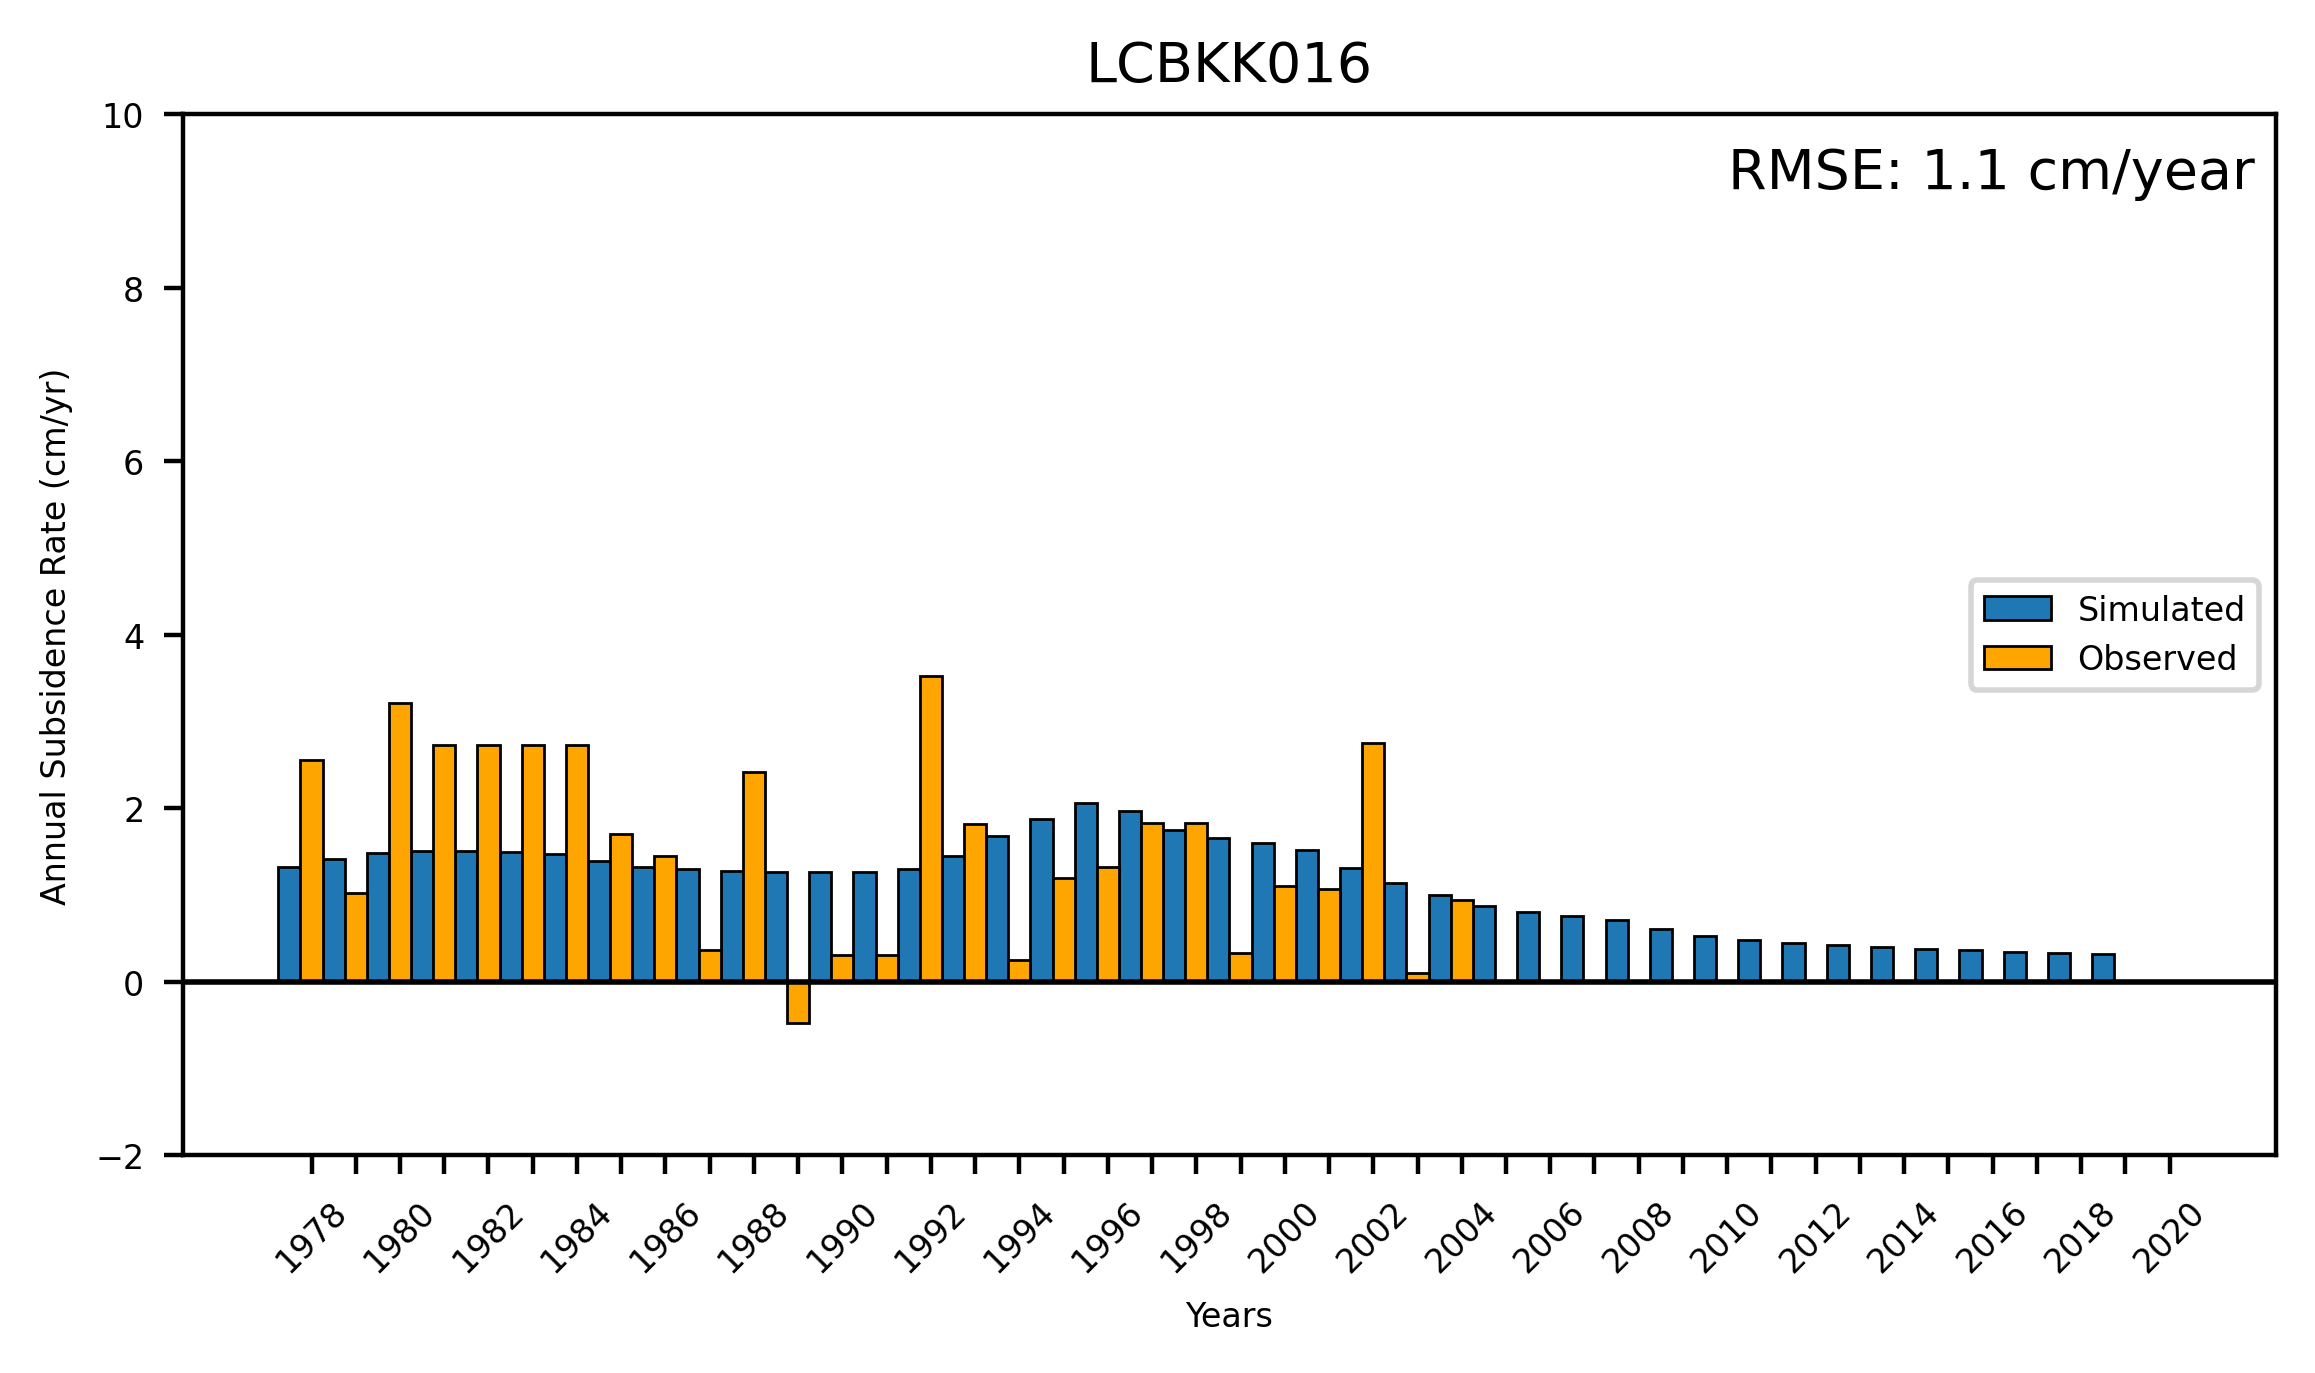

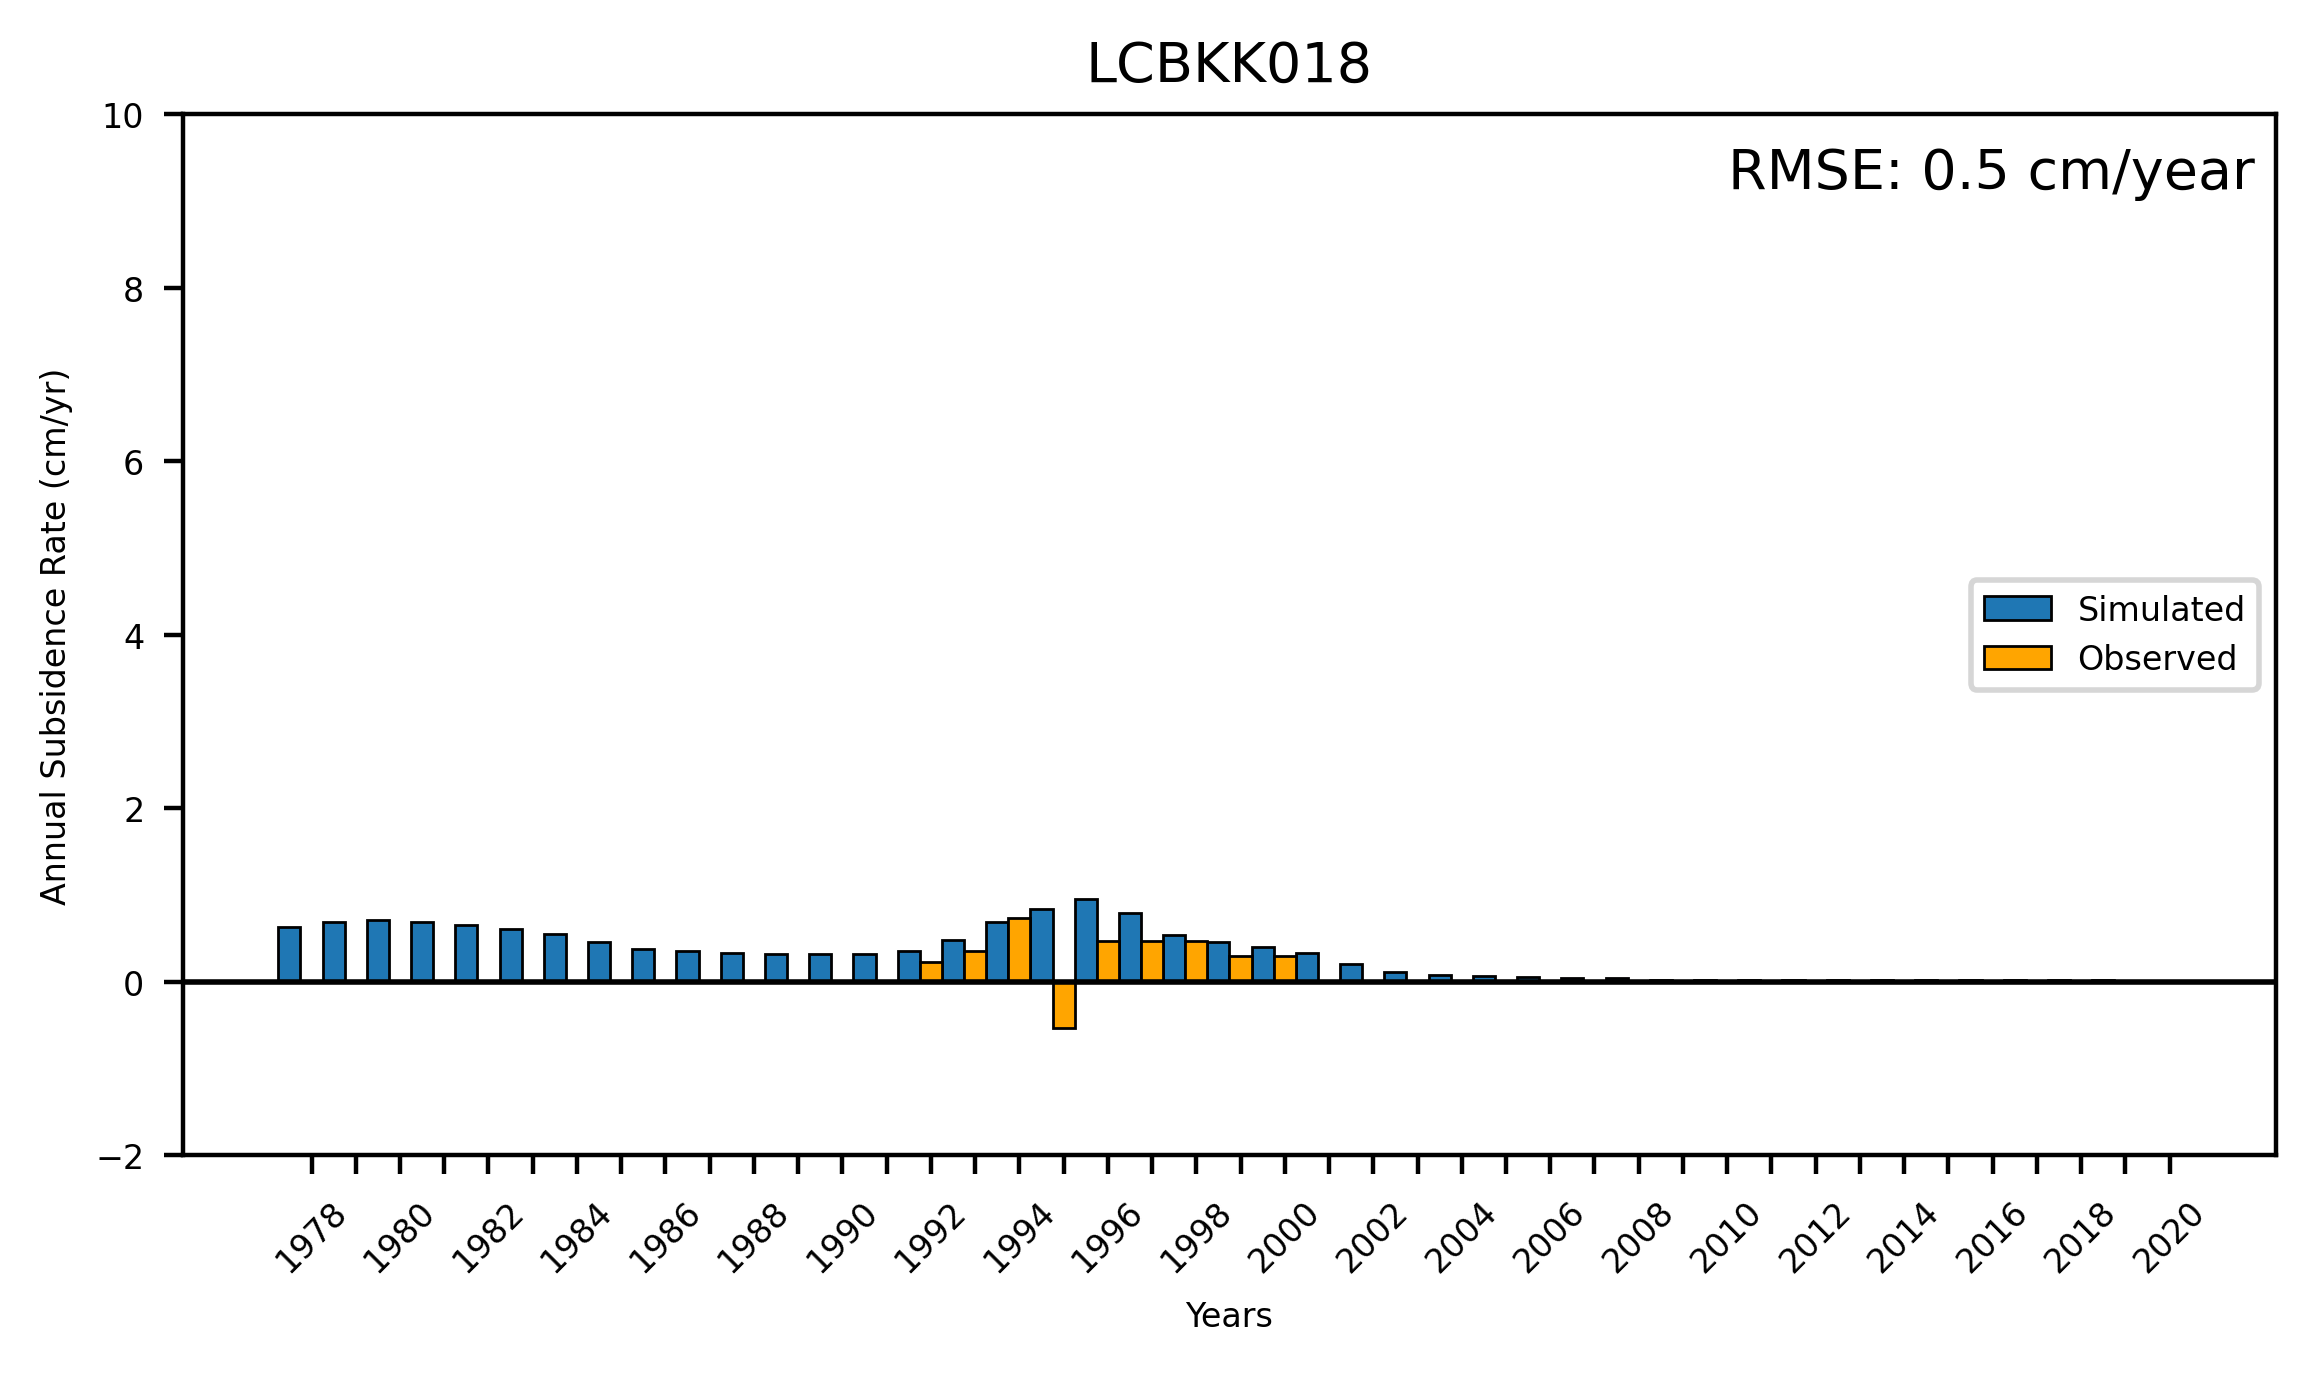

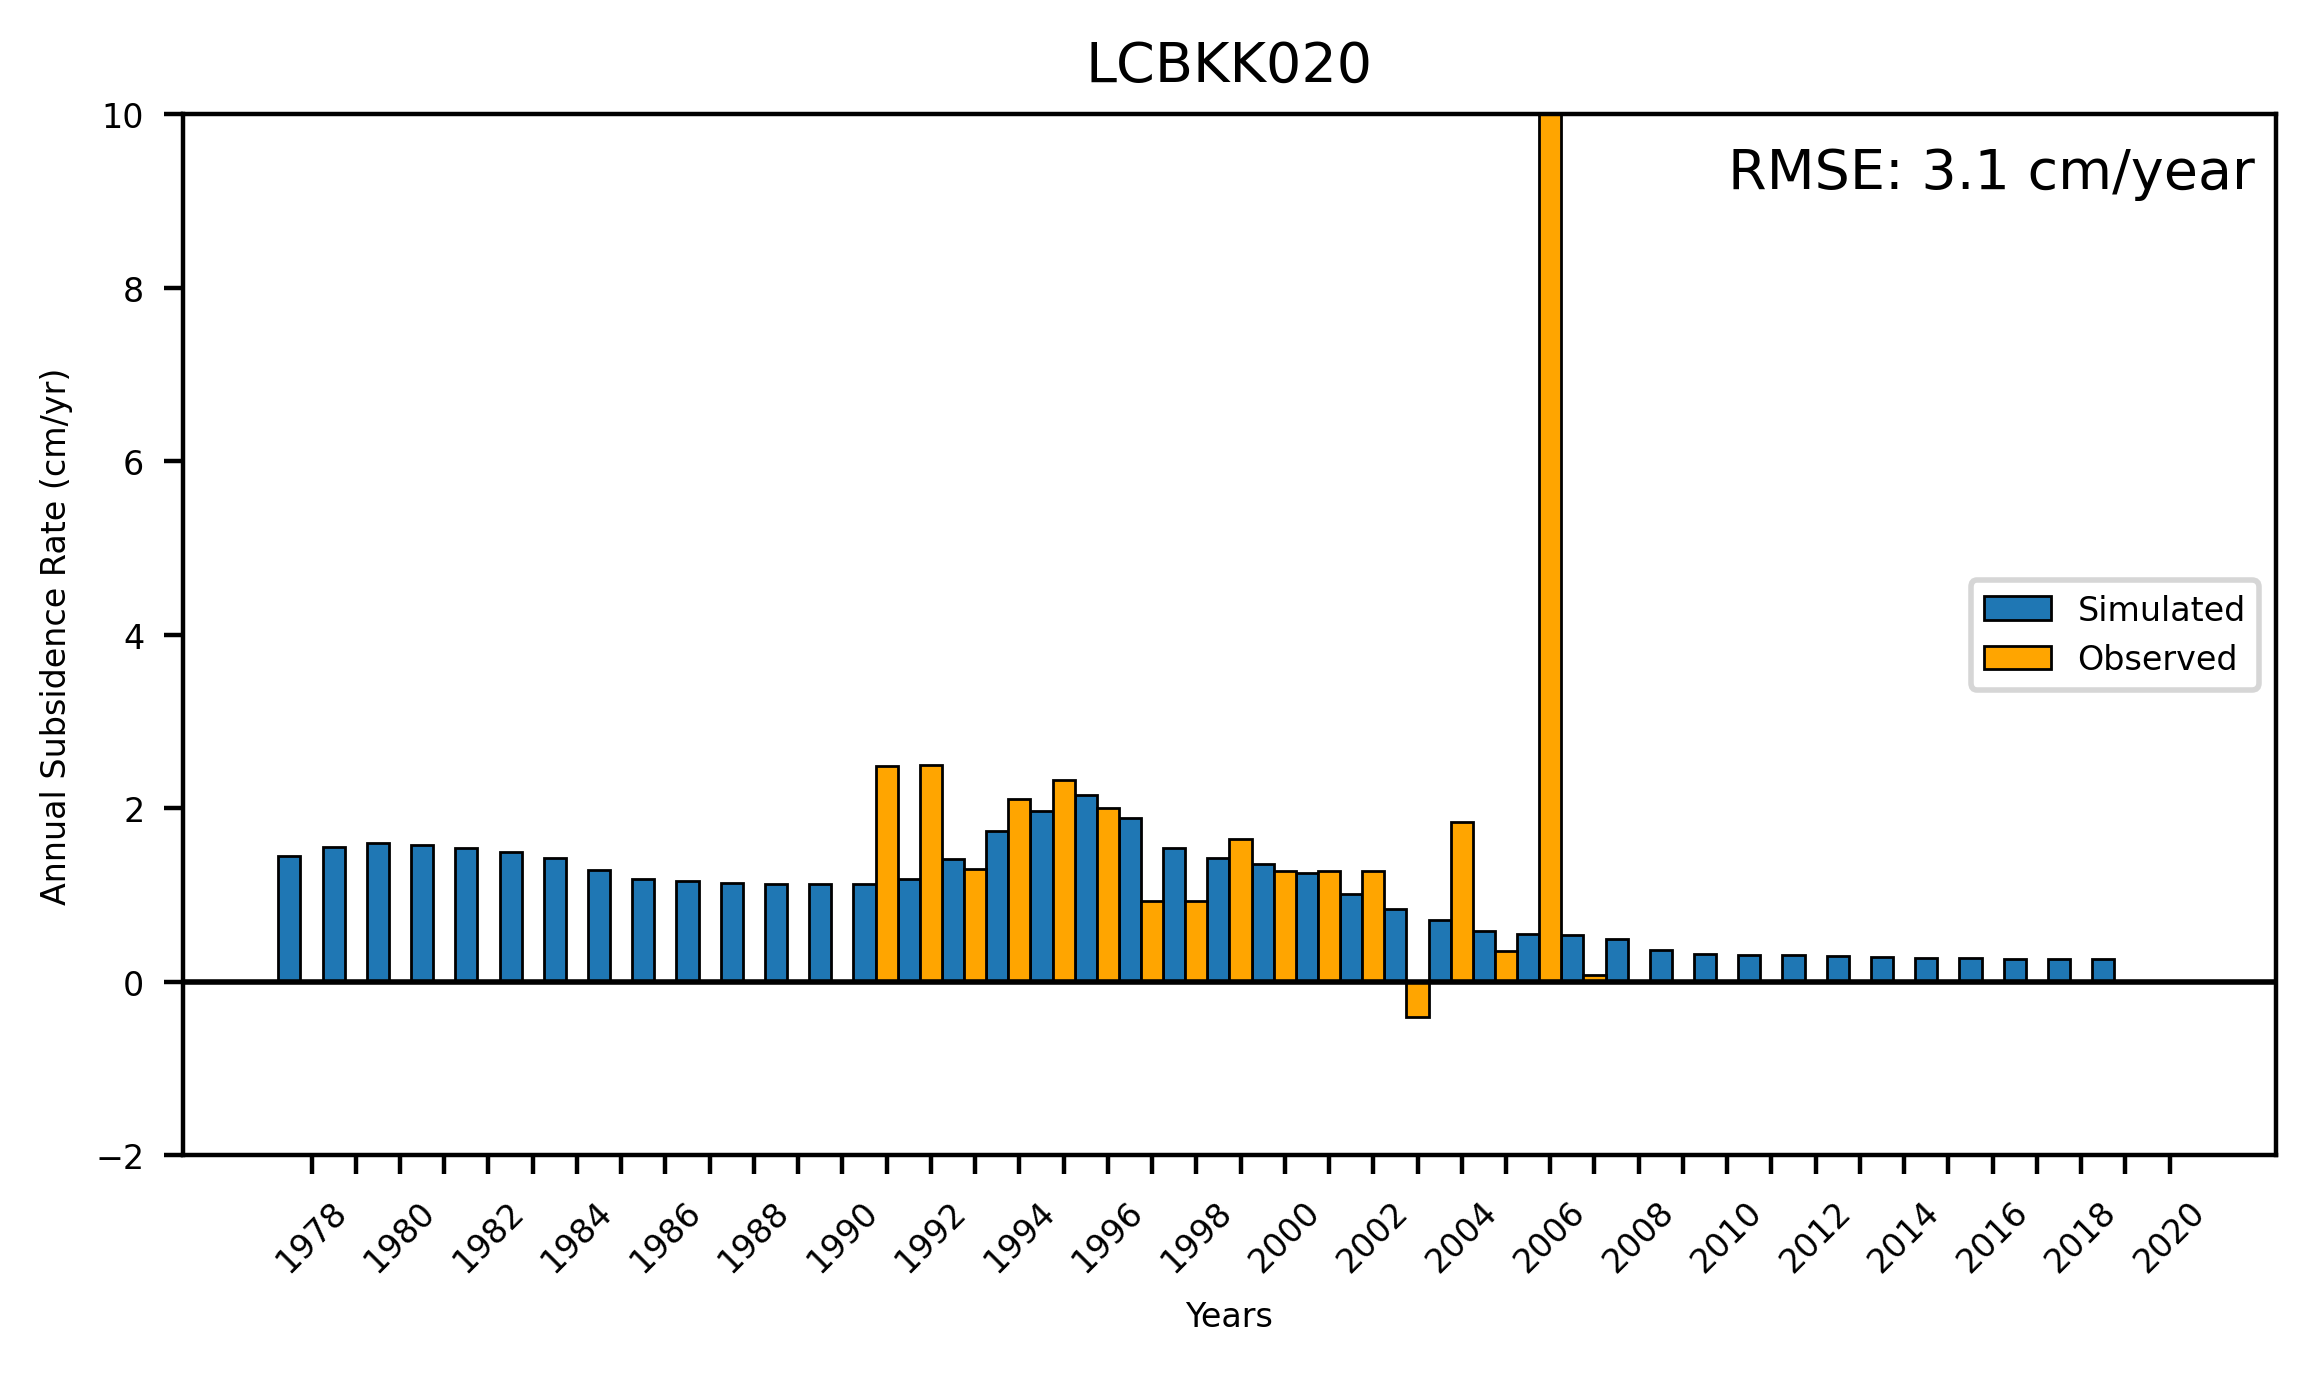

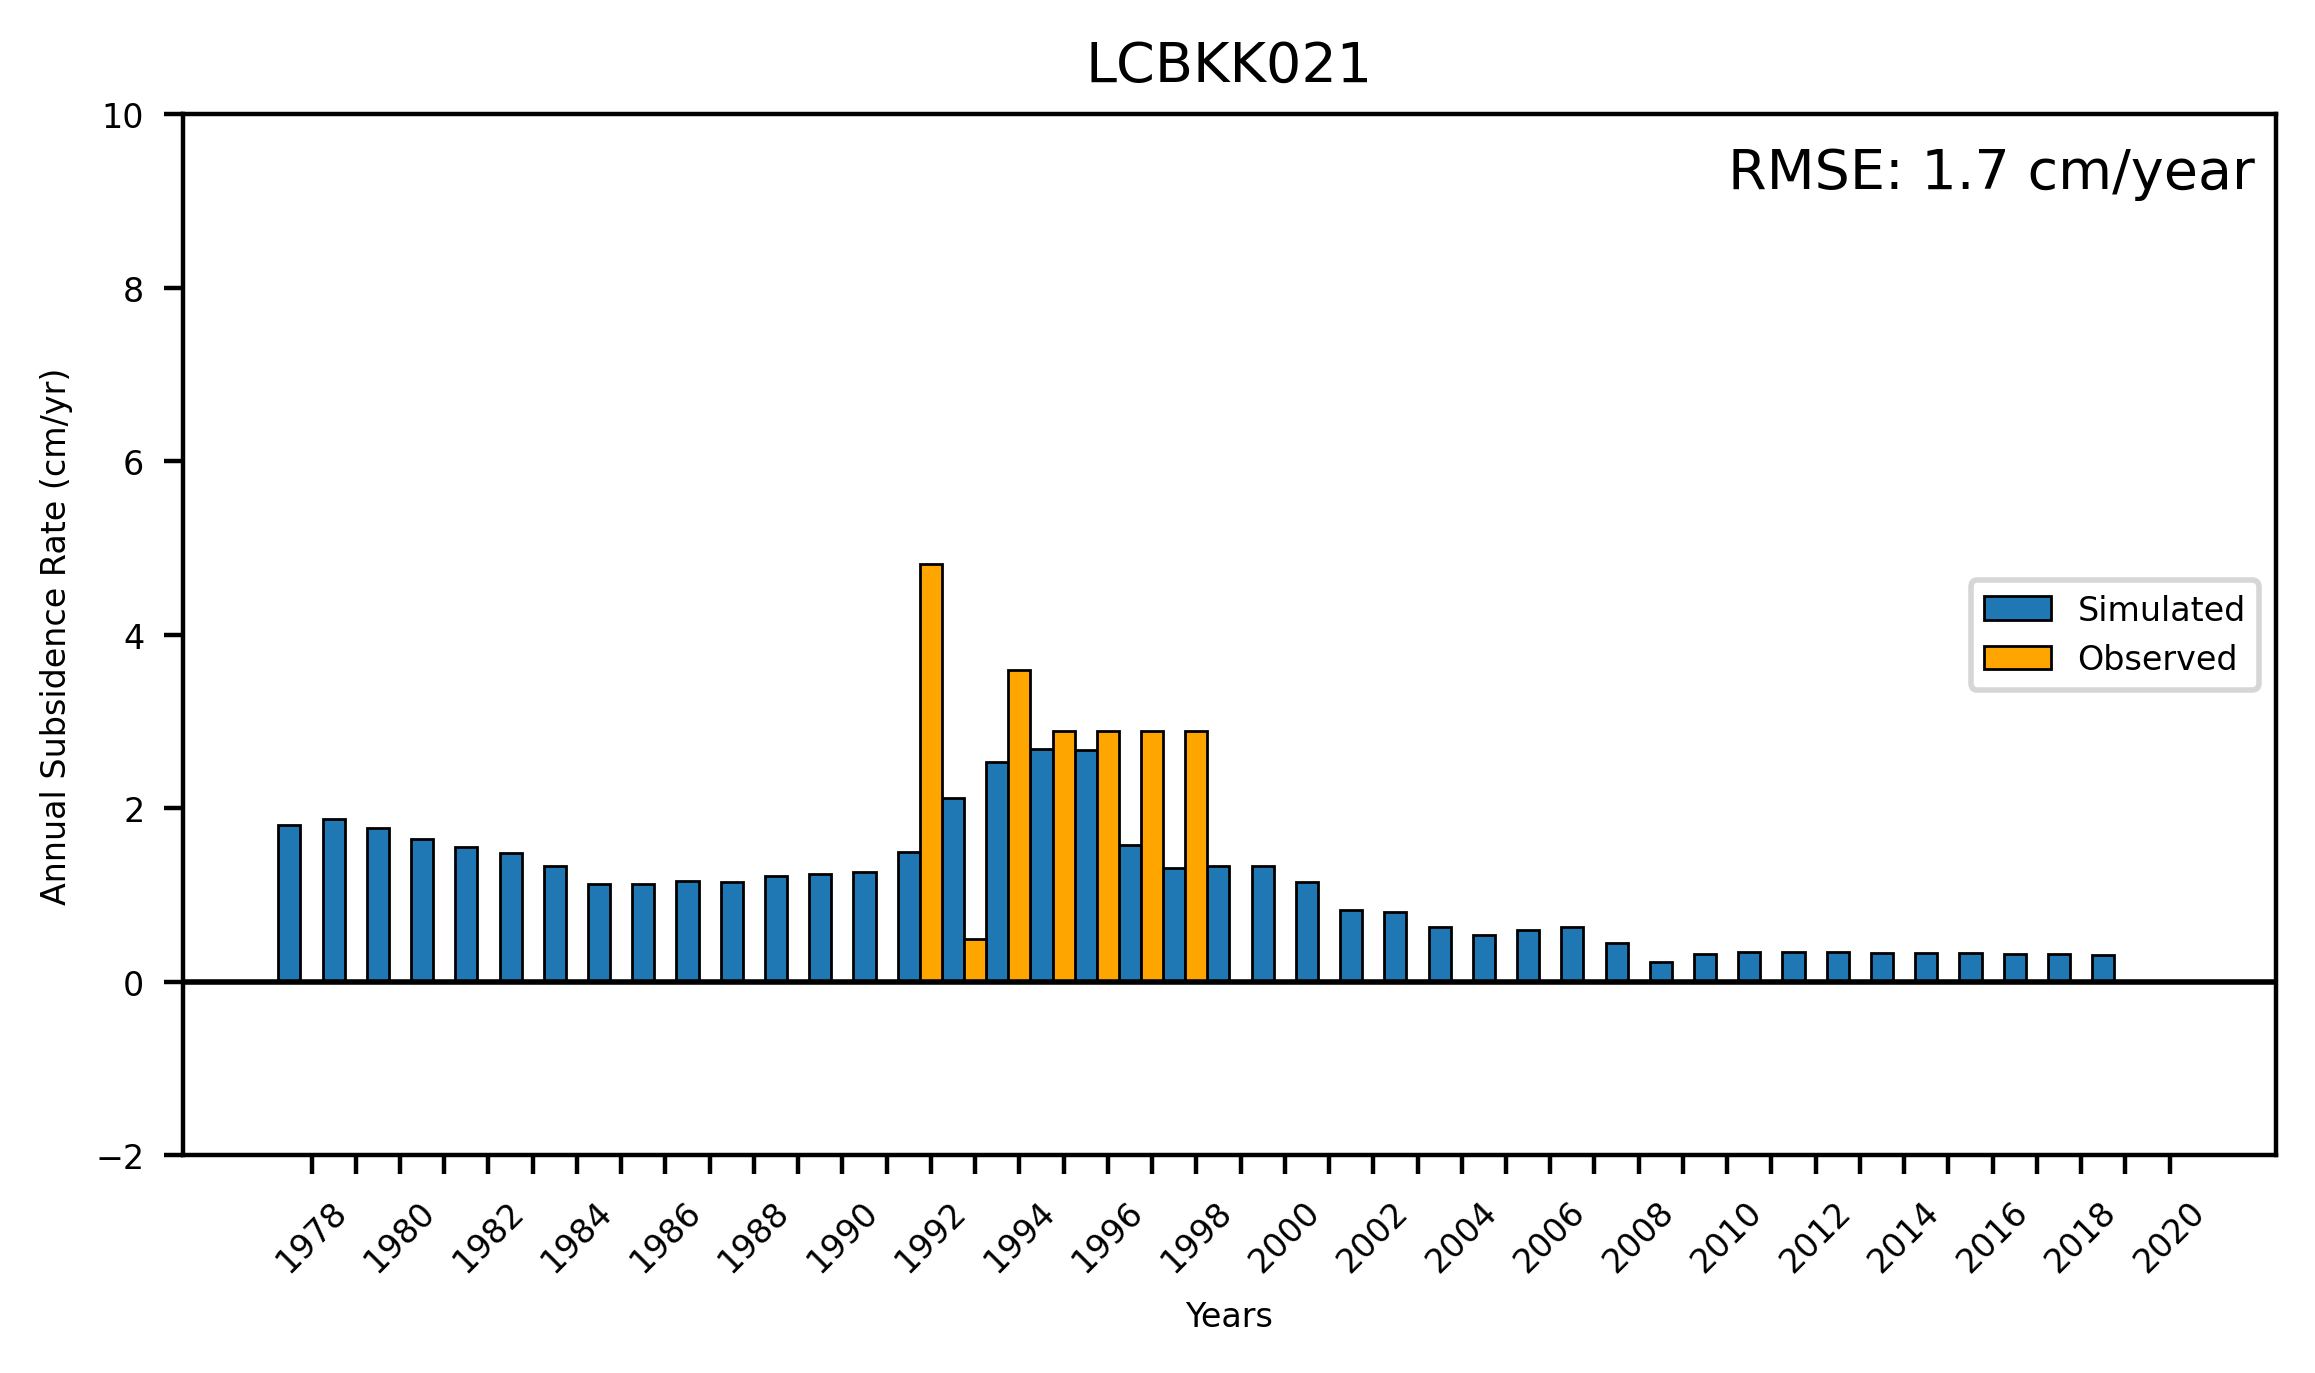

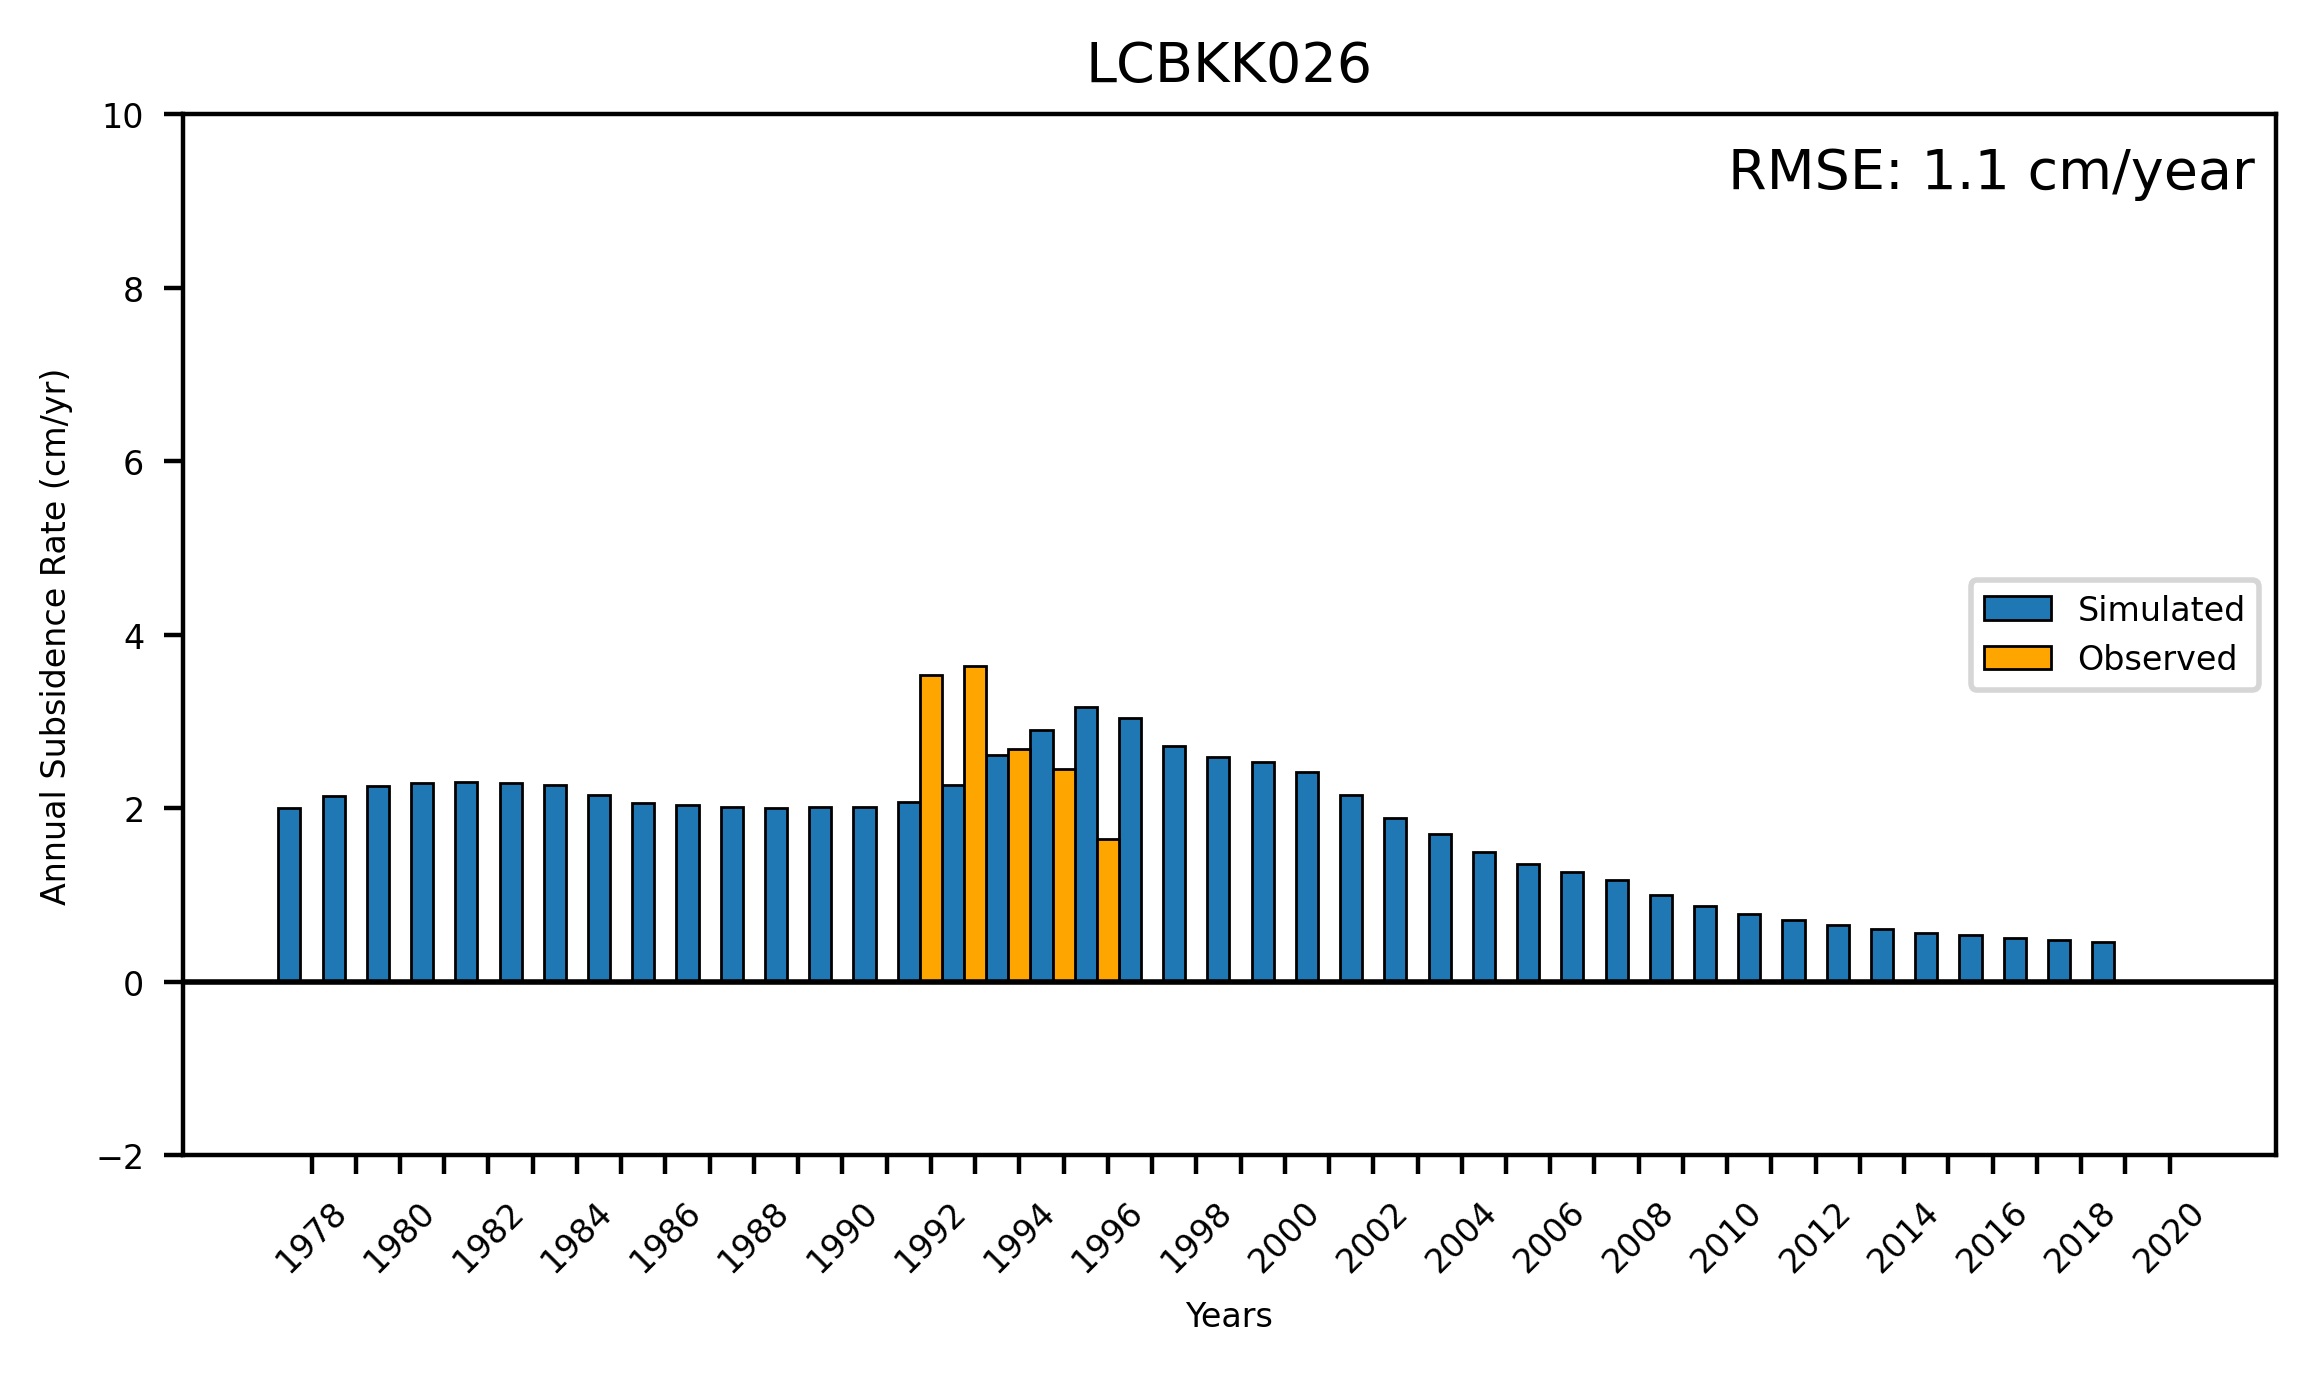

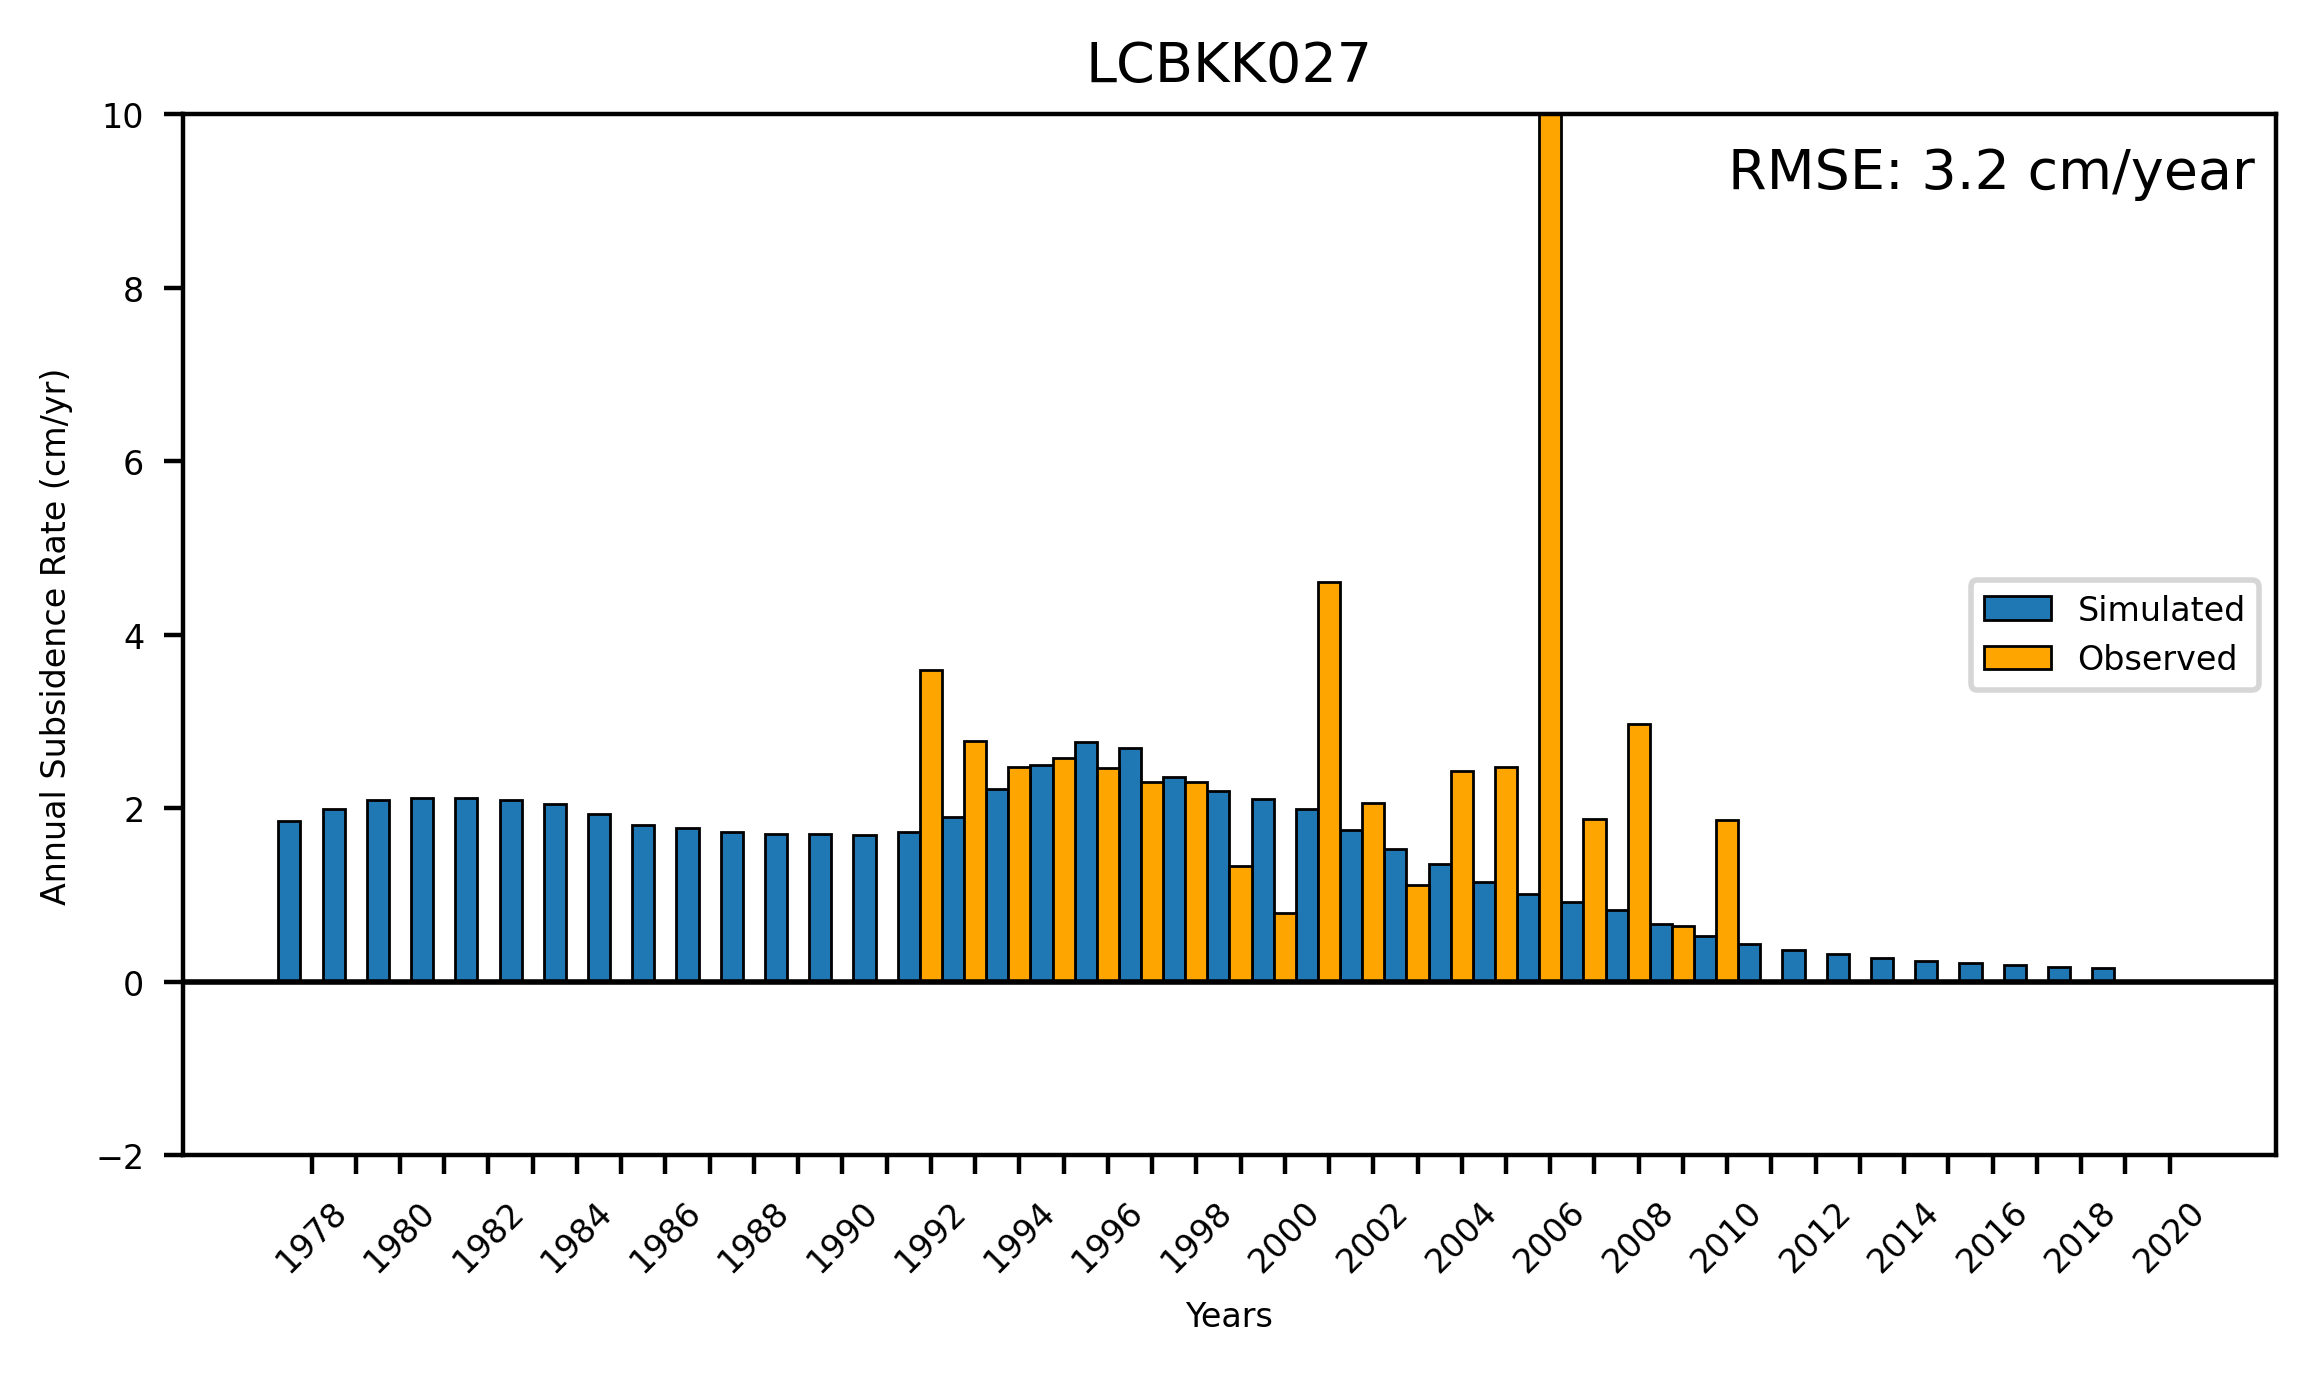

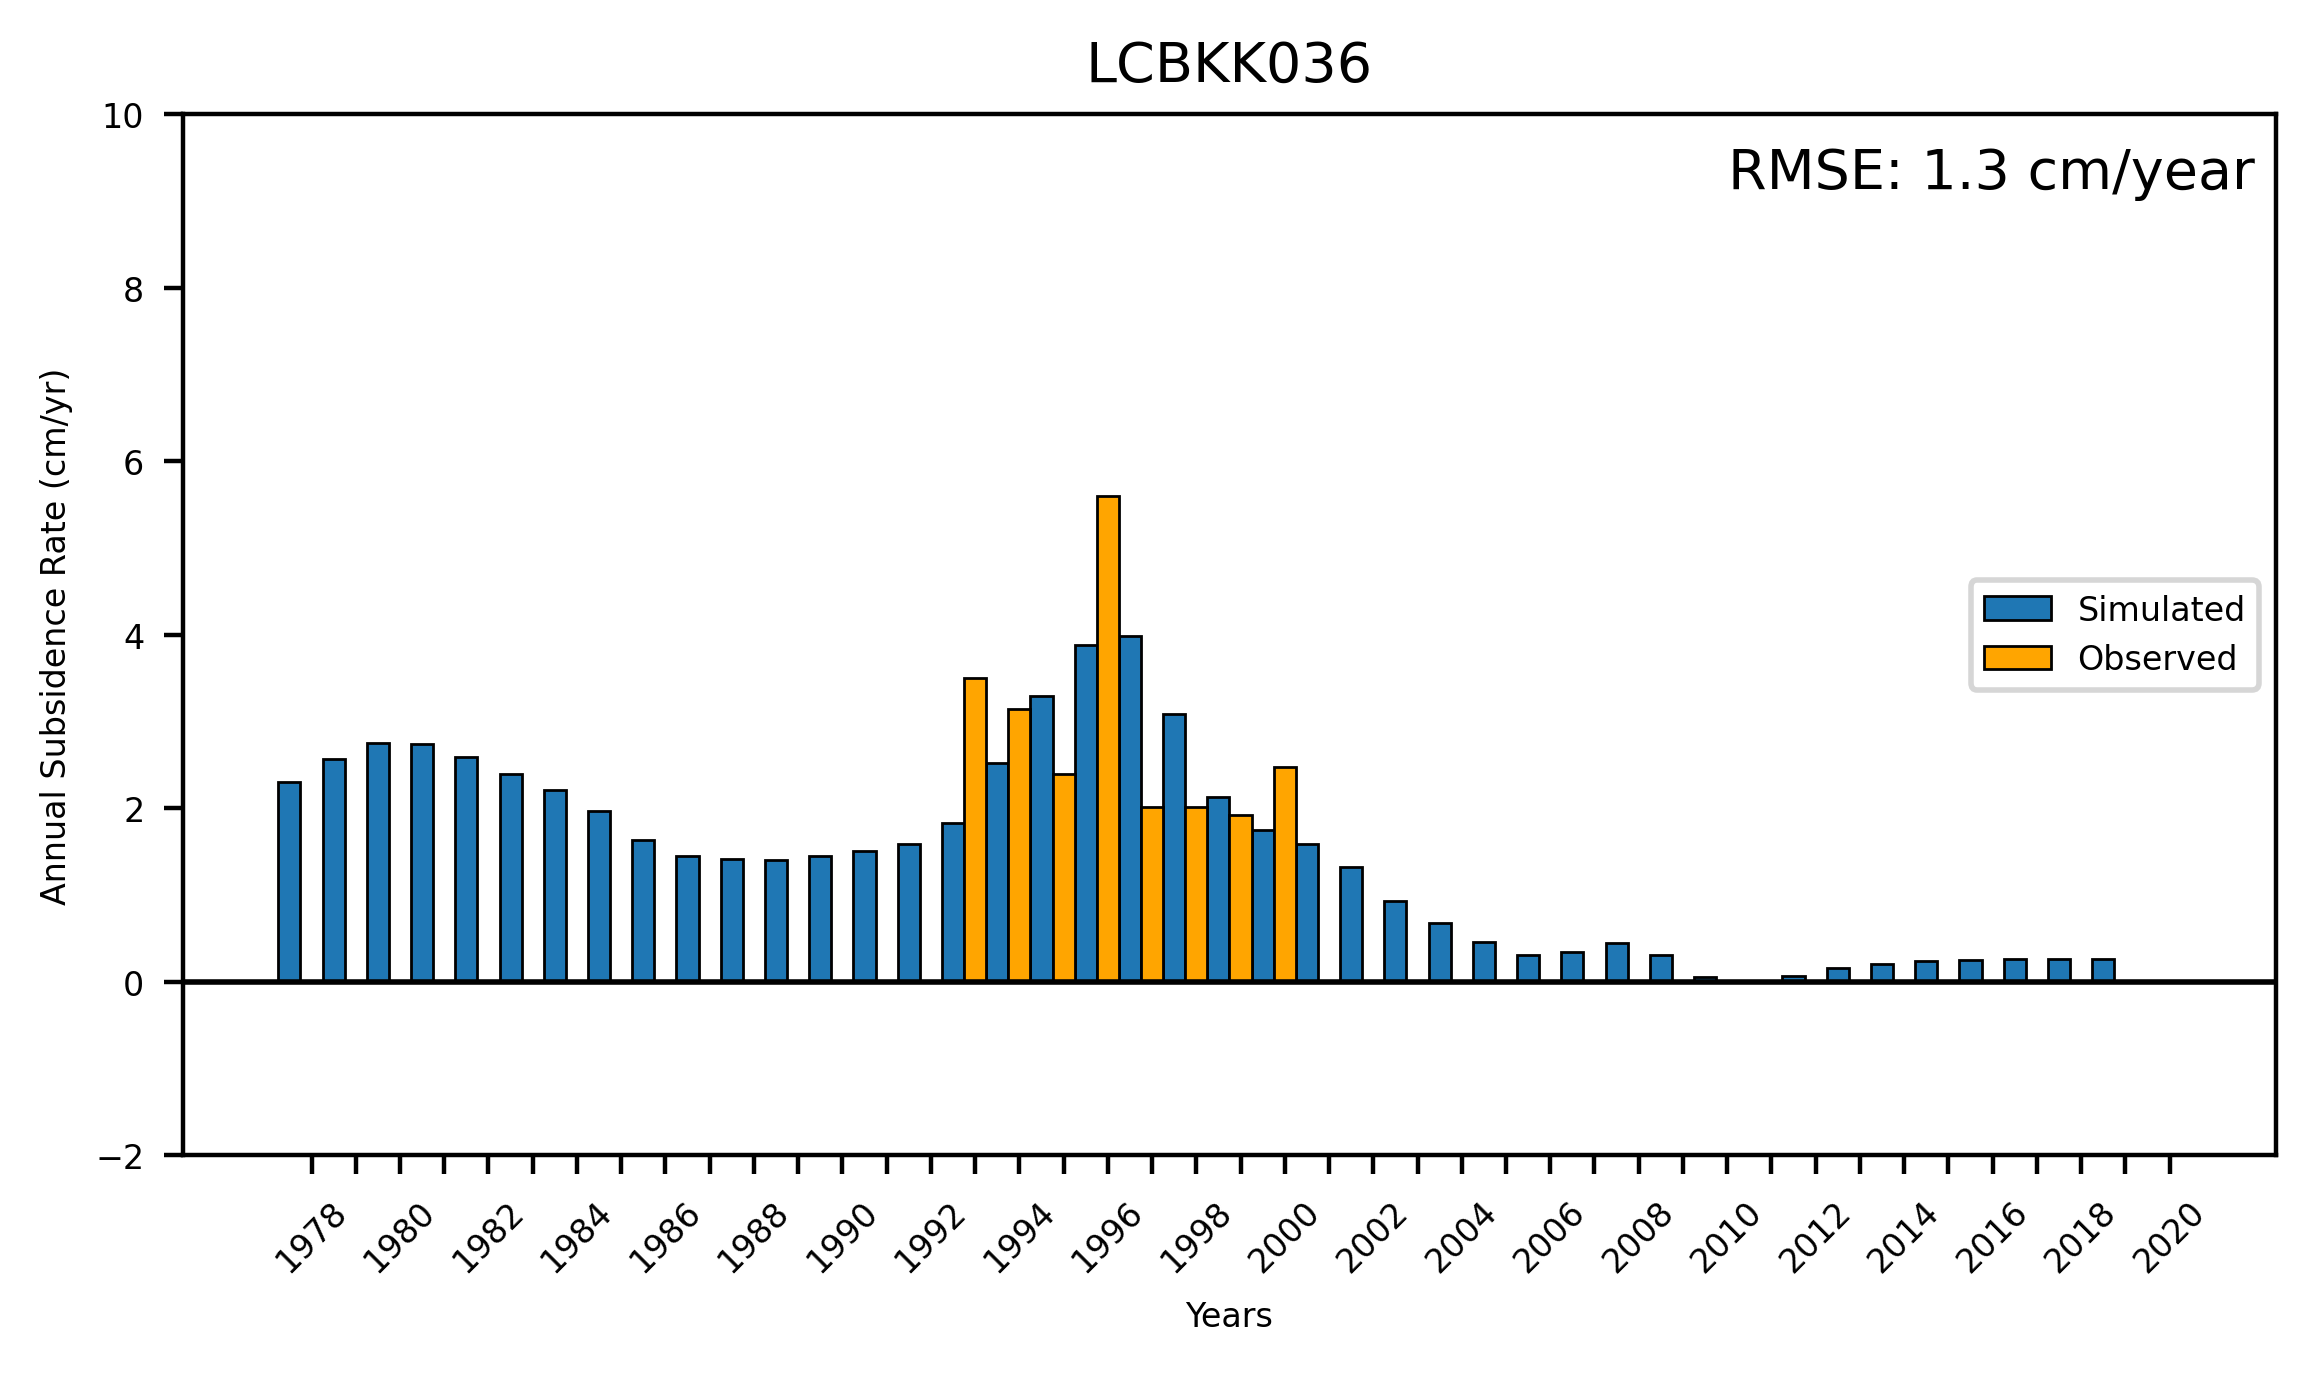

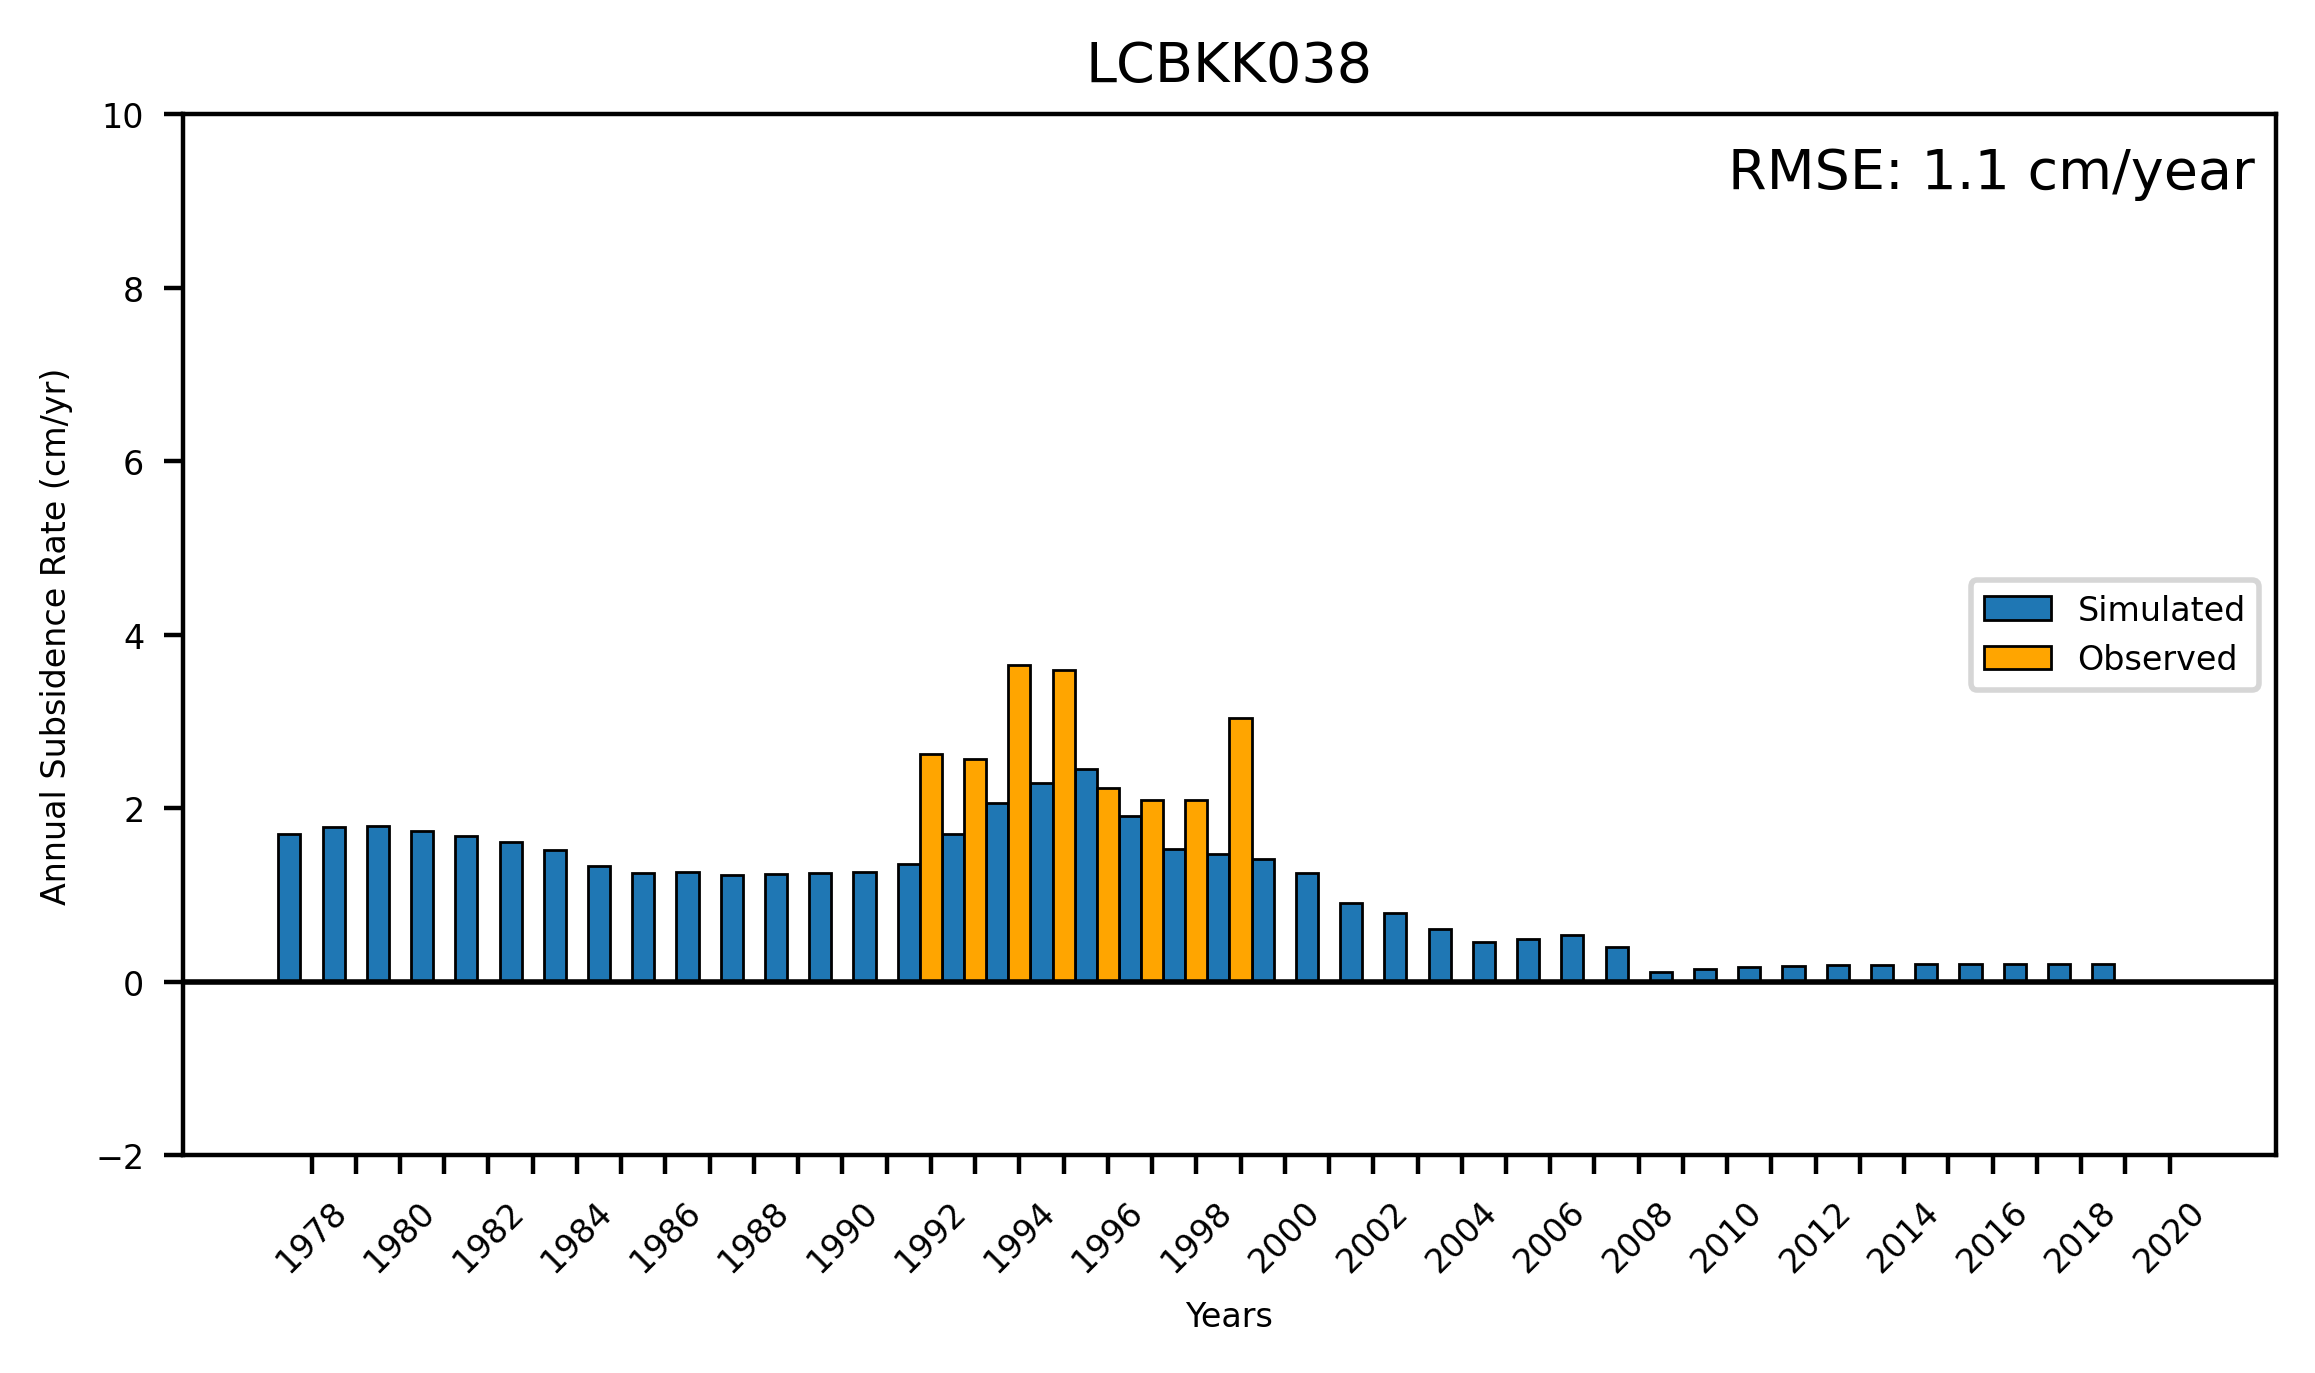

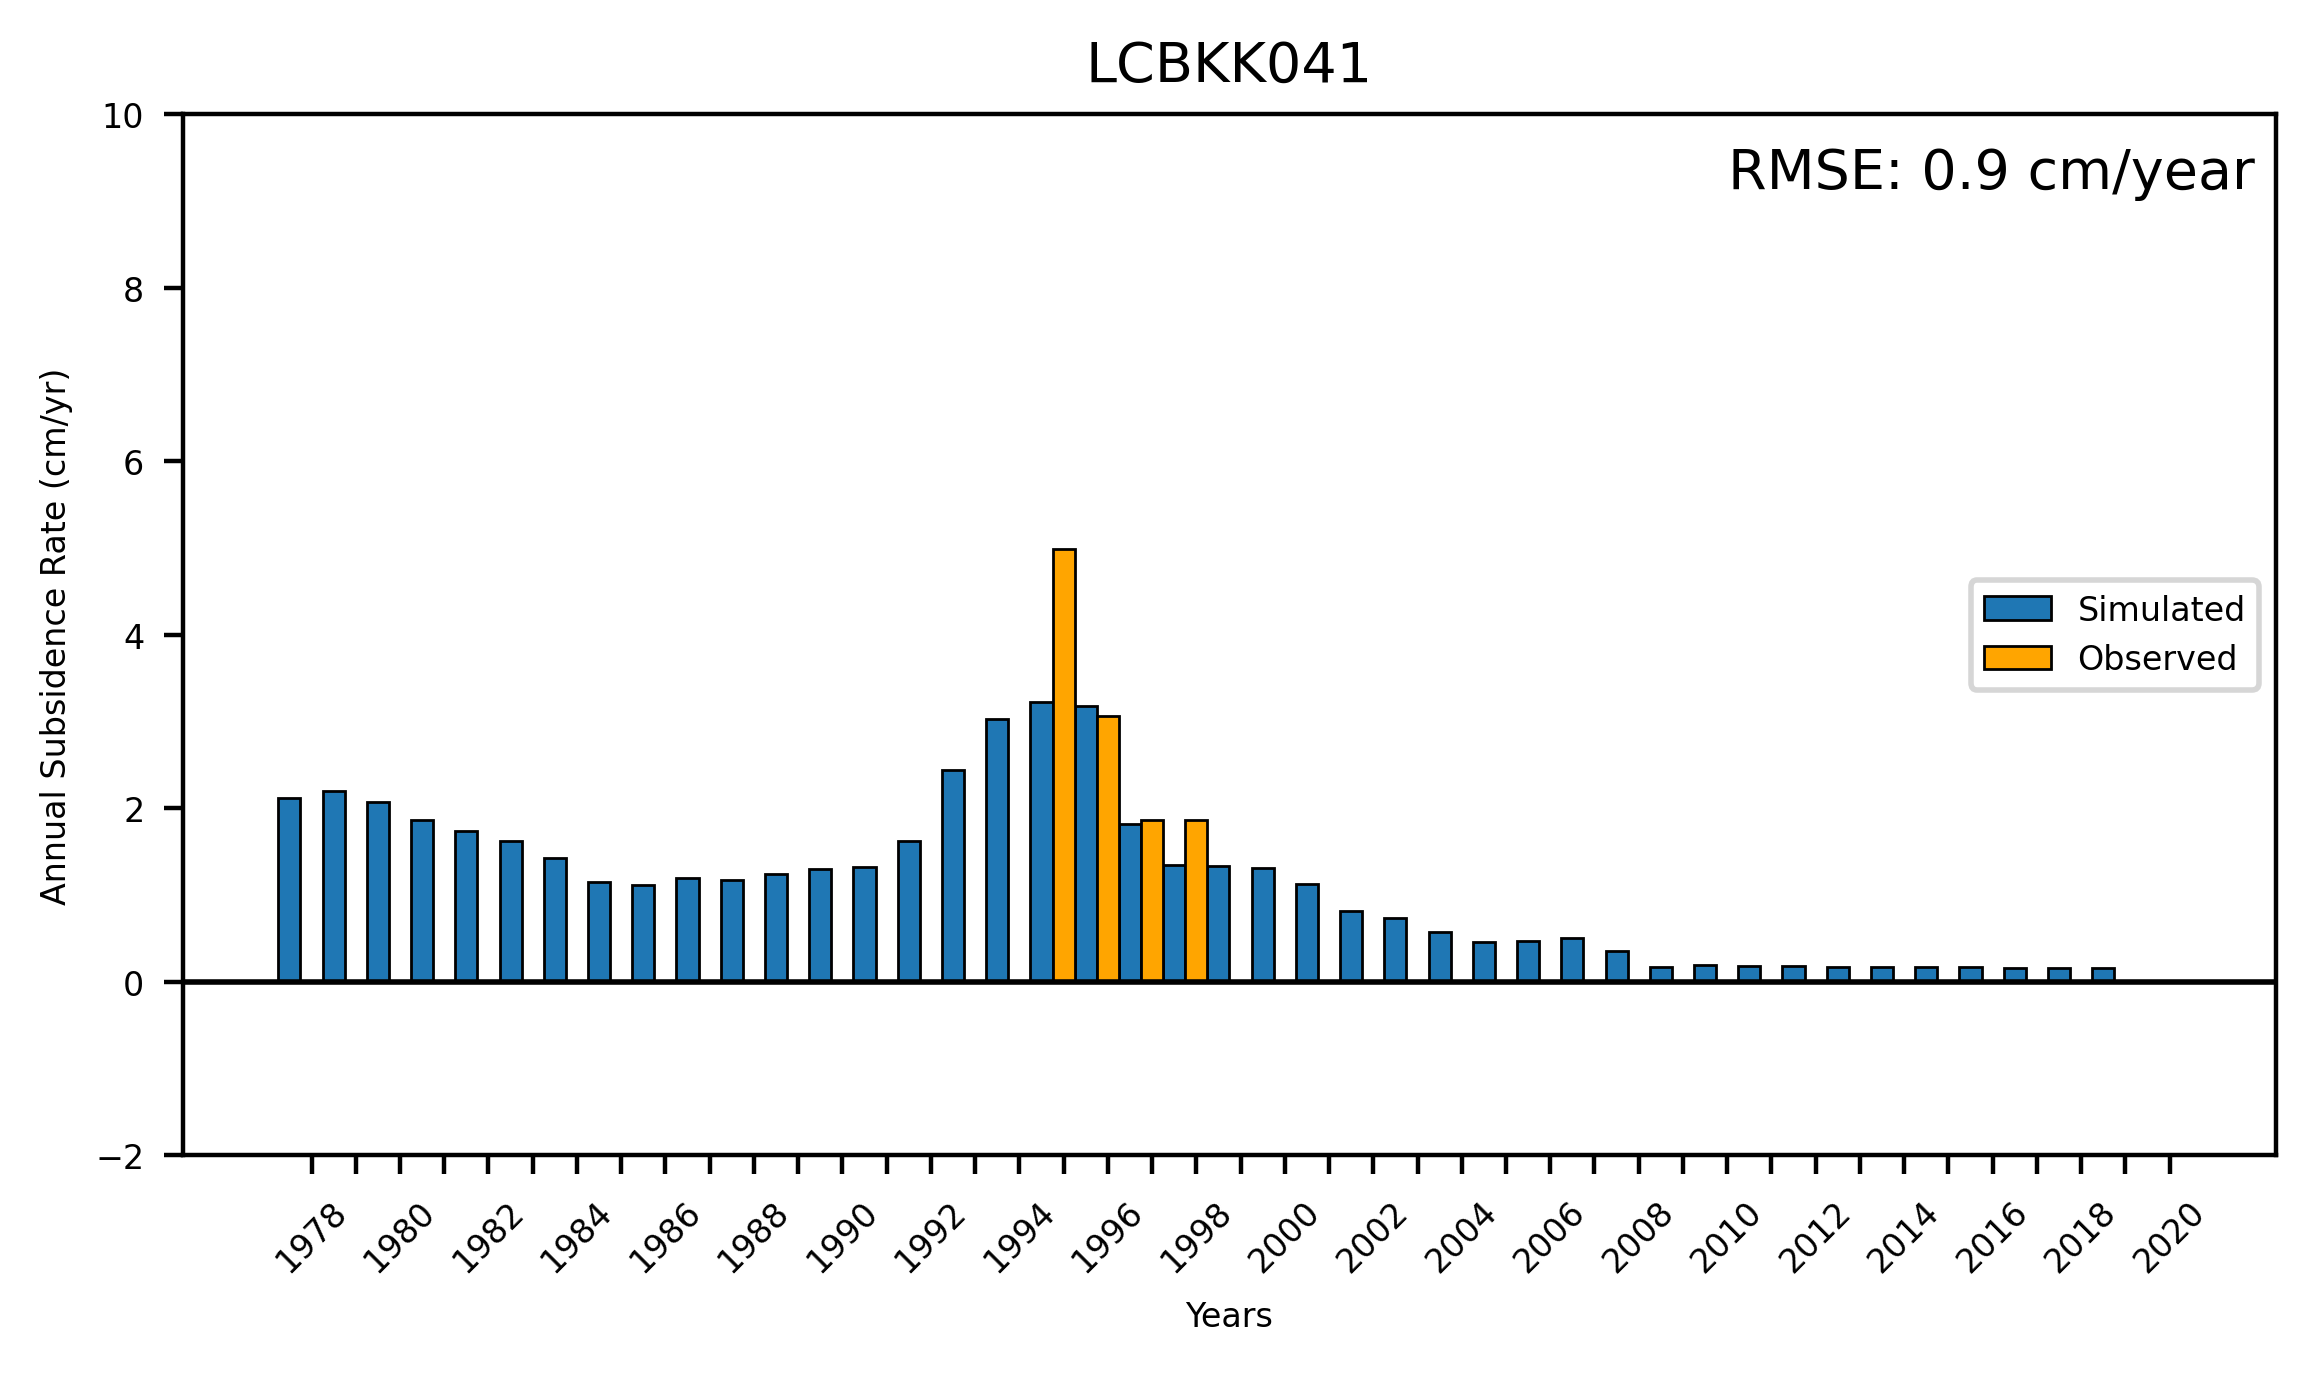

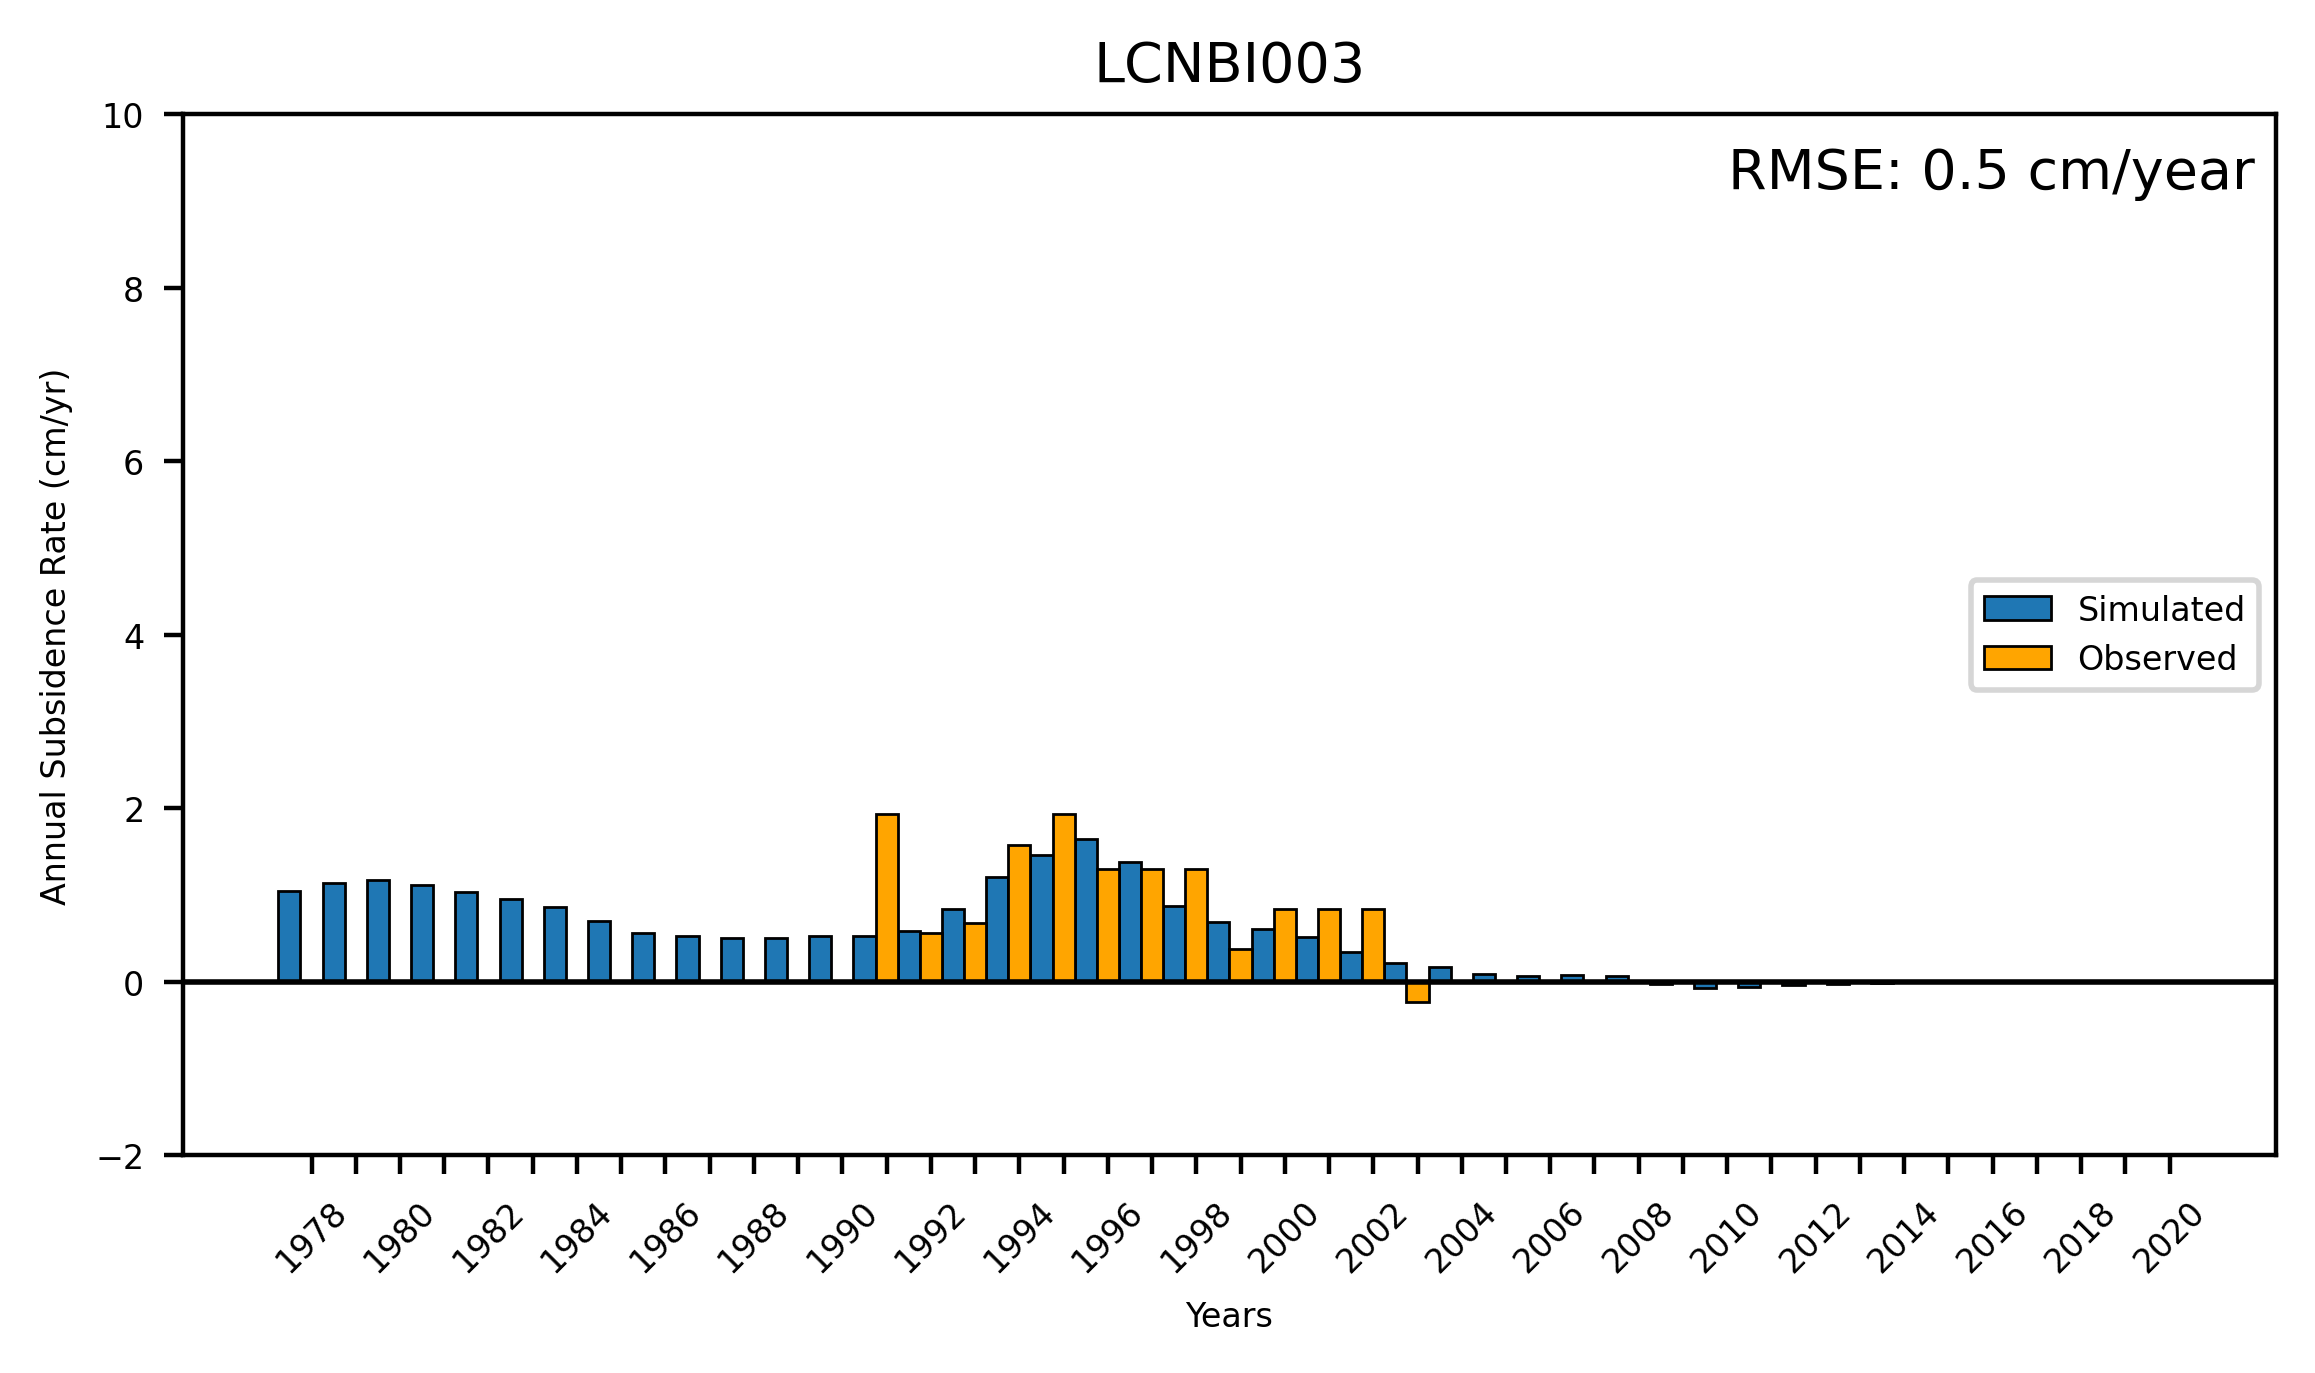

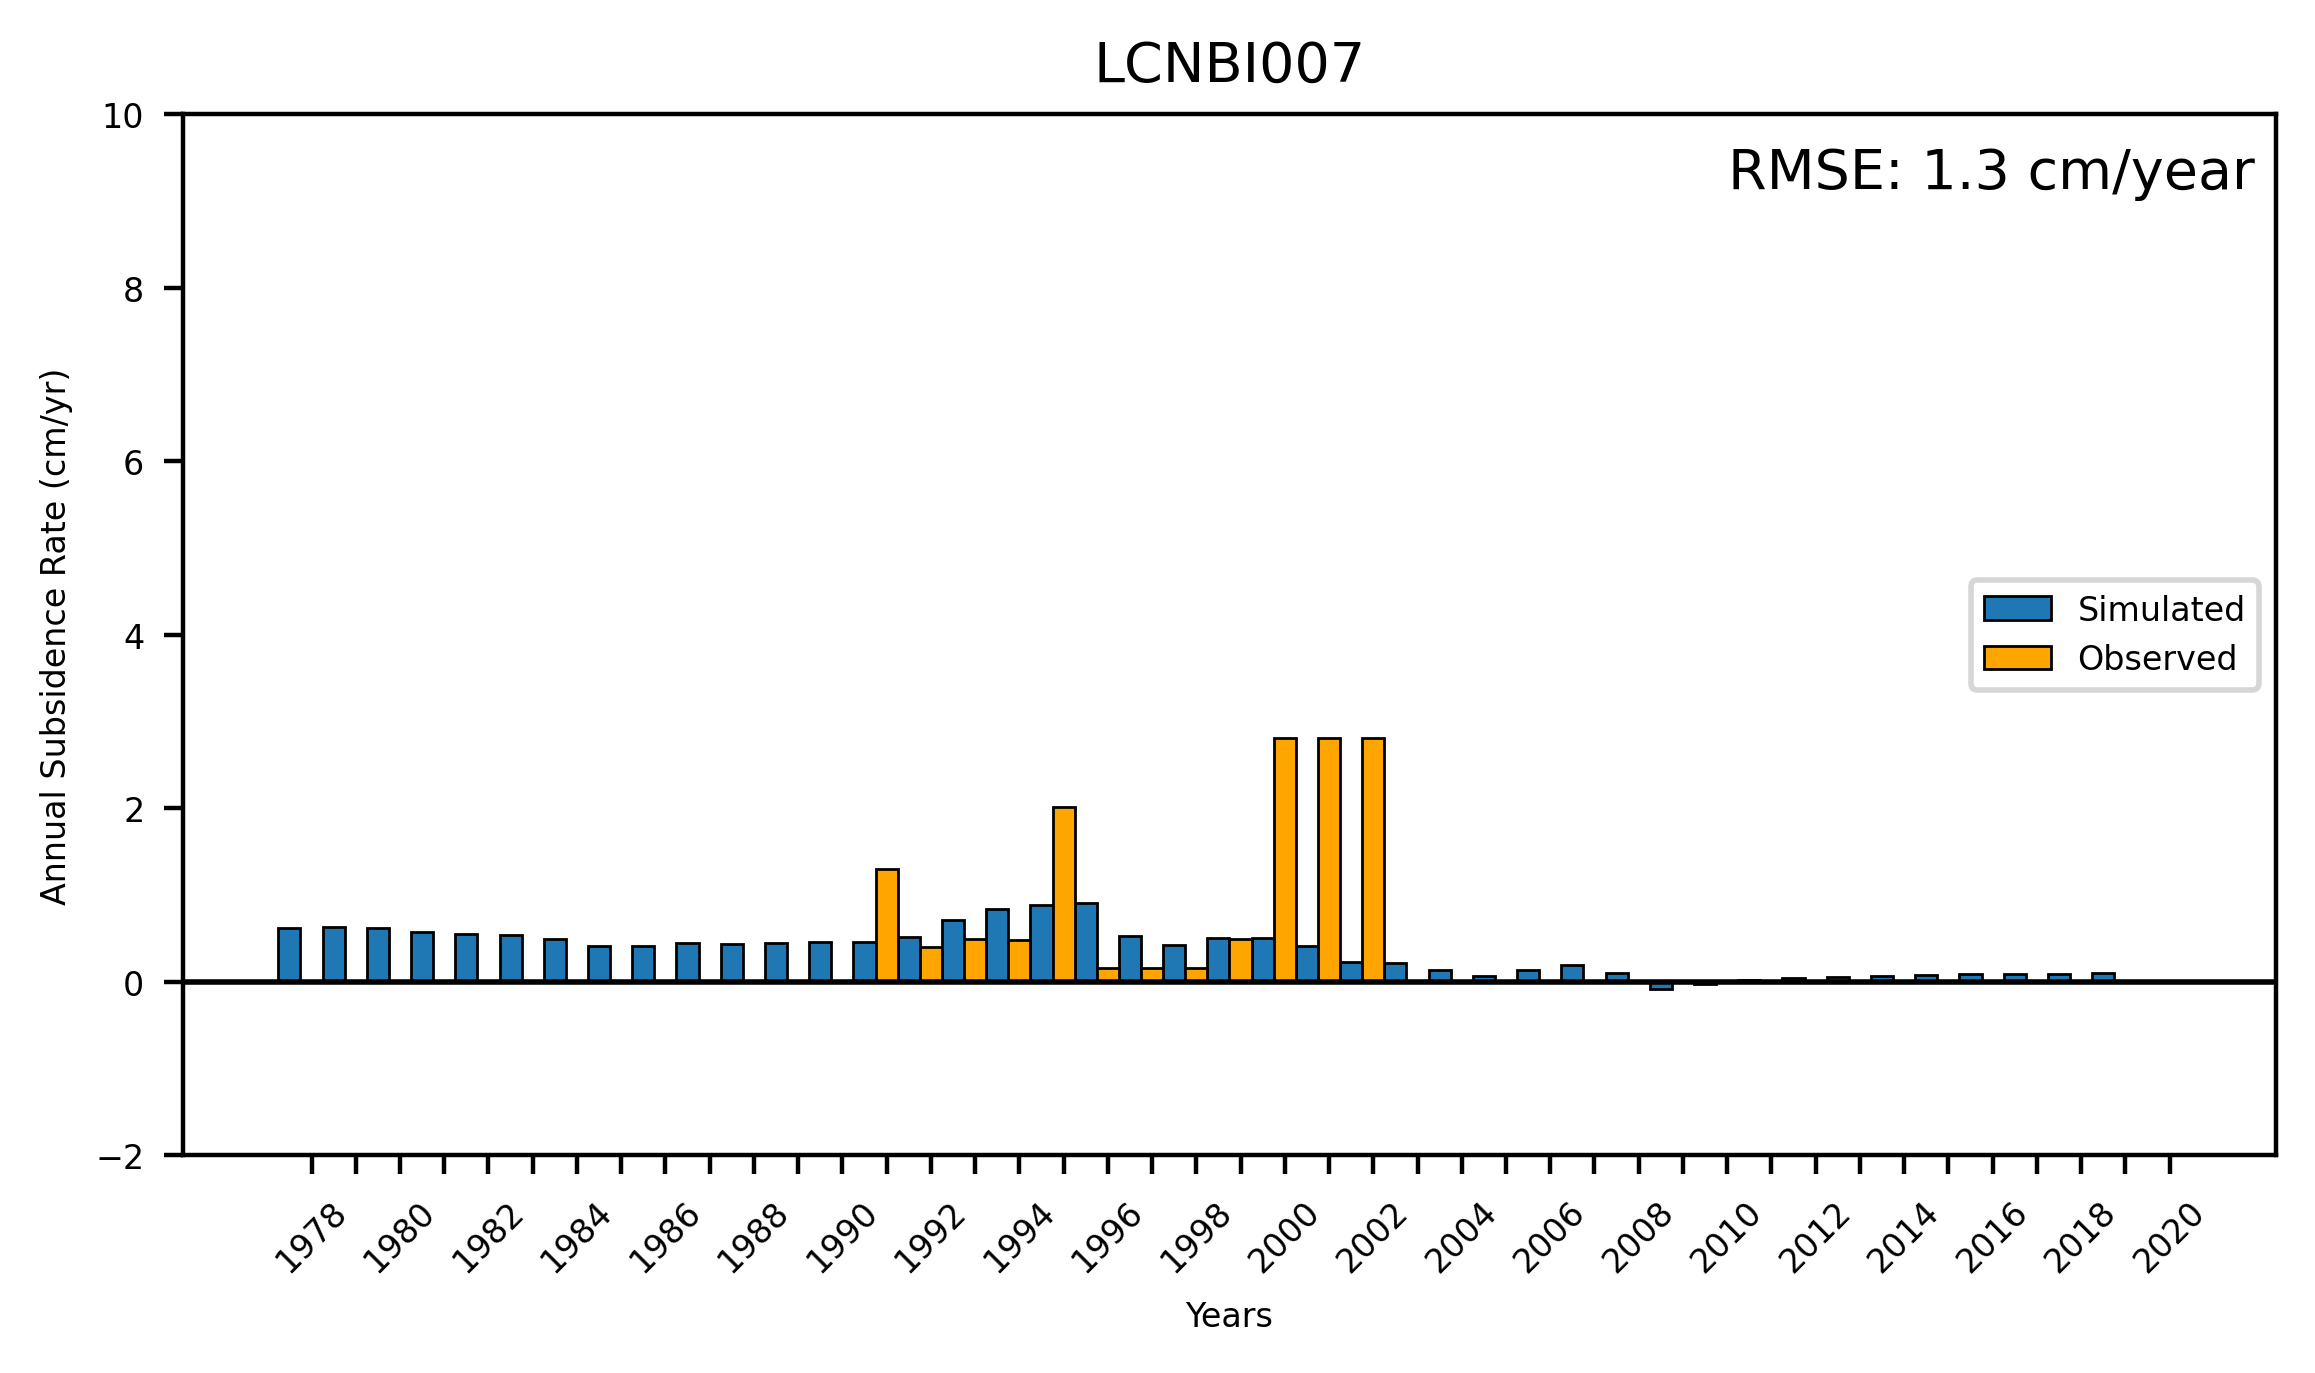

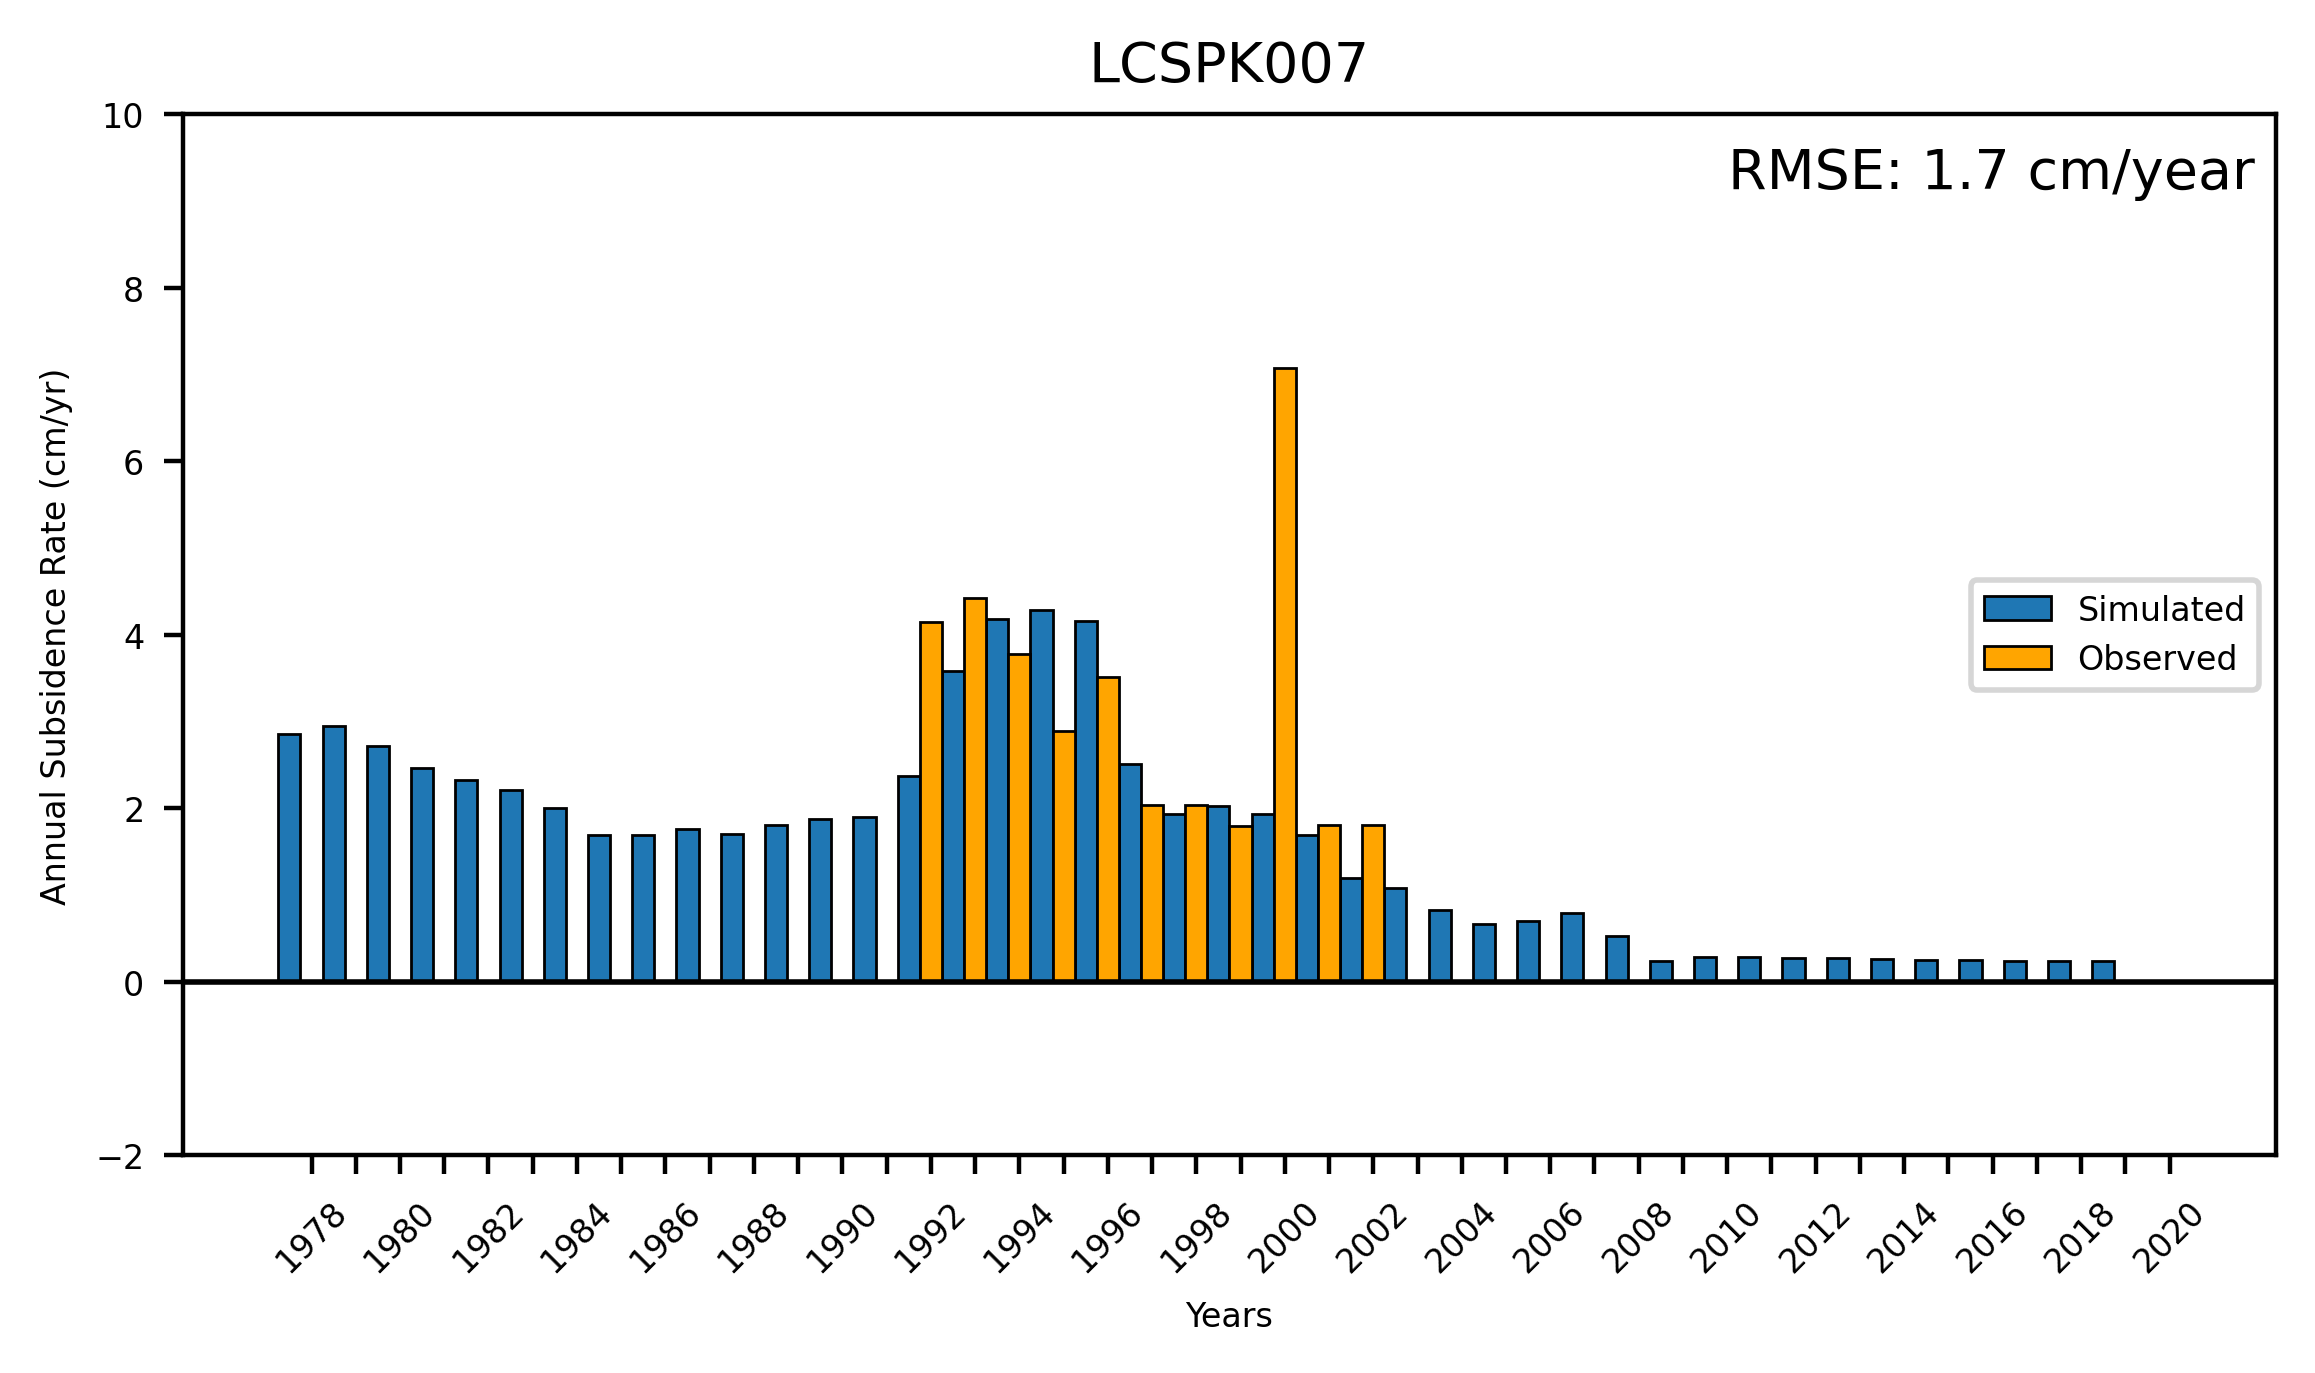

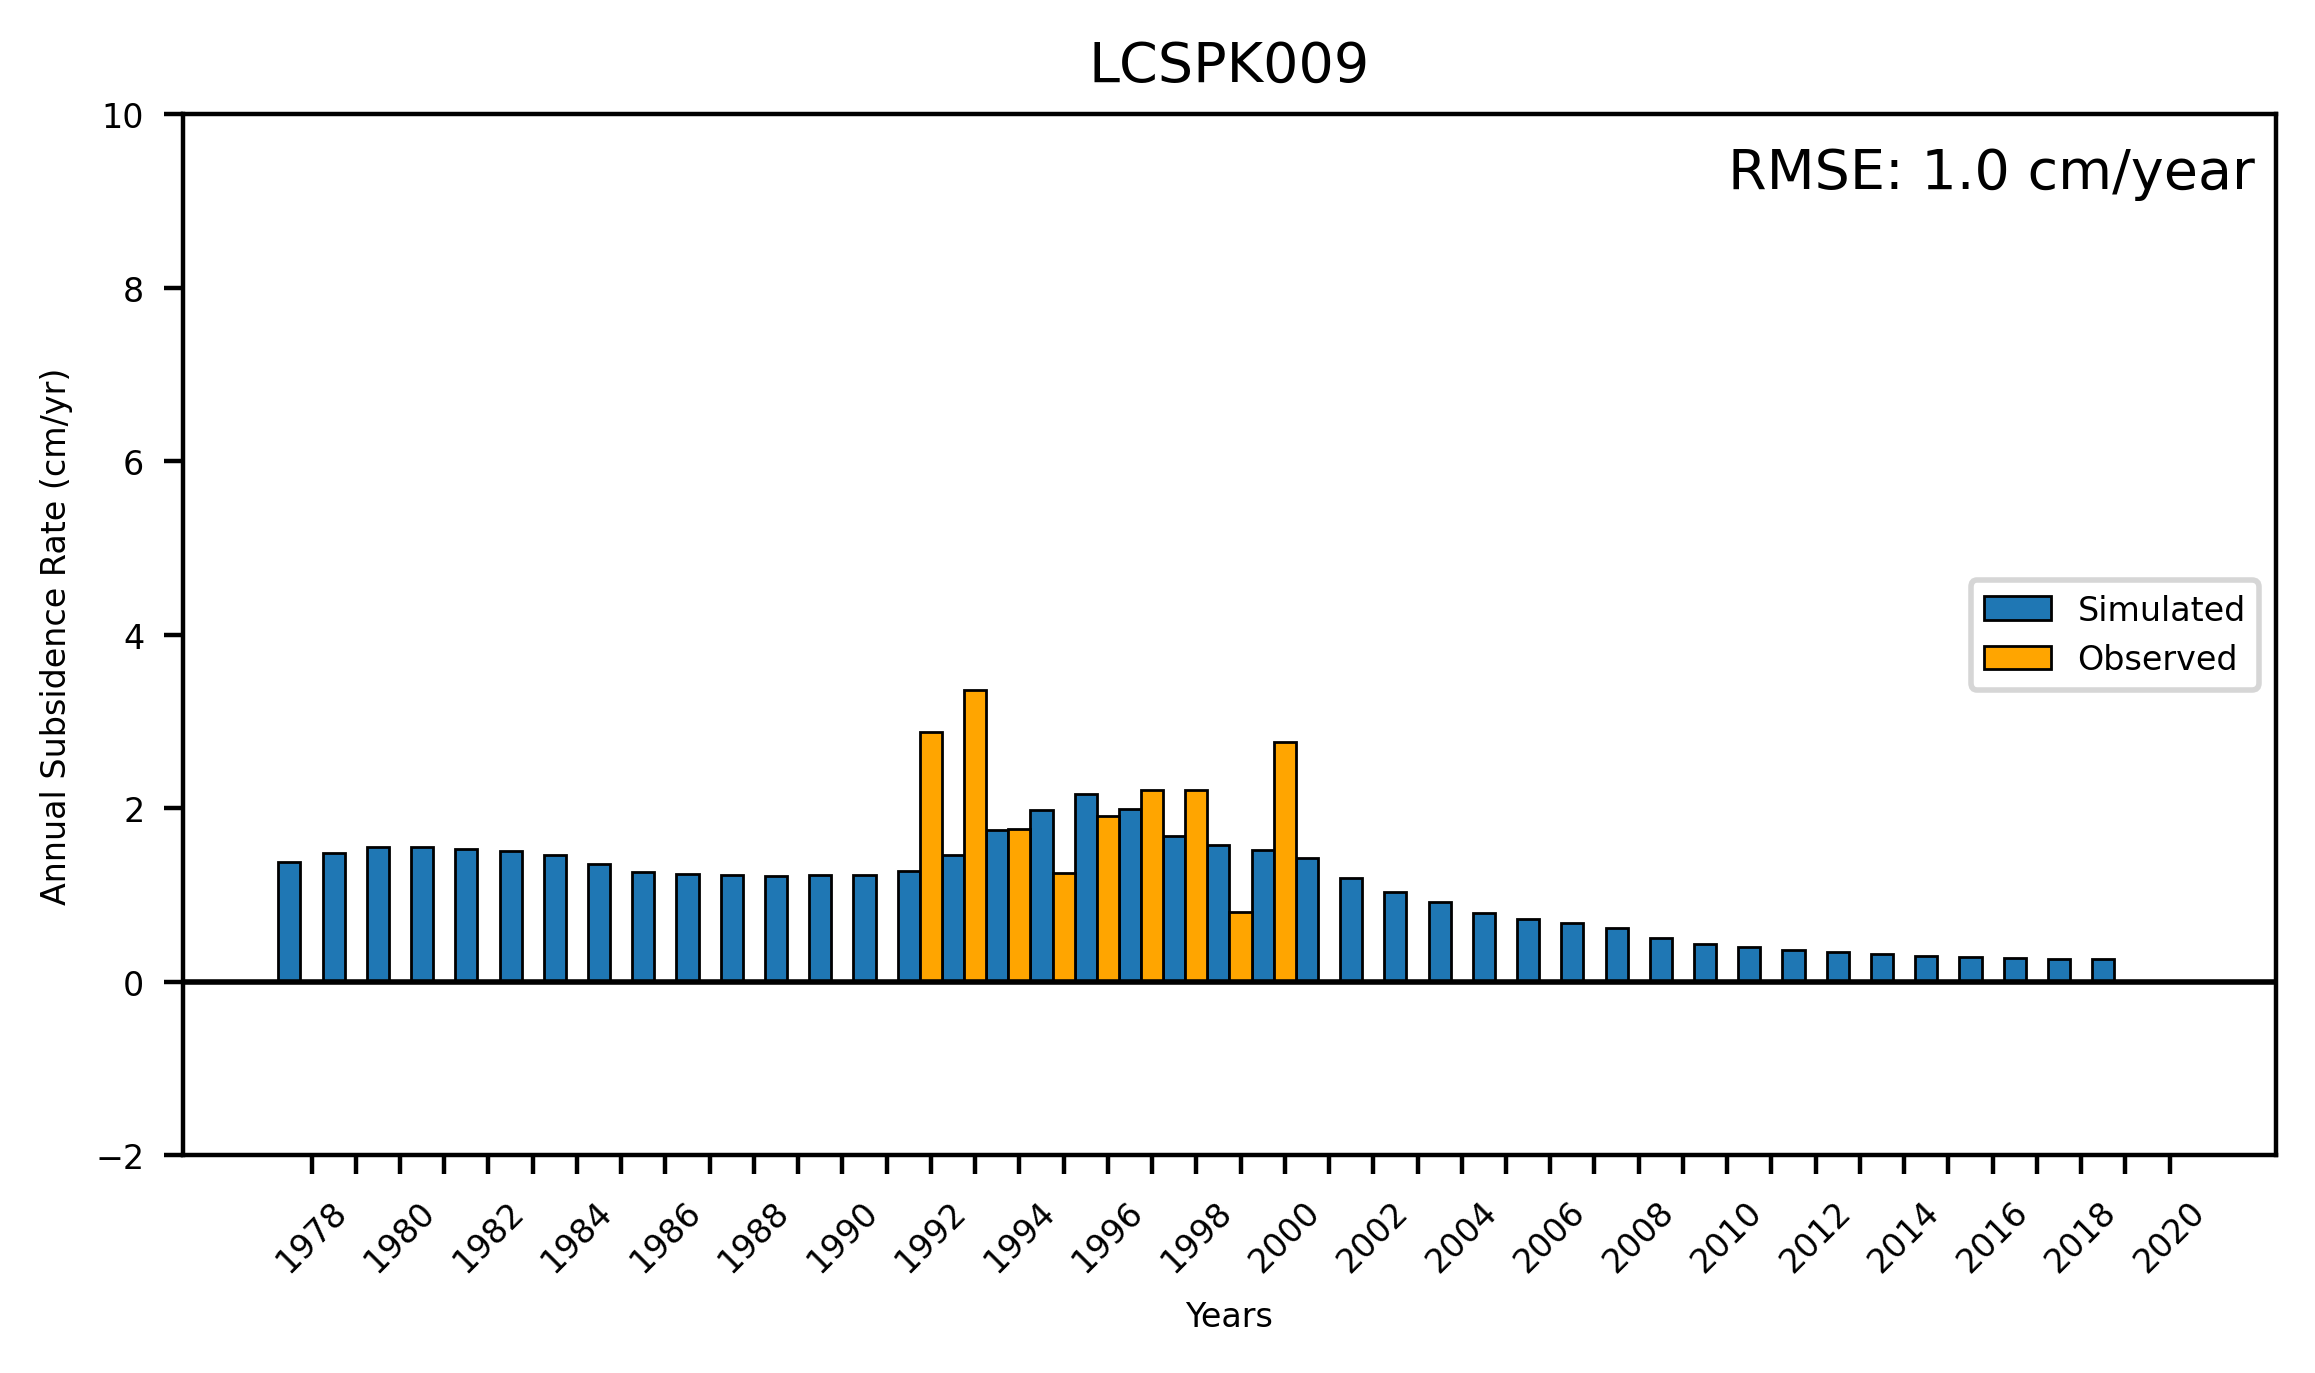

In [5]:
bkk_sub_gw.bkk_plotting.sub_bar(path, model_sub["wellnestlist"],
                                model_sub["all_results"],
                                model_sub["sub_total"],
                                model_sub["subv_total"],
                                model_sub["ann_sub"],
                                tmin=model_sub["tmin"],
                                tmax=model_sub["tmax"], save=0,
                                benchflag=1)

## Plots Results: Subsidence RMSE spatial map
Figure 11 in main paper

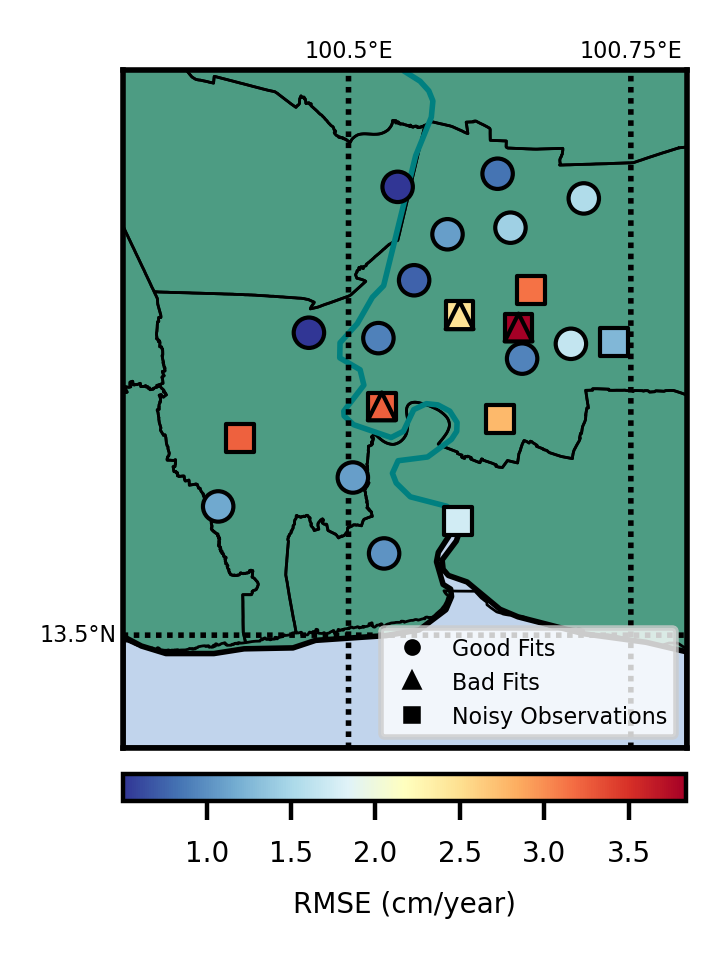

Avg: 1.62 cm/yr
Max: 3.84 cm/yr


In [6]:
bkk_sub_gw.bkk_plotting.sub_rmse_map(path, model_sub["wellnestlist"],
                                     model_sub["all_results"],
                                     model_sub["sub_total"],
                                     model_sub["subv_total"],
                                     model_sub["ann_sub"],
                                     tmin=model_sub["tmin"],
                                     tmax=model_sub["tmax"], save=0)

## Plots Results: Forecasts of cumulative subsidence (cm) for pumping scenarios
Supplemental Information 1.5

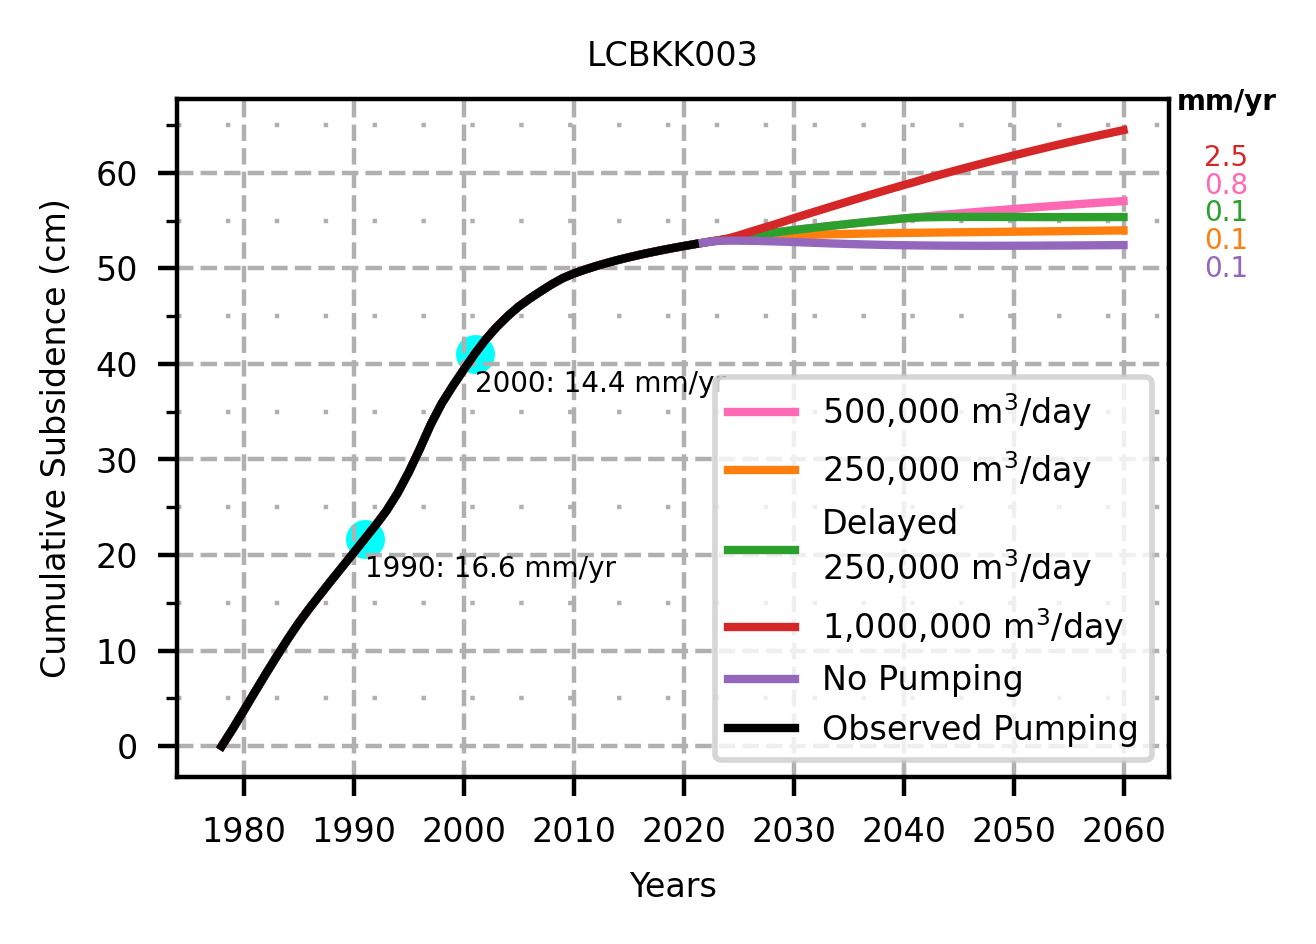

<Figure size 640x480 with 0 Axes>

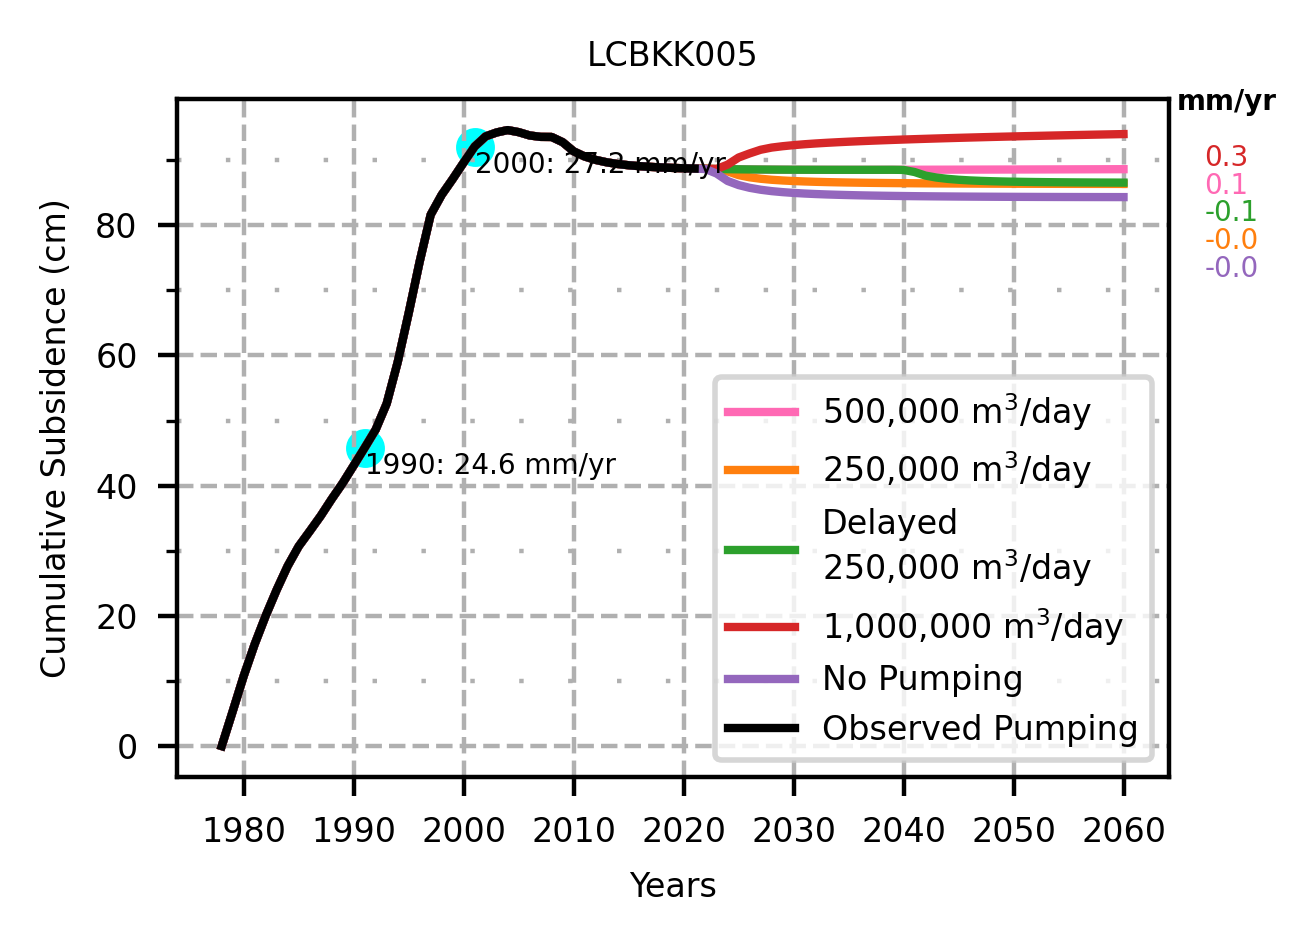

<Figure size 640x480 with 0 Axes>

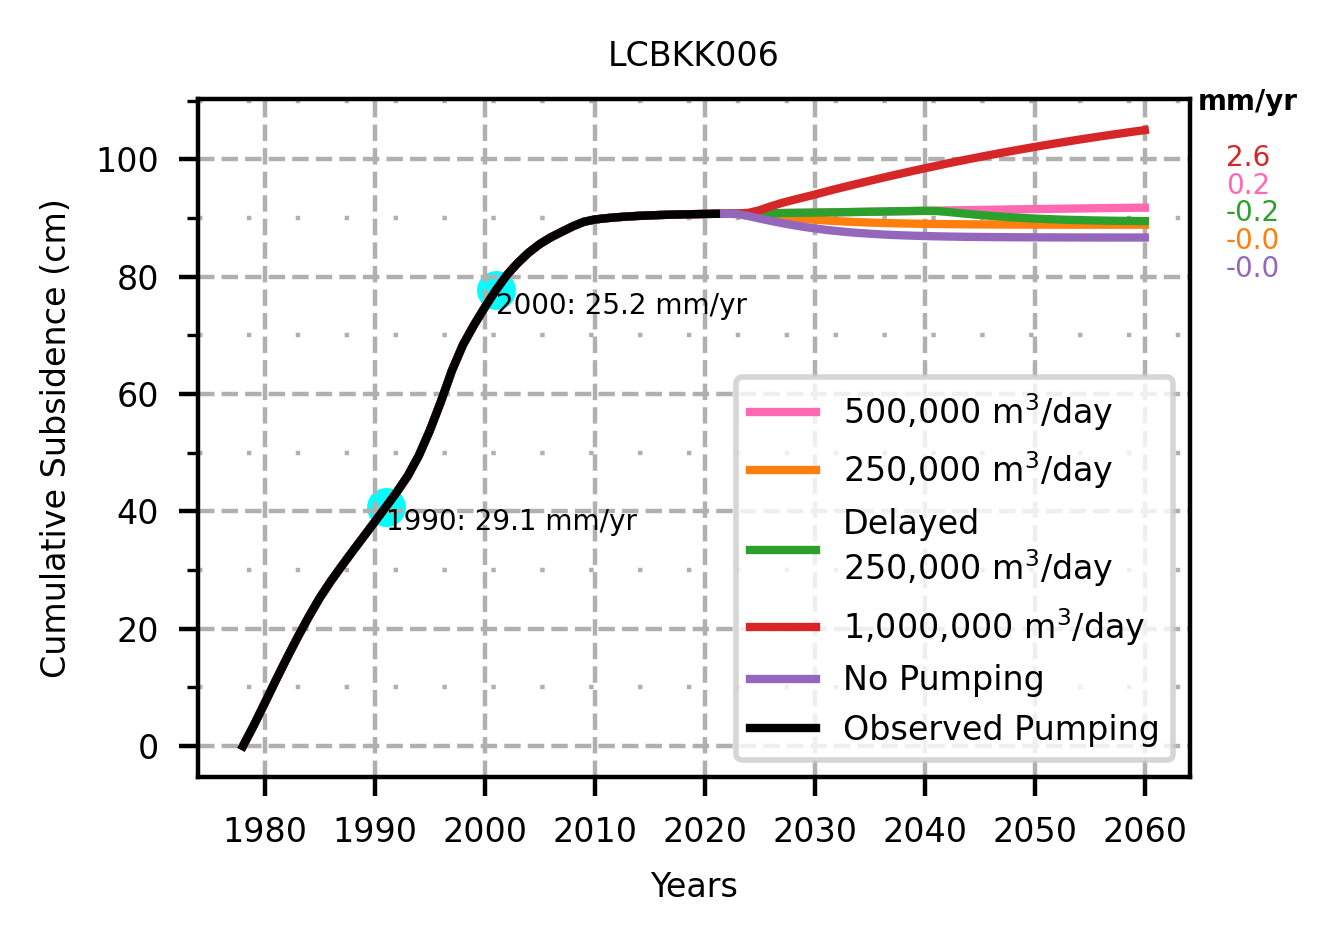

<Figure size 640x480 with 0 Axes>

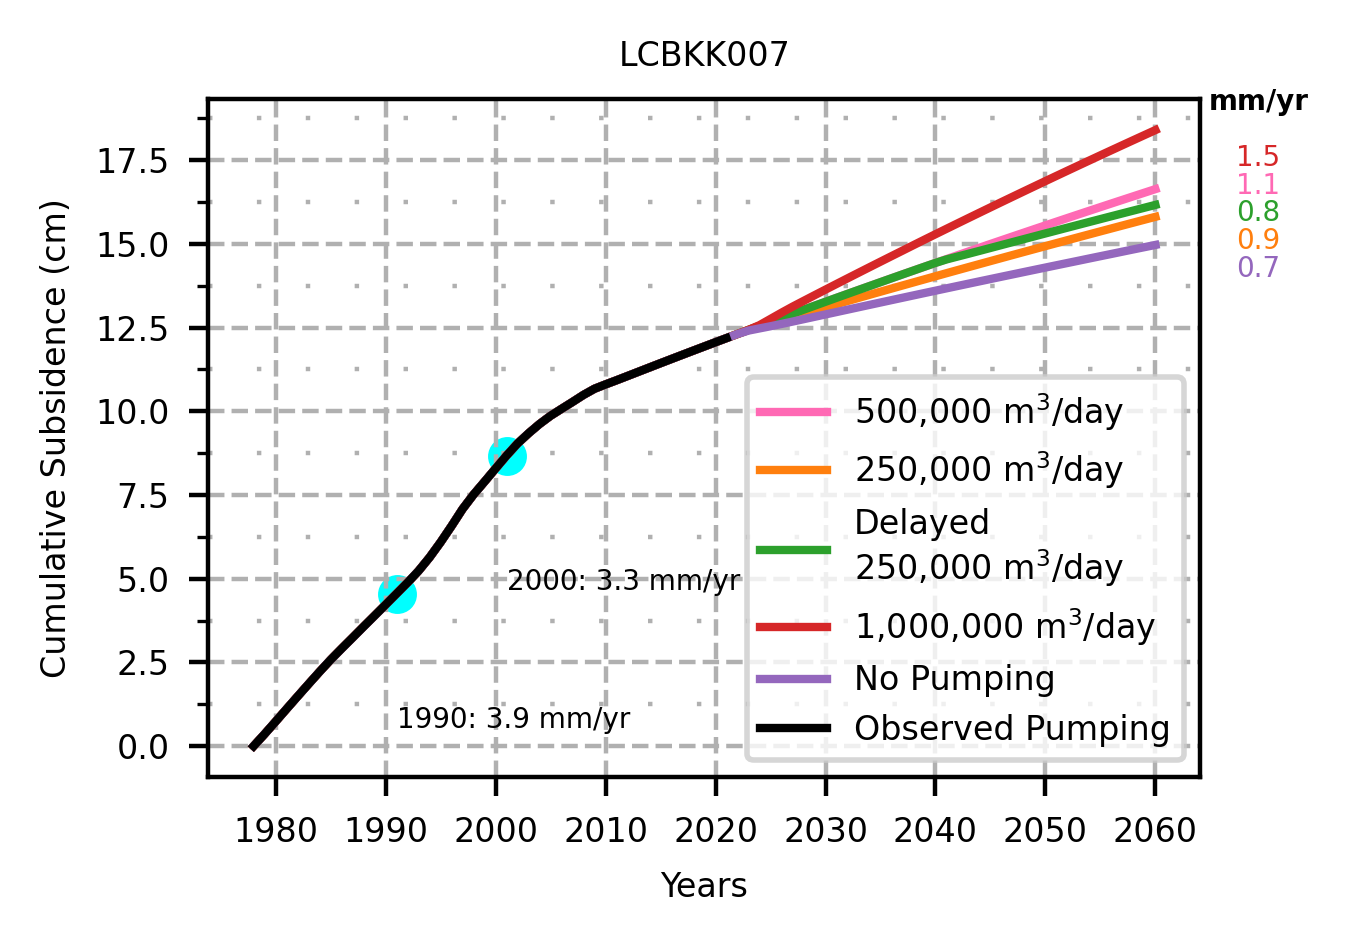

<Figure size 640x480 with 0 Axes>

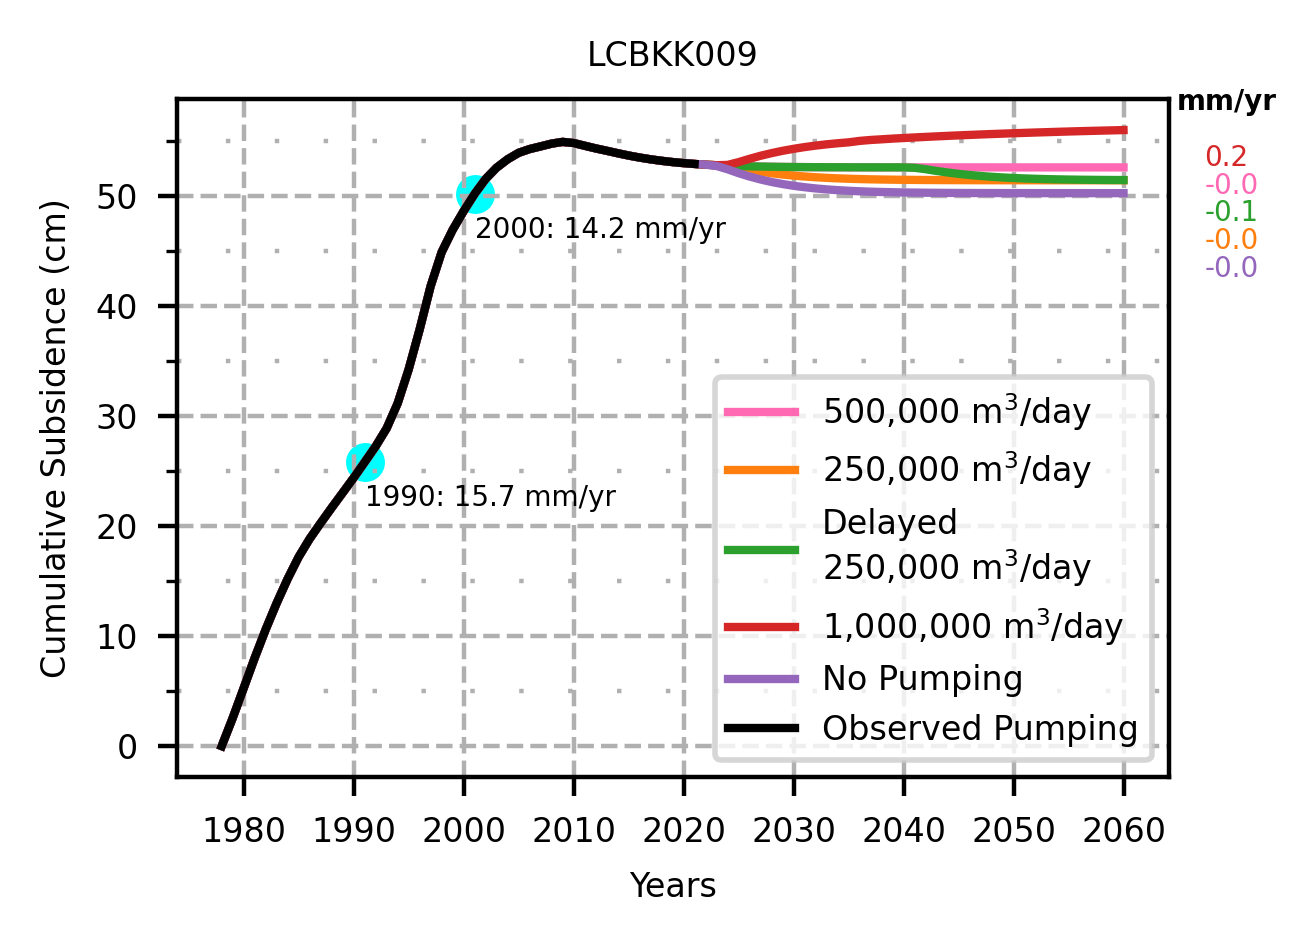

<Figure size 640x480 with 0 Axes>

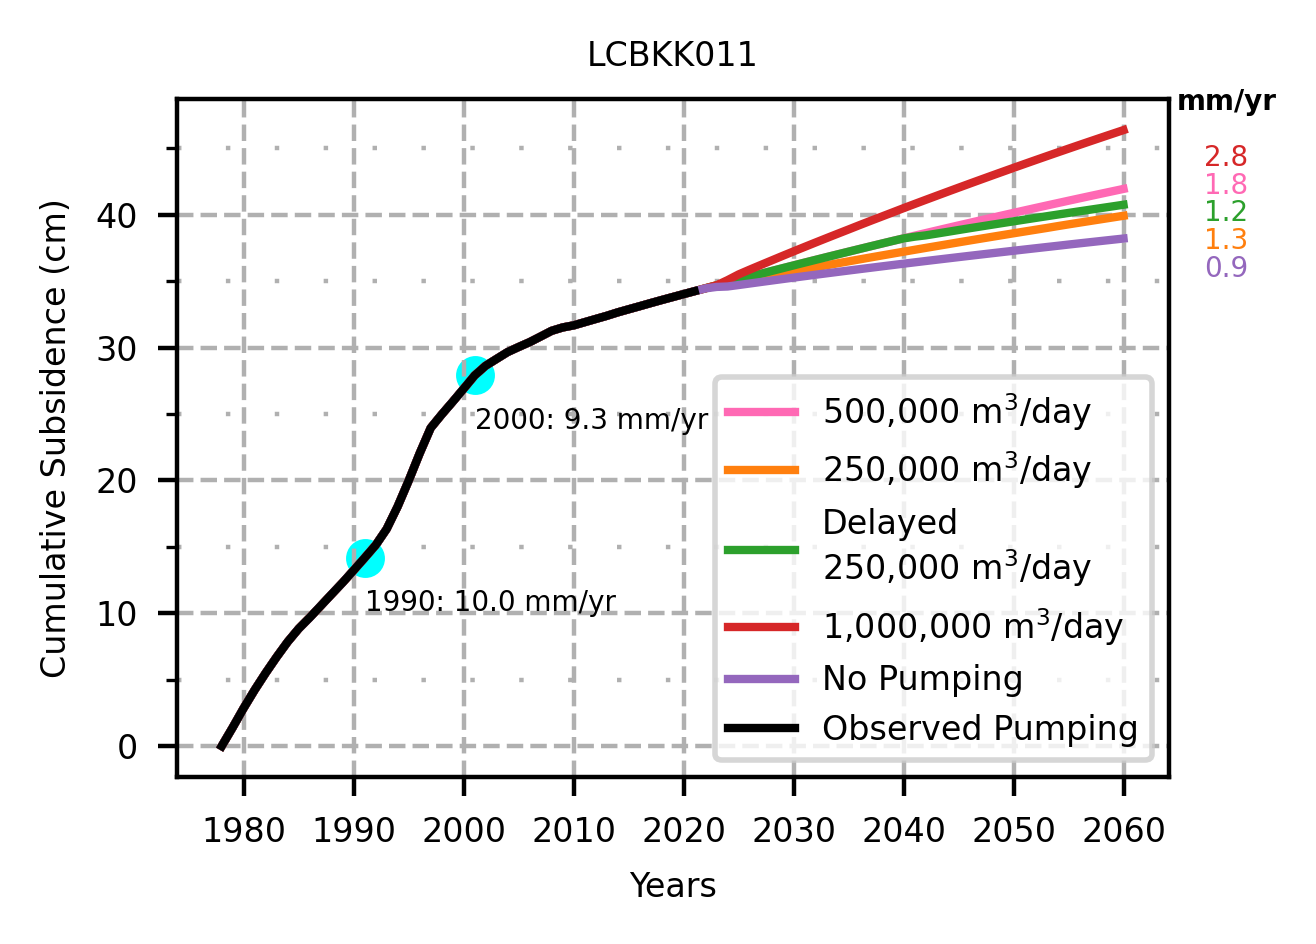

<Figure size 640x480 with 0 Axes>

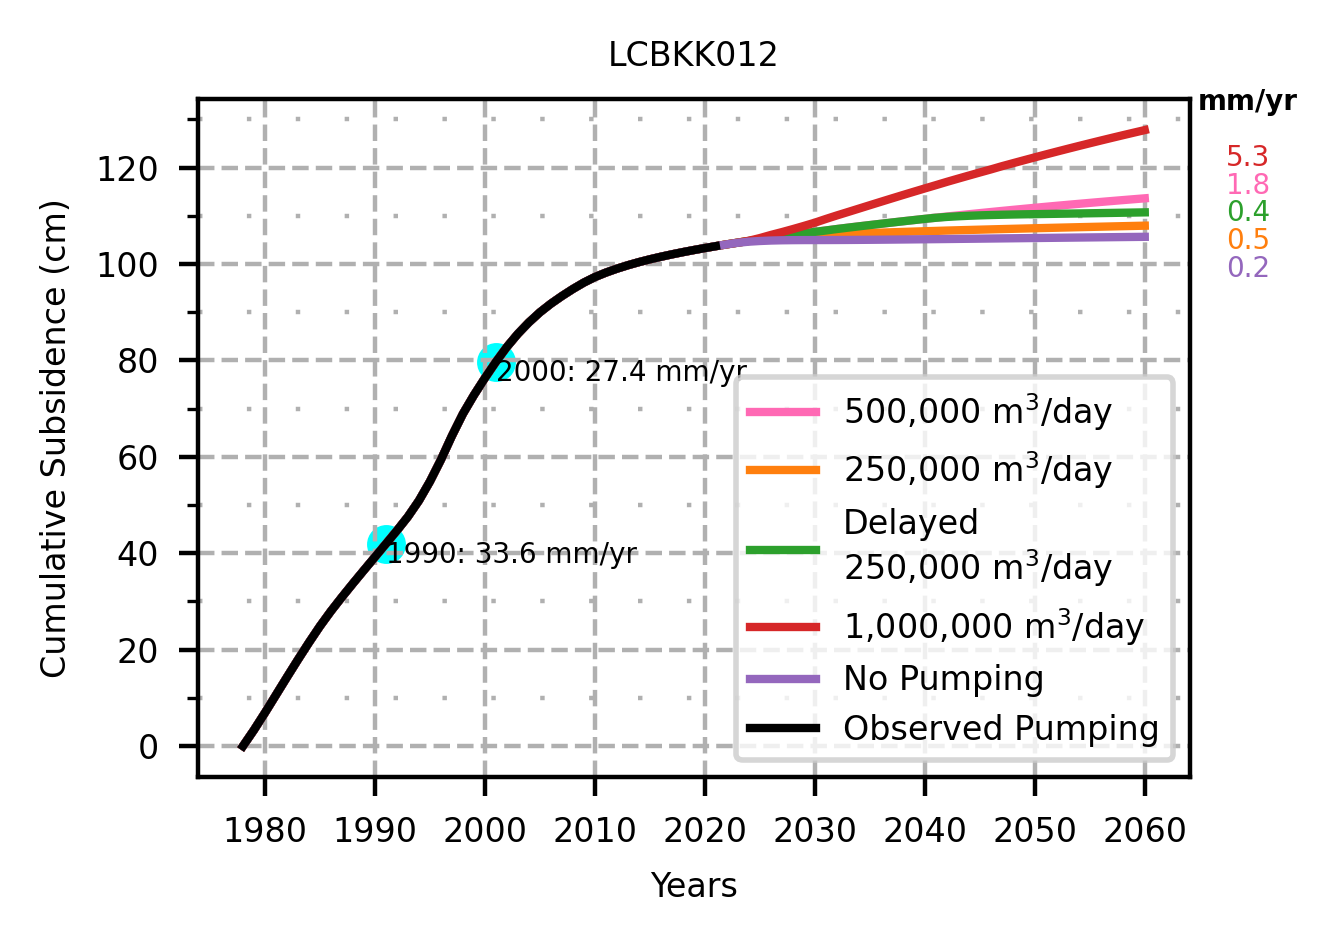

<Figure size 640x480 with 0 Axes>

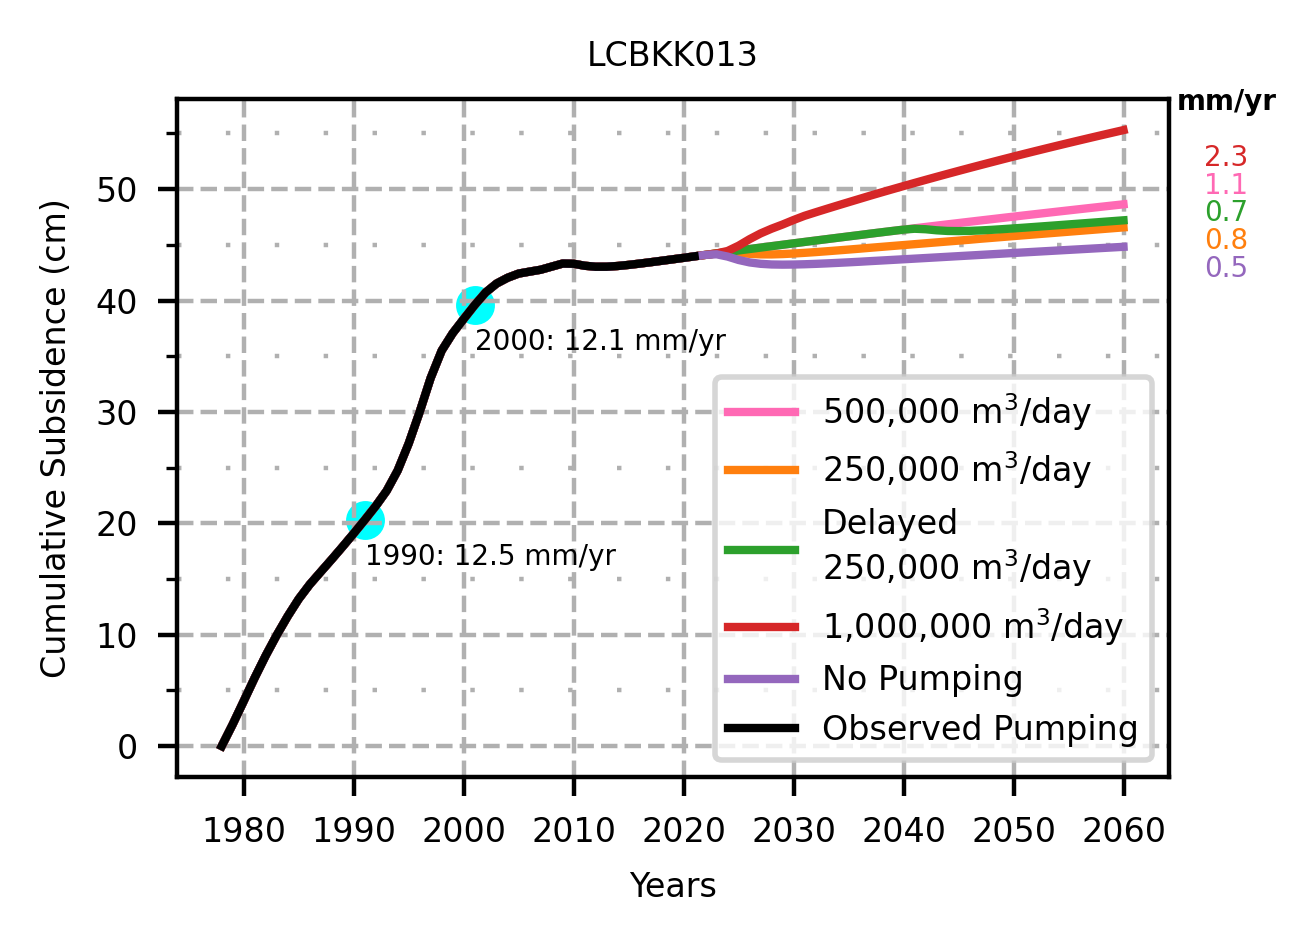

<Figure size 640x480 with 0 Axes>

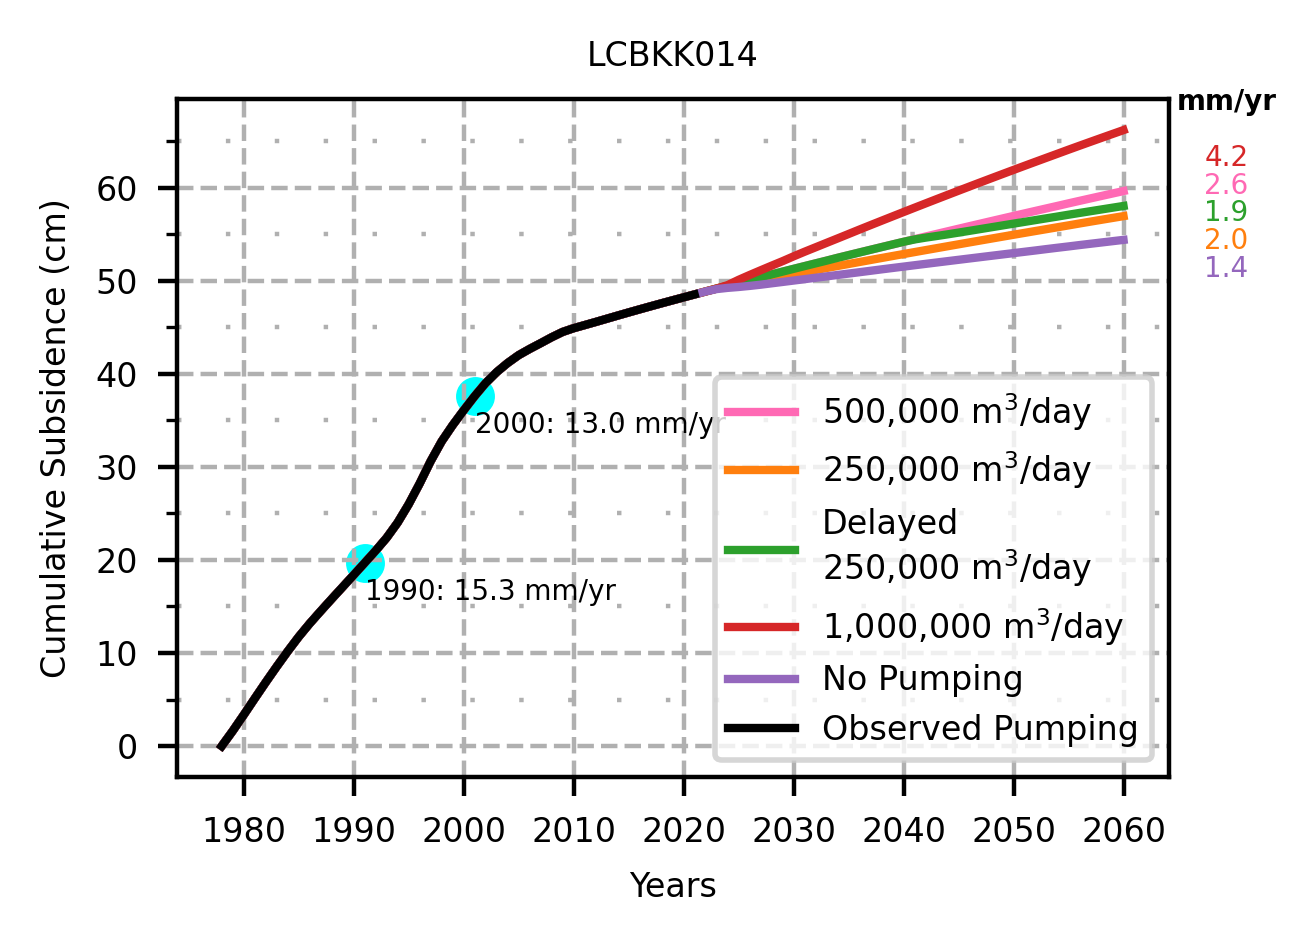

<Figure size 640x480 with 0 Axes>

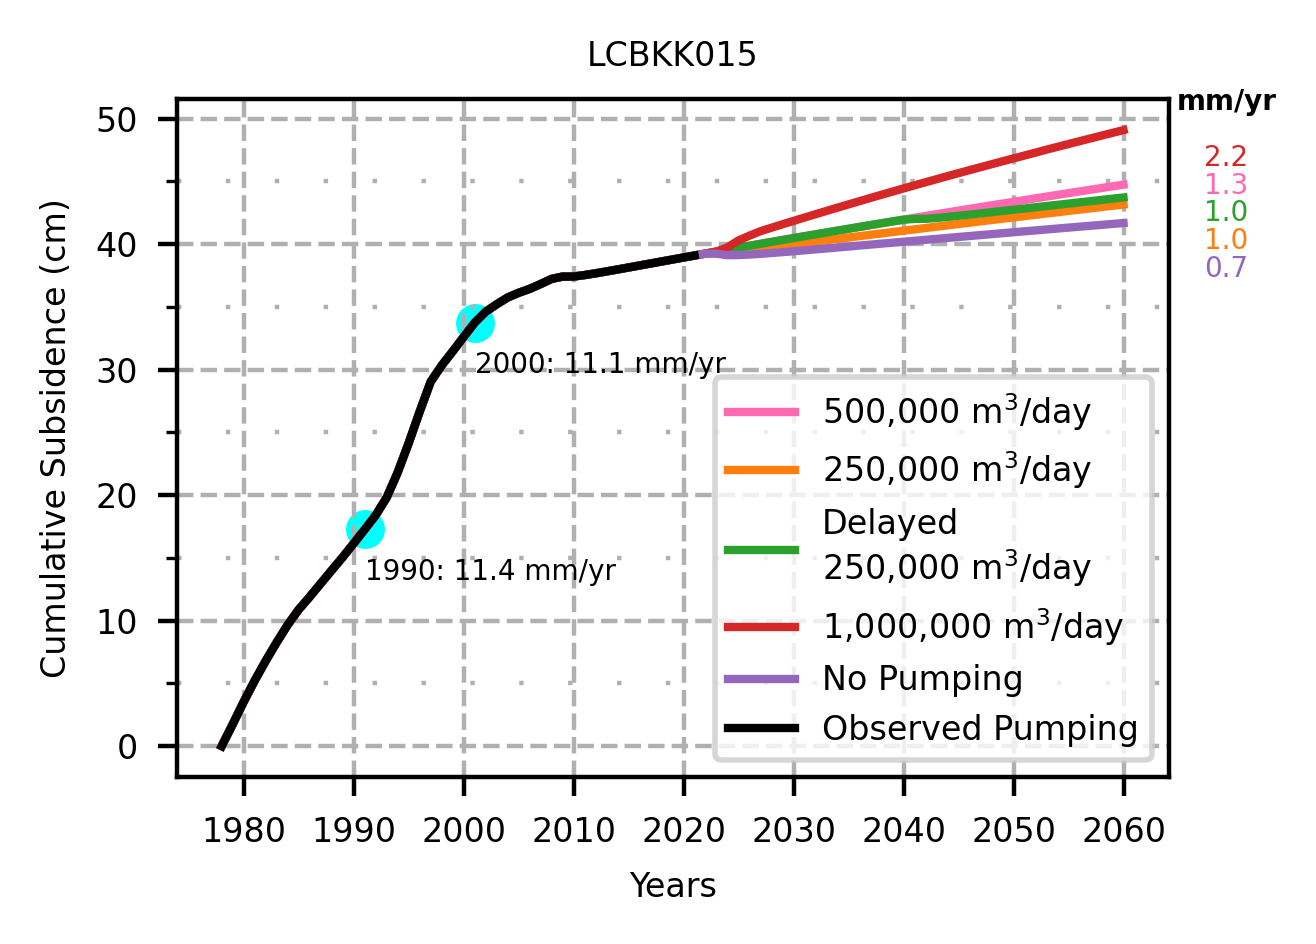

<Figure size 640x480 with 0 Axes>

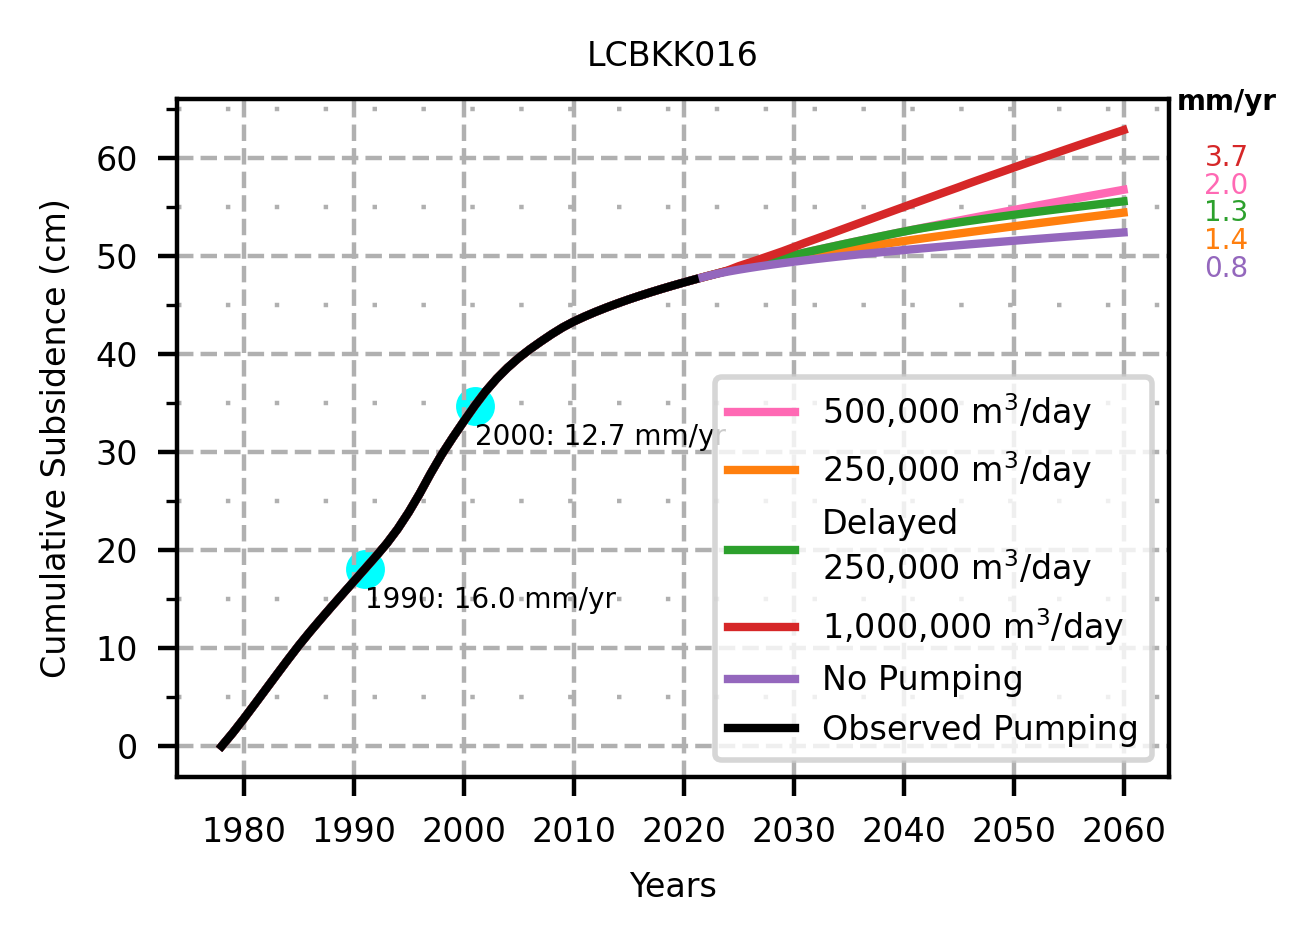

<Figure size 640x480 with 0 Axes>

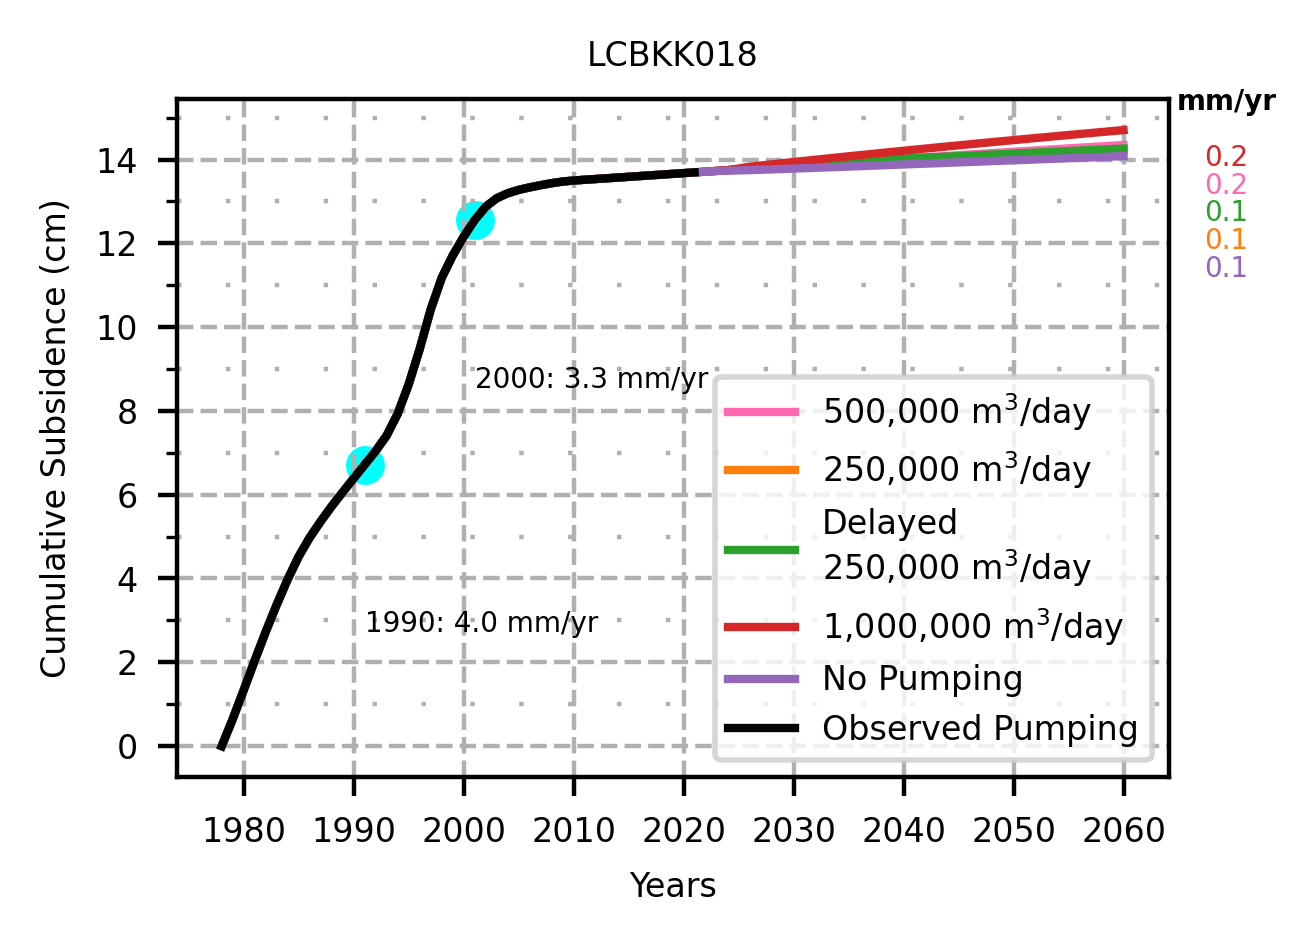

<Figure size 640x480 with 0 Axes>

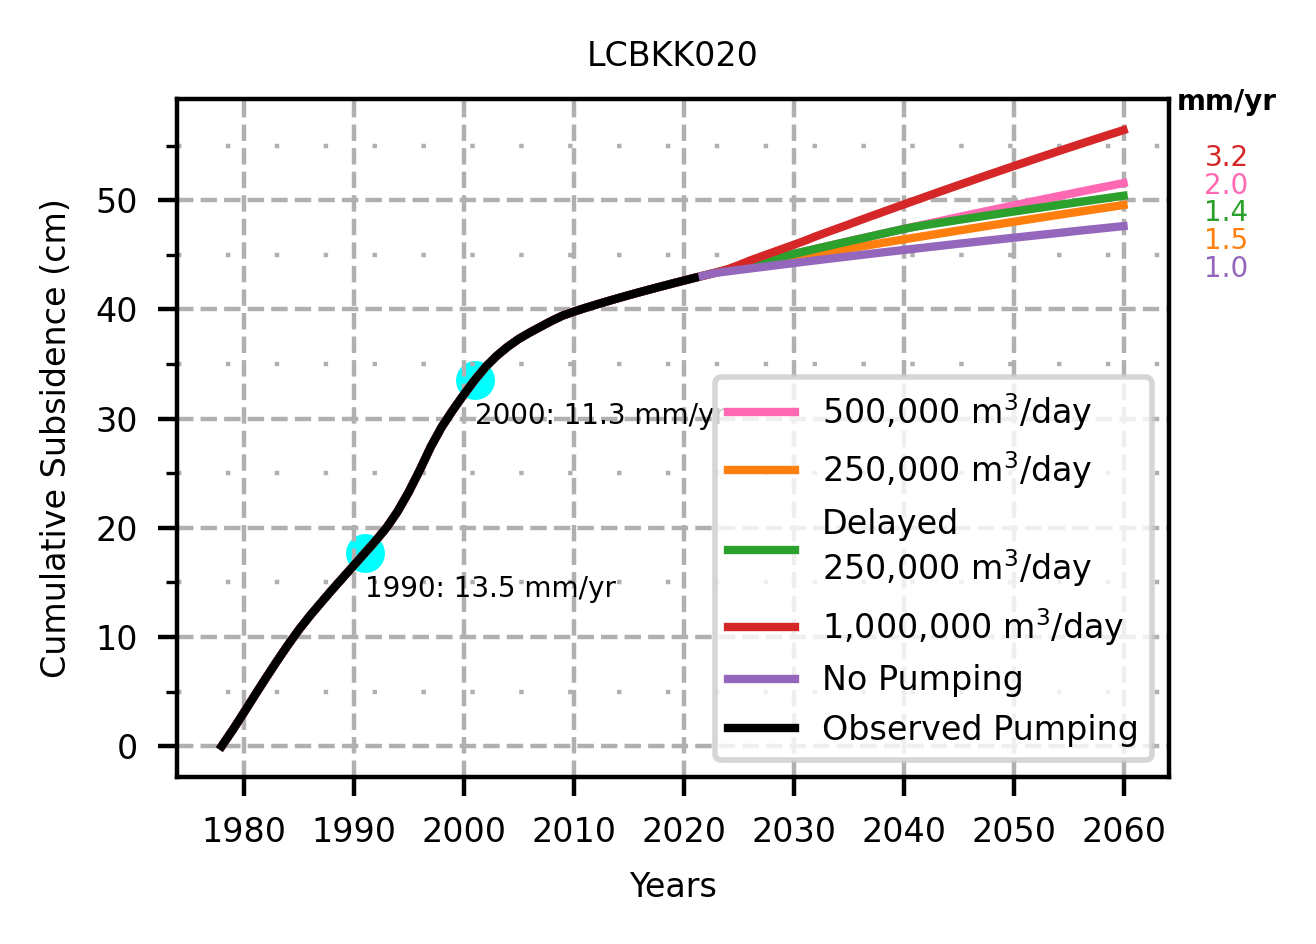

<Figure size 640x480 with 0 Axes>

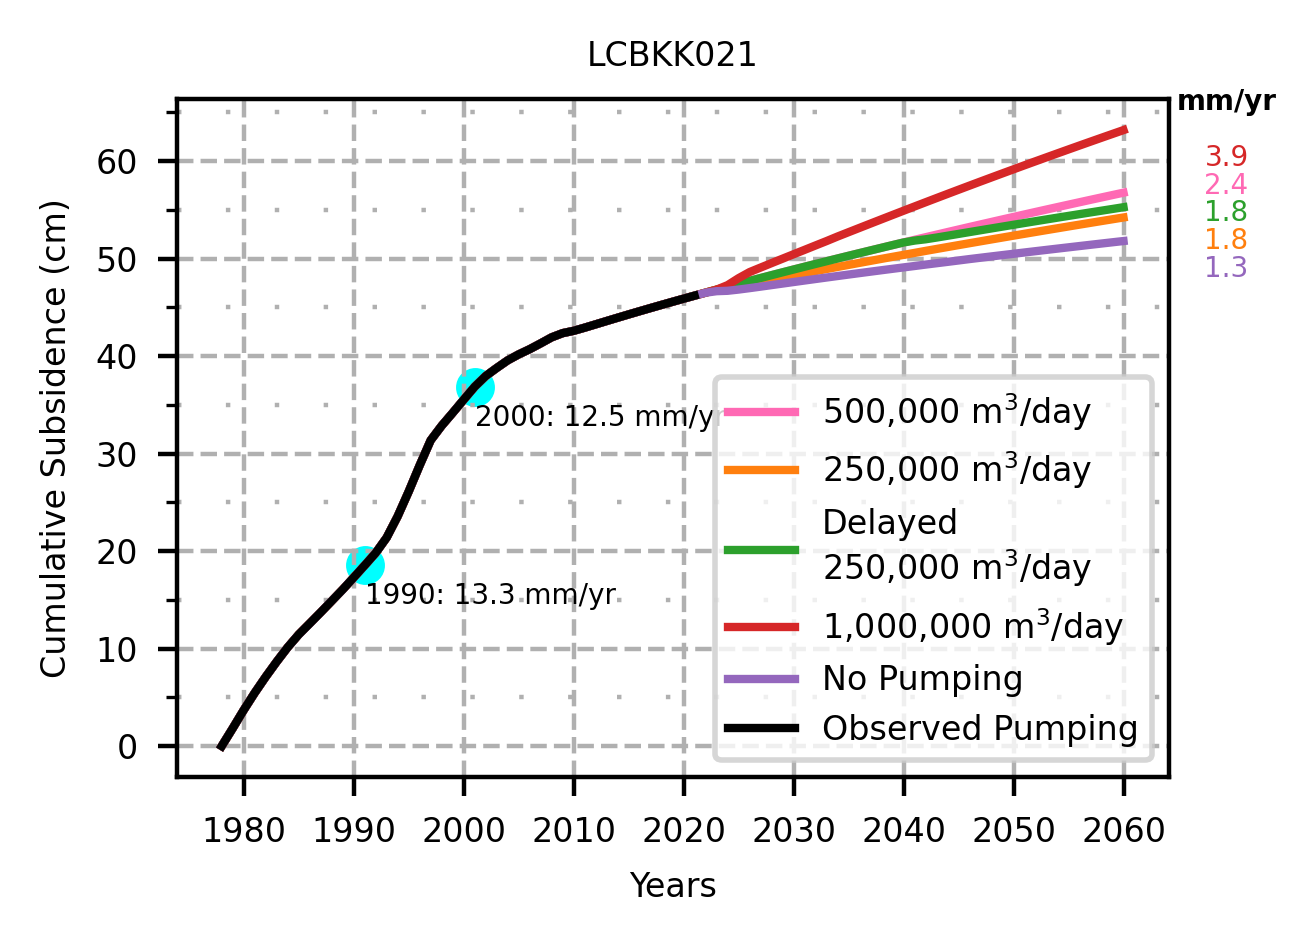

<Figure size 640x480 with 0 Axes>

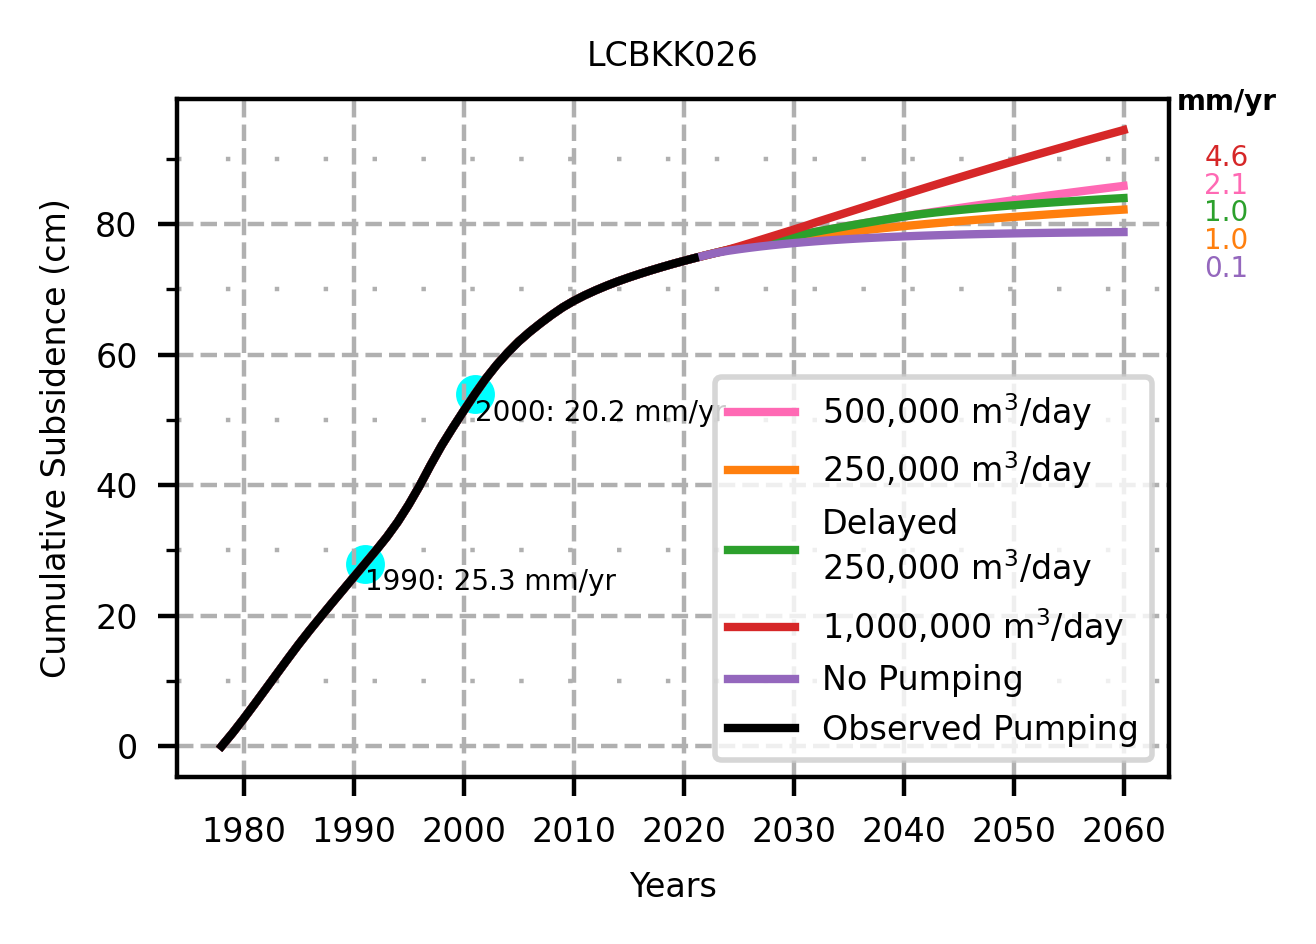

<Figure size 640x480 with 0 Axes>

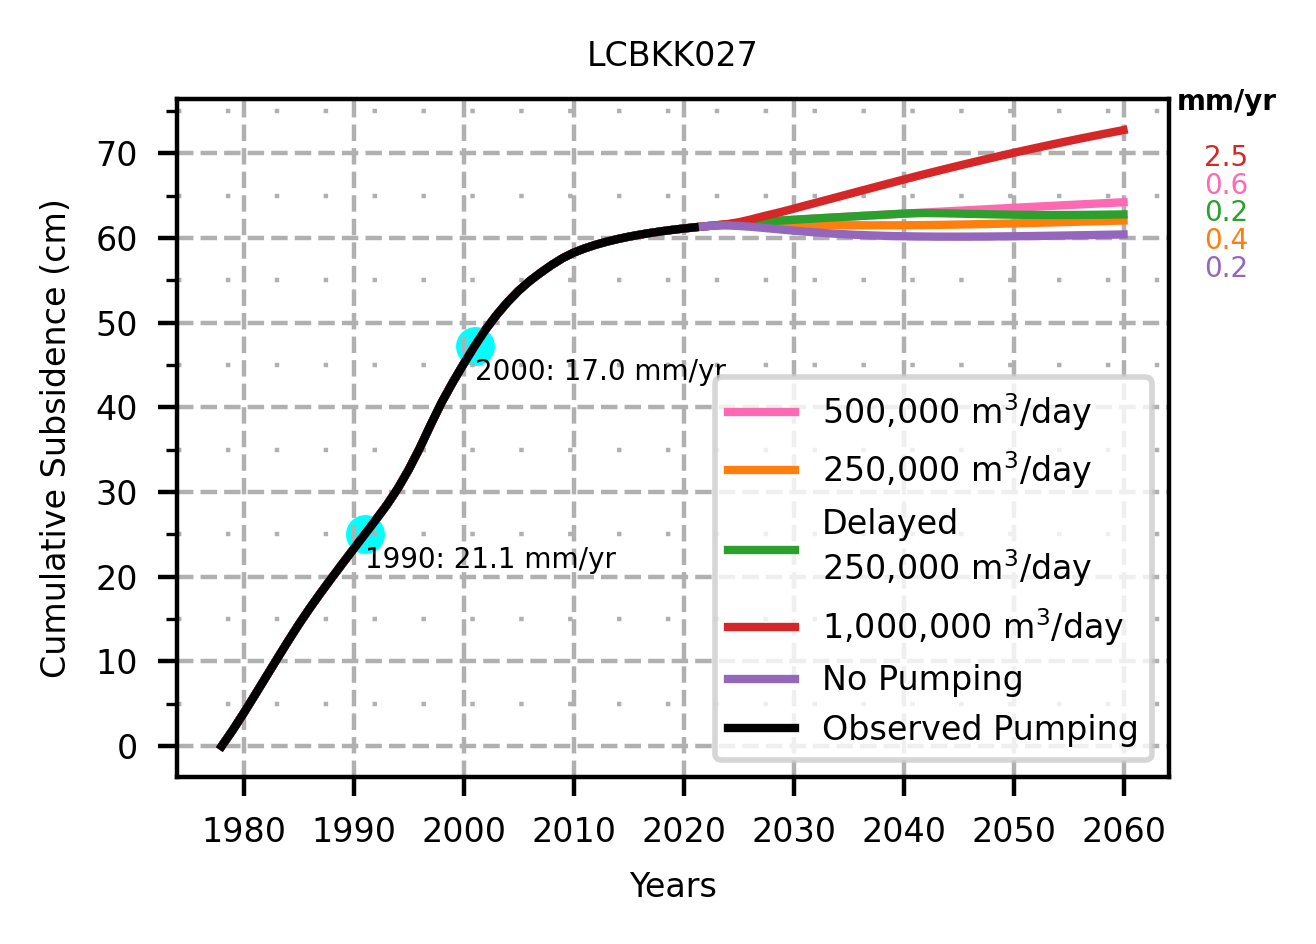

<Figure size 640x480 with 0 Axes>

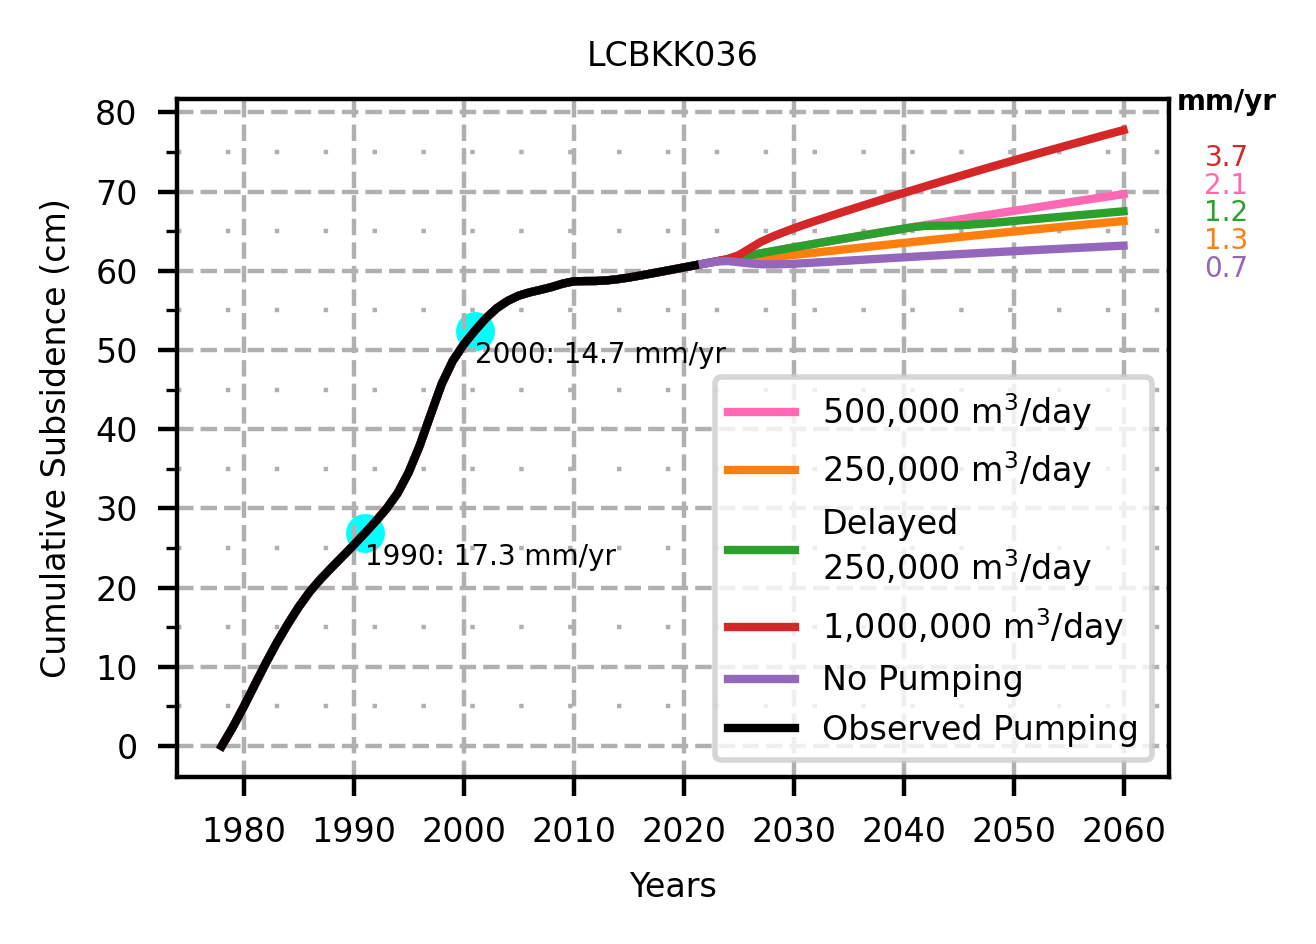

<Figure size 640x480 with 0 Axes>

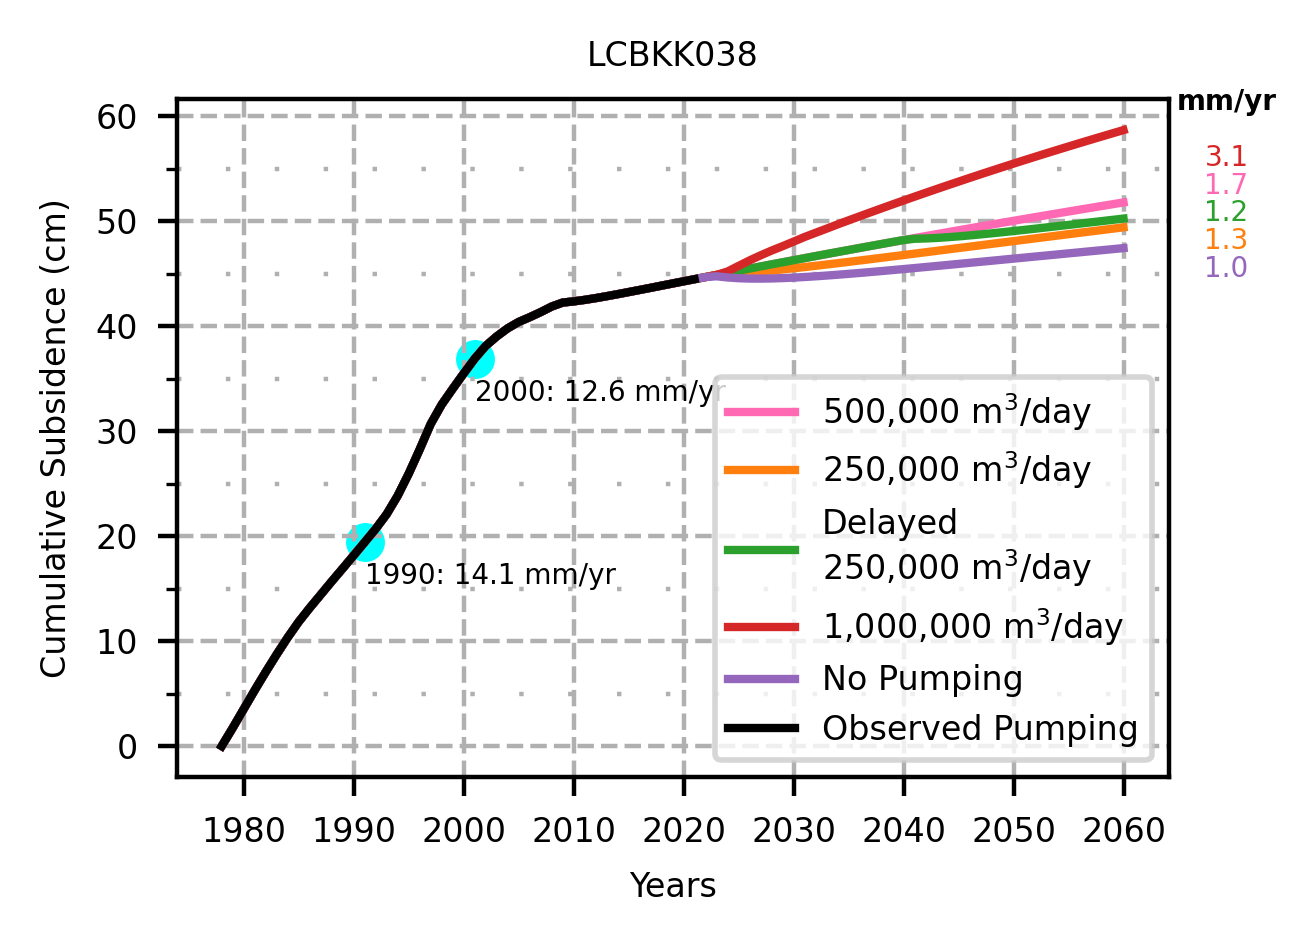

<Figure size 640x480 with 0 Axes>

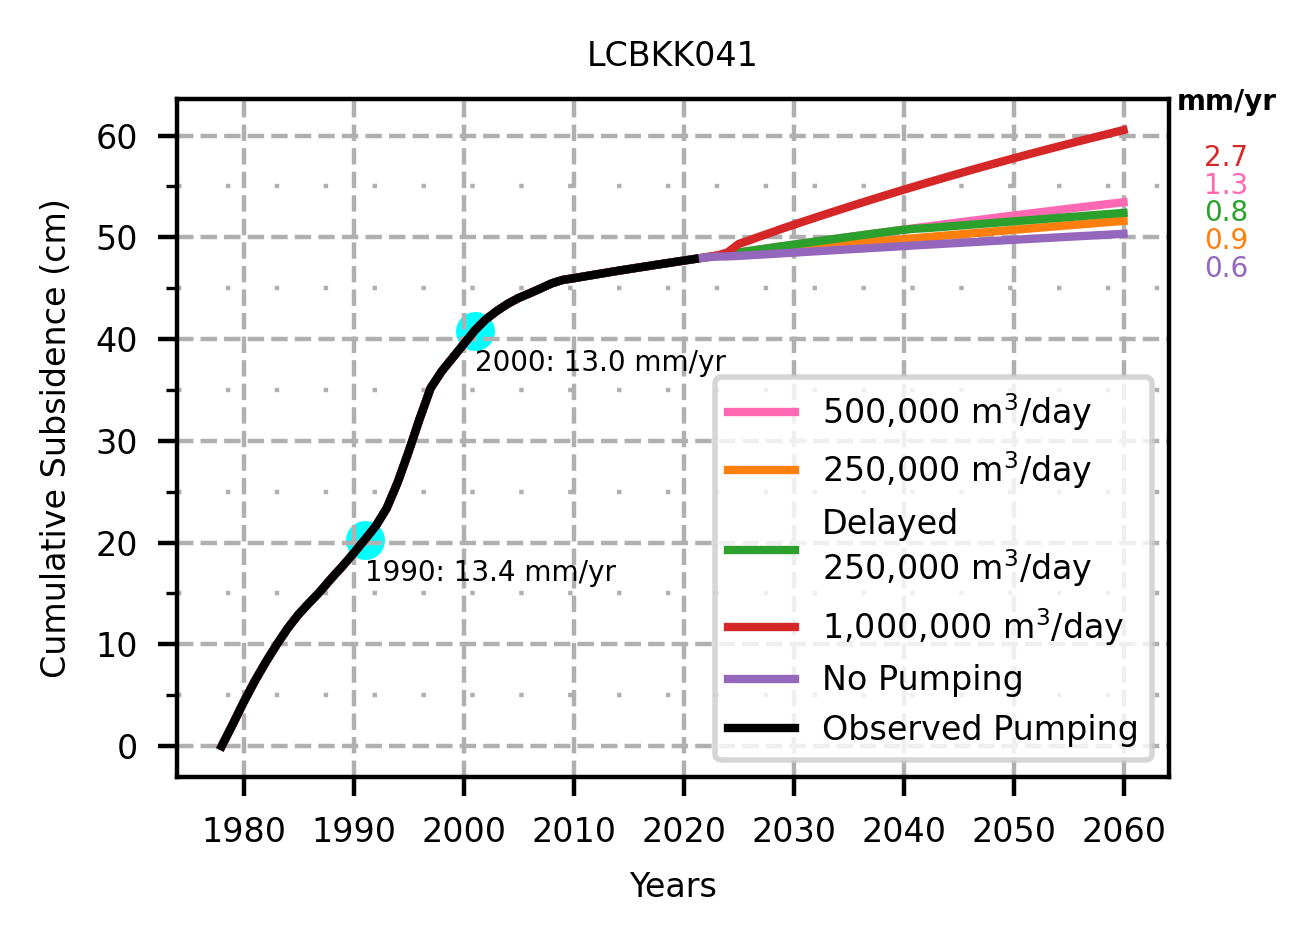

<Figure size 640x480 with 0 Axes>

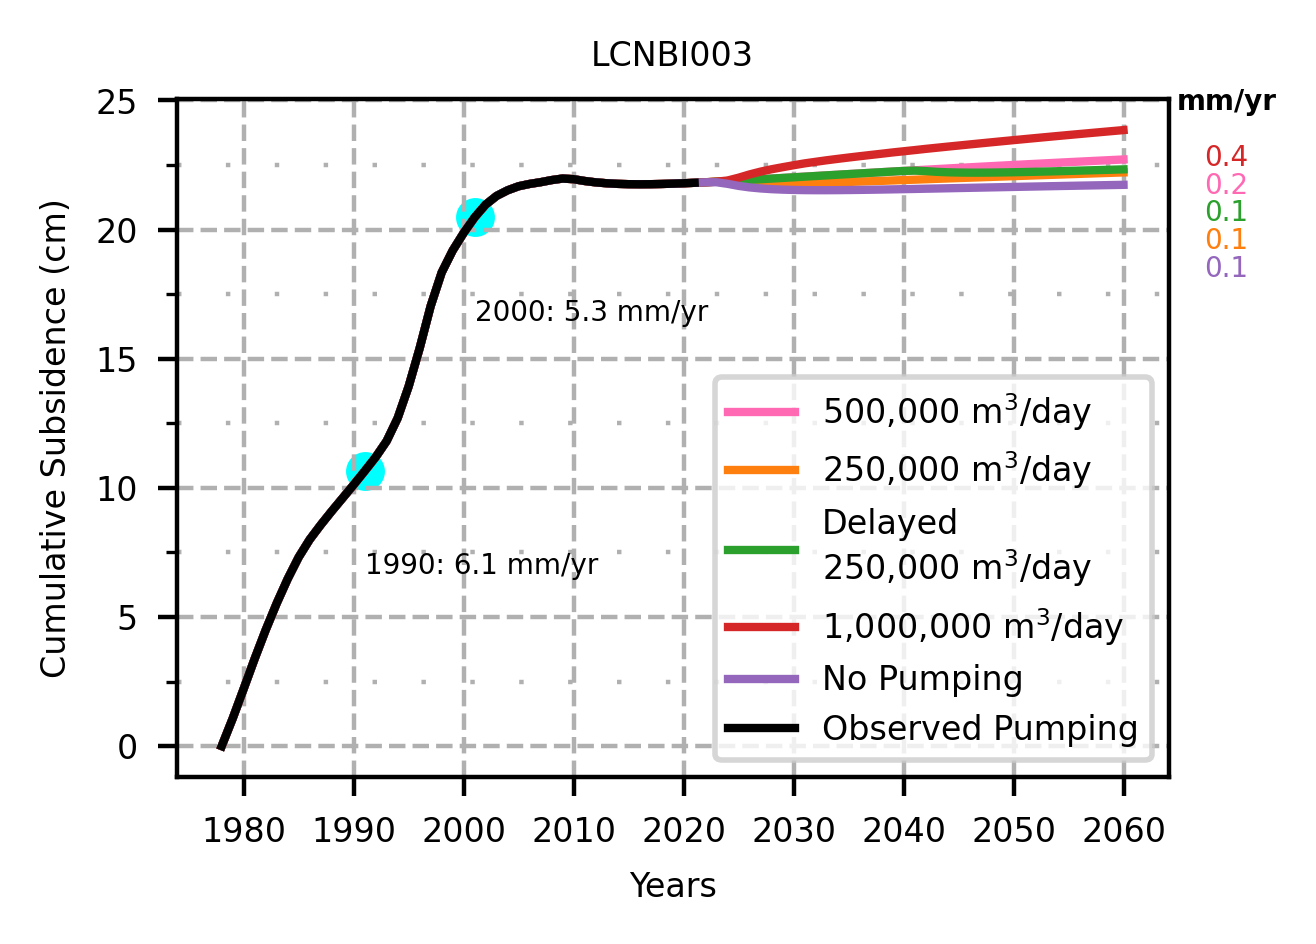

<Figure size 640x480 with 0 Axes>

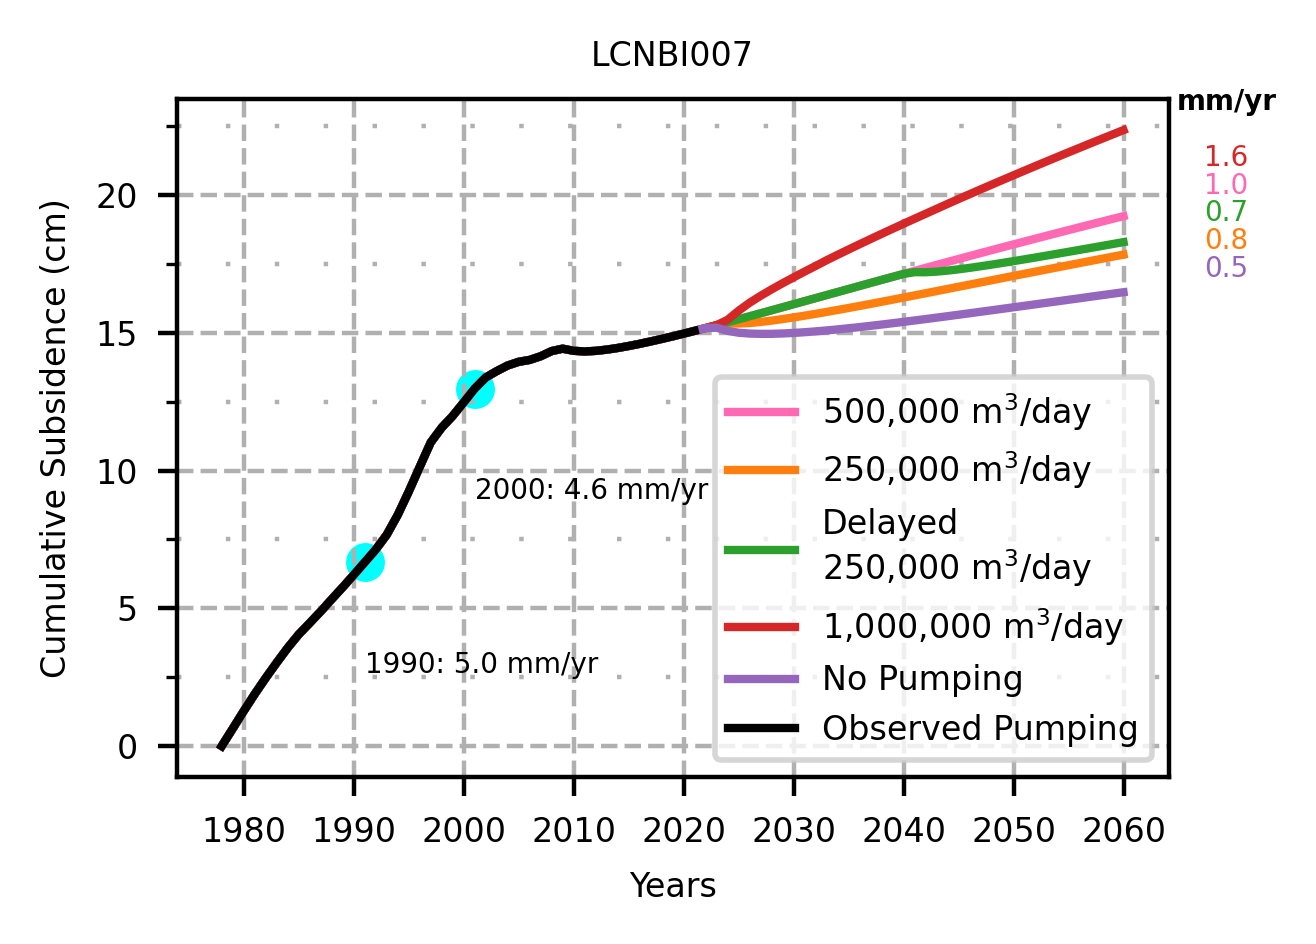

<Figure size 640x480 with 0 Axes>

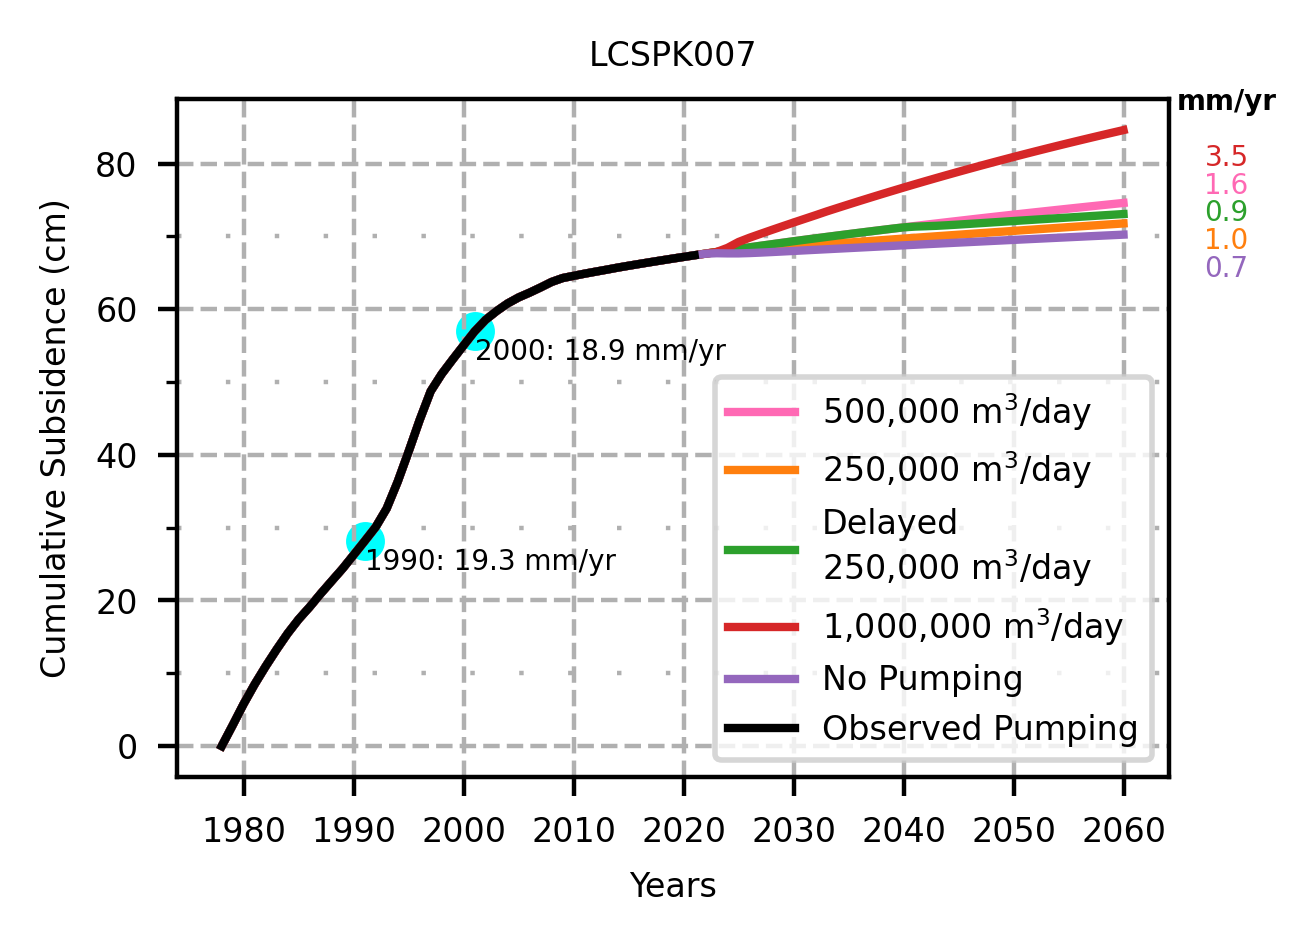

<Figure size 640x480 with 0 Axes>

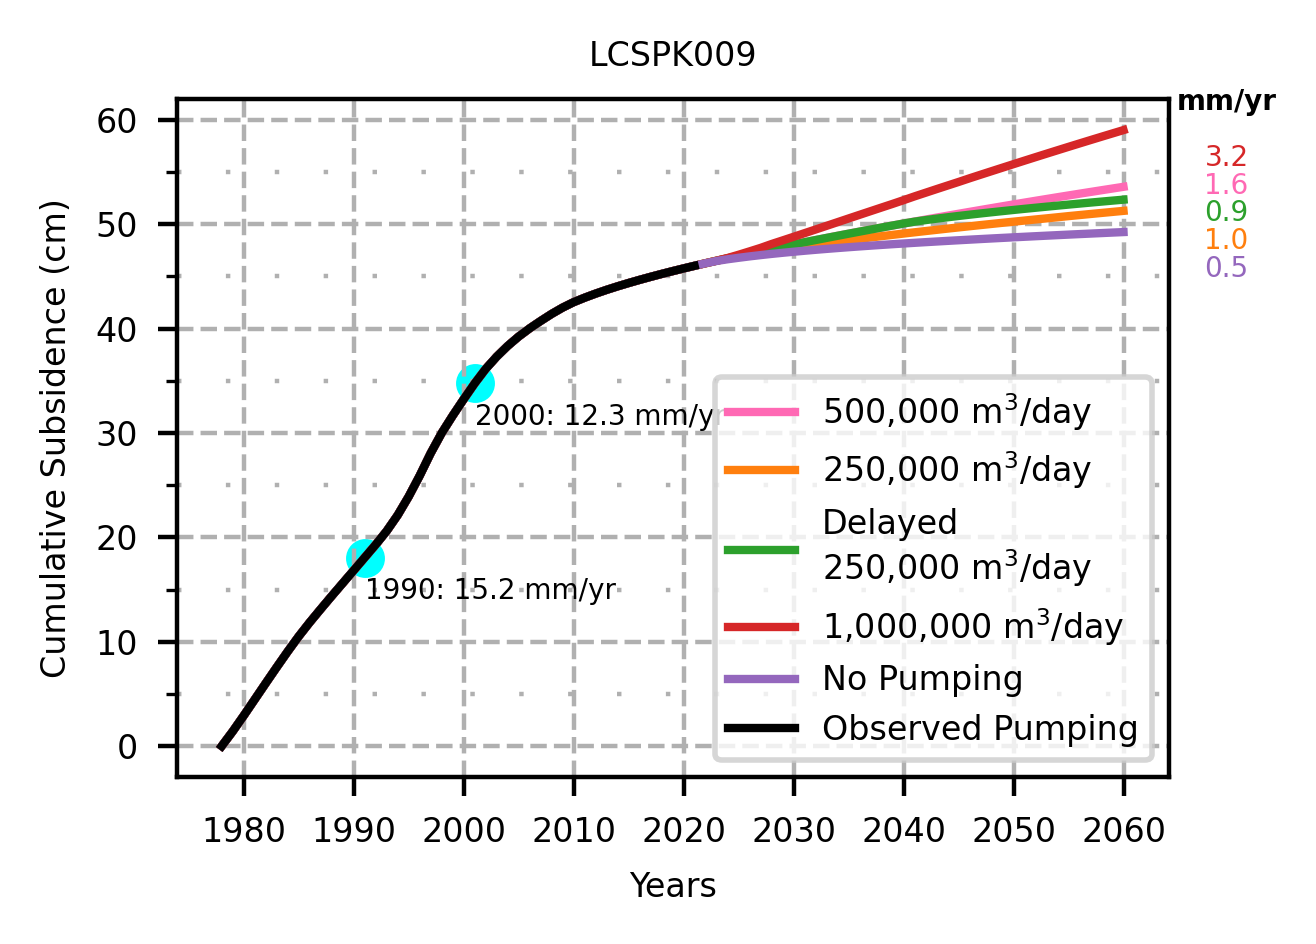


500,000 scenario min, avg, max, med 2060 rate mm/yr: -0.0000, 1.2832, 2.6130, 1.3469

250,000 scenario min, avg, max, med 2060 rate mm/yr: -0.0143, 0.8288, 1.9527, 0.8630

Delayed250,000 scenario min, avg, max, med 2060 rate mm/yr: -0.1772, 0.7598, 1.8630, 0.8413

1,000,000 scenario min, avg, max, med 2060 rate mm/yr: 0.2329, 2.6105, 5.2996, 2.6551

No pumping scenario min, avg, max, med 2060 rate mm/yr: -0.0216, 0.5301, 1.3865, 0.5491


<Figure size 640x480 with 0 Axes>

In [7]:
# Creating (0) or importing (1)
importing = 1

# If saving
saving = 0

# All ann subs
all_ann_subs = []

# If creating results for first time
if importing == 0:

    # For each well nest
    wellnestlist = ["LCBKK003",
                    "LCBKK005",
                    "LCBKK006",
                    "LCBKK007",
                    "LCBKK009",
                    "LCBKK011",
                    "LCBKK012",
                    "LCBKK013",
                    "LCBKK014",
                    "LCBKK015",
                    "LCBKK016",
                    "LCBKK018",
                    "LCBKK020",
                    "LCBKK021",
                    "LCBKK026",
                    "LCBKK027",
                    "LCBKK036",
                    "LCBKK038",
                    "LCBKK041",
                    "LCNBI003",
                    "LCNBI007",
                    "LCSPK007",
                    "LCSPK009"]
    tmin = "1978"
    tmax = "2060"

    # Pumping flag, for PASTAS, if changing pumping scenario
    pumpflag = 1
    # If changing pumping scenario, need pumping sheet/path
    if pumpflag == 1:

        ppath = os.path.join(os.path.abspath("inputs"), "BasinPumping.xlsx")

        # Pumping sheets
        pumpsheets = ["EstTotalPump_54-60_Int50",
                      "EstTotalPump_54-60_IntF25",
                      "EstTotalPump_54-60_IntF100",
                      "EstTotalPump_54-60_IntF50_25",
                      "EstTotalPump_54-60_IntF0"]

        scenarios = ["500", "250", "100", "500_250", "0"]

    # Convergence criteria
    CC = 1 * 10**-5

    # Number of nodes in clay
    node_num = 10

    # Using available heads as proxy for missing
    proxyflag = 1

    # For each pumping scenario
    for index, pumpsheet in enumerate(pumpsheets):

        # Calculates subsidence
        all_results, sub_total, subv_total = bkk_sub_gw.\
            bkk_sub.bkk_subsidence(wellnestlist,
                                   mode, tmin,
                                   tmax,
                                   Thick_data,
                                   K_data,
                                   Sskv_data,
                                   Sske_data,
                                   CC=CC,
                                   Nz=node_num,
                                   ic_run=True,
                                   proxyflag=proxyflag,
                                   pumpflag=pumpflag,
                                   pump_path=ppath,
                                   pump_sheet=pumpsheet,
                                   model_path=mpath)

        # Post process data
        sub_total, subv_total, ann_sub, \
            _ = bkk_sub_gw.bkk_sub.bkk_postproc(wellnestlist,
                                                sub_total,
                                                subv_total,
                                                all_results)

        all_ann_subs.append(ann_sub)

        # Dictionary to store everything
        model_sub = {"wellnestlist": wellnestlist,
                     "all_results": all_results,
                     "sub_total": sub_total,
                     "subv_total": subv_total,
                     "ann_sub": ann_sub,
                     "tmin": tmin,
                     "tmax": tmax,
                     "Thick_data": Thick_data,
                     "Sske_data": Sske_data,
                     "Sskv_data": Sskv_data,
                     "K_data": K_data,
                     "pumping_scenario": scenarios[index],
                     "CC": CC,
                     "clay_nodes": node_num,
                     "proxyflag": proxyflag,
                     "mode": mode}

        # If saving
        if saving == 1:

            # Path to save models
            path = os.path.abspath("models")

            # Saving dict for this model
            afile = open(path + "\\Allnests_sub_" + scenarios[index] + ".pkl", "wb")
            pickle.dump(model_sub, afile)
            afile.close()

# if importing subsidence model results
else:

    # Path to import models
    path = os.path.abspath("models")
    scenarios = ["500", "250", "100", "500_250", "0"]
    for scenario in scenarios:

        # Reload object from file
        file2 = open(path + "\\Allnests_sub_" + scenario + ".pkl", "rb")
        model_sub = pickle.load(file2)
        file2.close()

        all_ann_subs.append(model_sub["ann_sub"])

# Plotting
# path to save figures
path = os.path.abspath("figures")

bkk_sub_gw.bkk_plotting.sub_forecast(path, model_sub["wellnestlist"],
                                     all_ann_subs,
                                     save=1)

## Plots Results: Maps of cumulative subsidence (cm) for pumping scenarios for new tmin and tmax
Figure 13 in main paper

<Figure size 640x480 with 0 Axes>

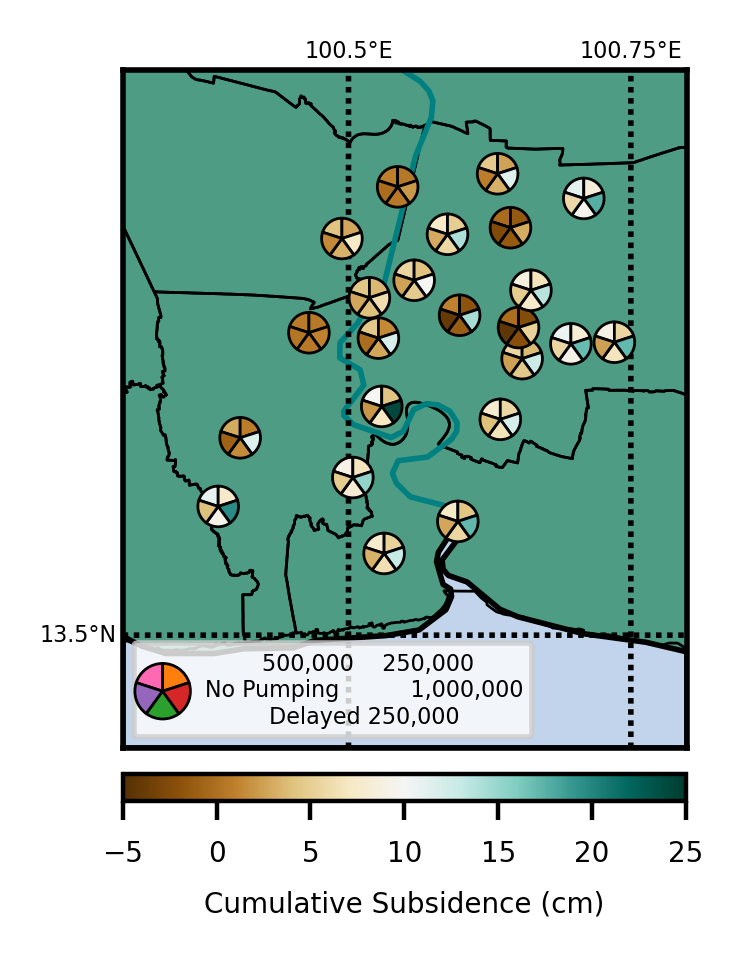

In [8]:
plt.set_cmap("BrBG")
tmin = "2020"
tmax = "2060"
bkk_sub_gw.bkk_plotting.sub_forecast_map(path, model_sub["wellnestlist"],
                                         all_ann_subs, tmin, tmax,
                                         save=0)

## Runs and plots results: Sensitivity Analysis
Supplemental information 1.6

Cum sub (cm): -1.203661617792684
Cum sub in time period relative to total sub (%): -2.4745171479057153
Cum sub (cm): 18.620137991529294
Cum sub in time period relative to total sub (%): 38.279737490429845
Cum sub (cm): 36.37016998666809
Cum sub in time period relative to total sub (%): 74.77068968045906
Cum sub (cm): 16.499780750829622
Cum sub in time period relative to total sub (%): 33.92065494244651
Cum sub (cm): -5.6656388158498885
Cum sub in time period relative to total sub (%): -11.647559576893903


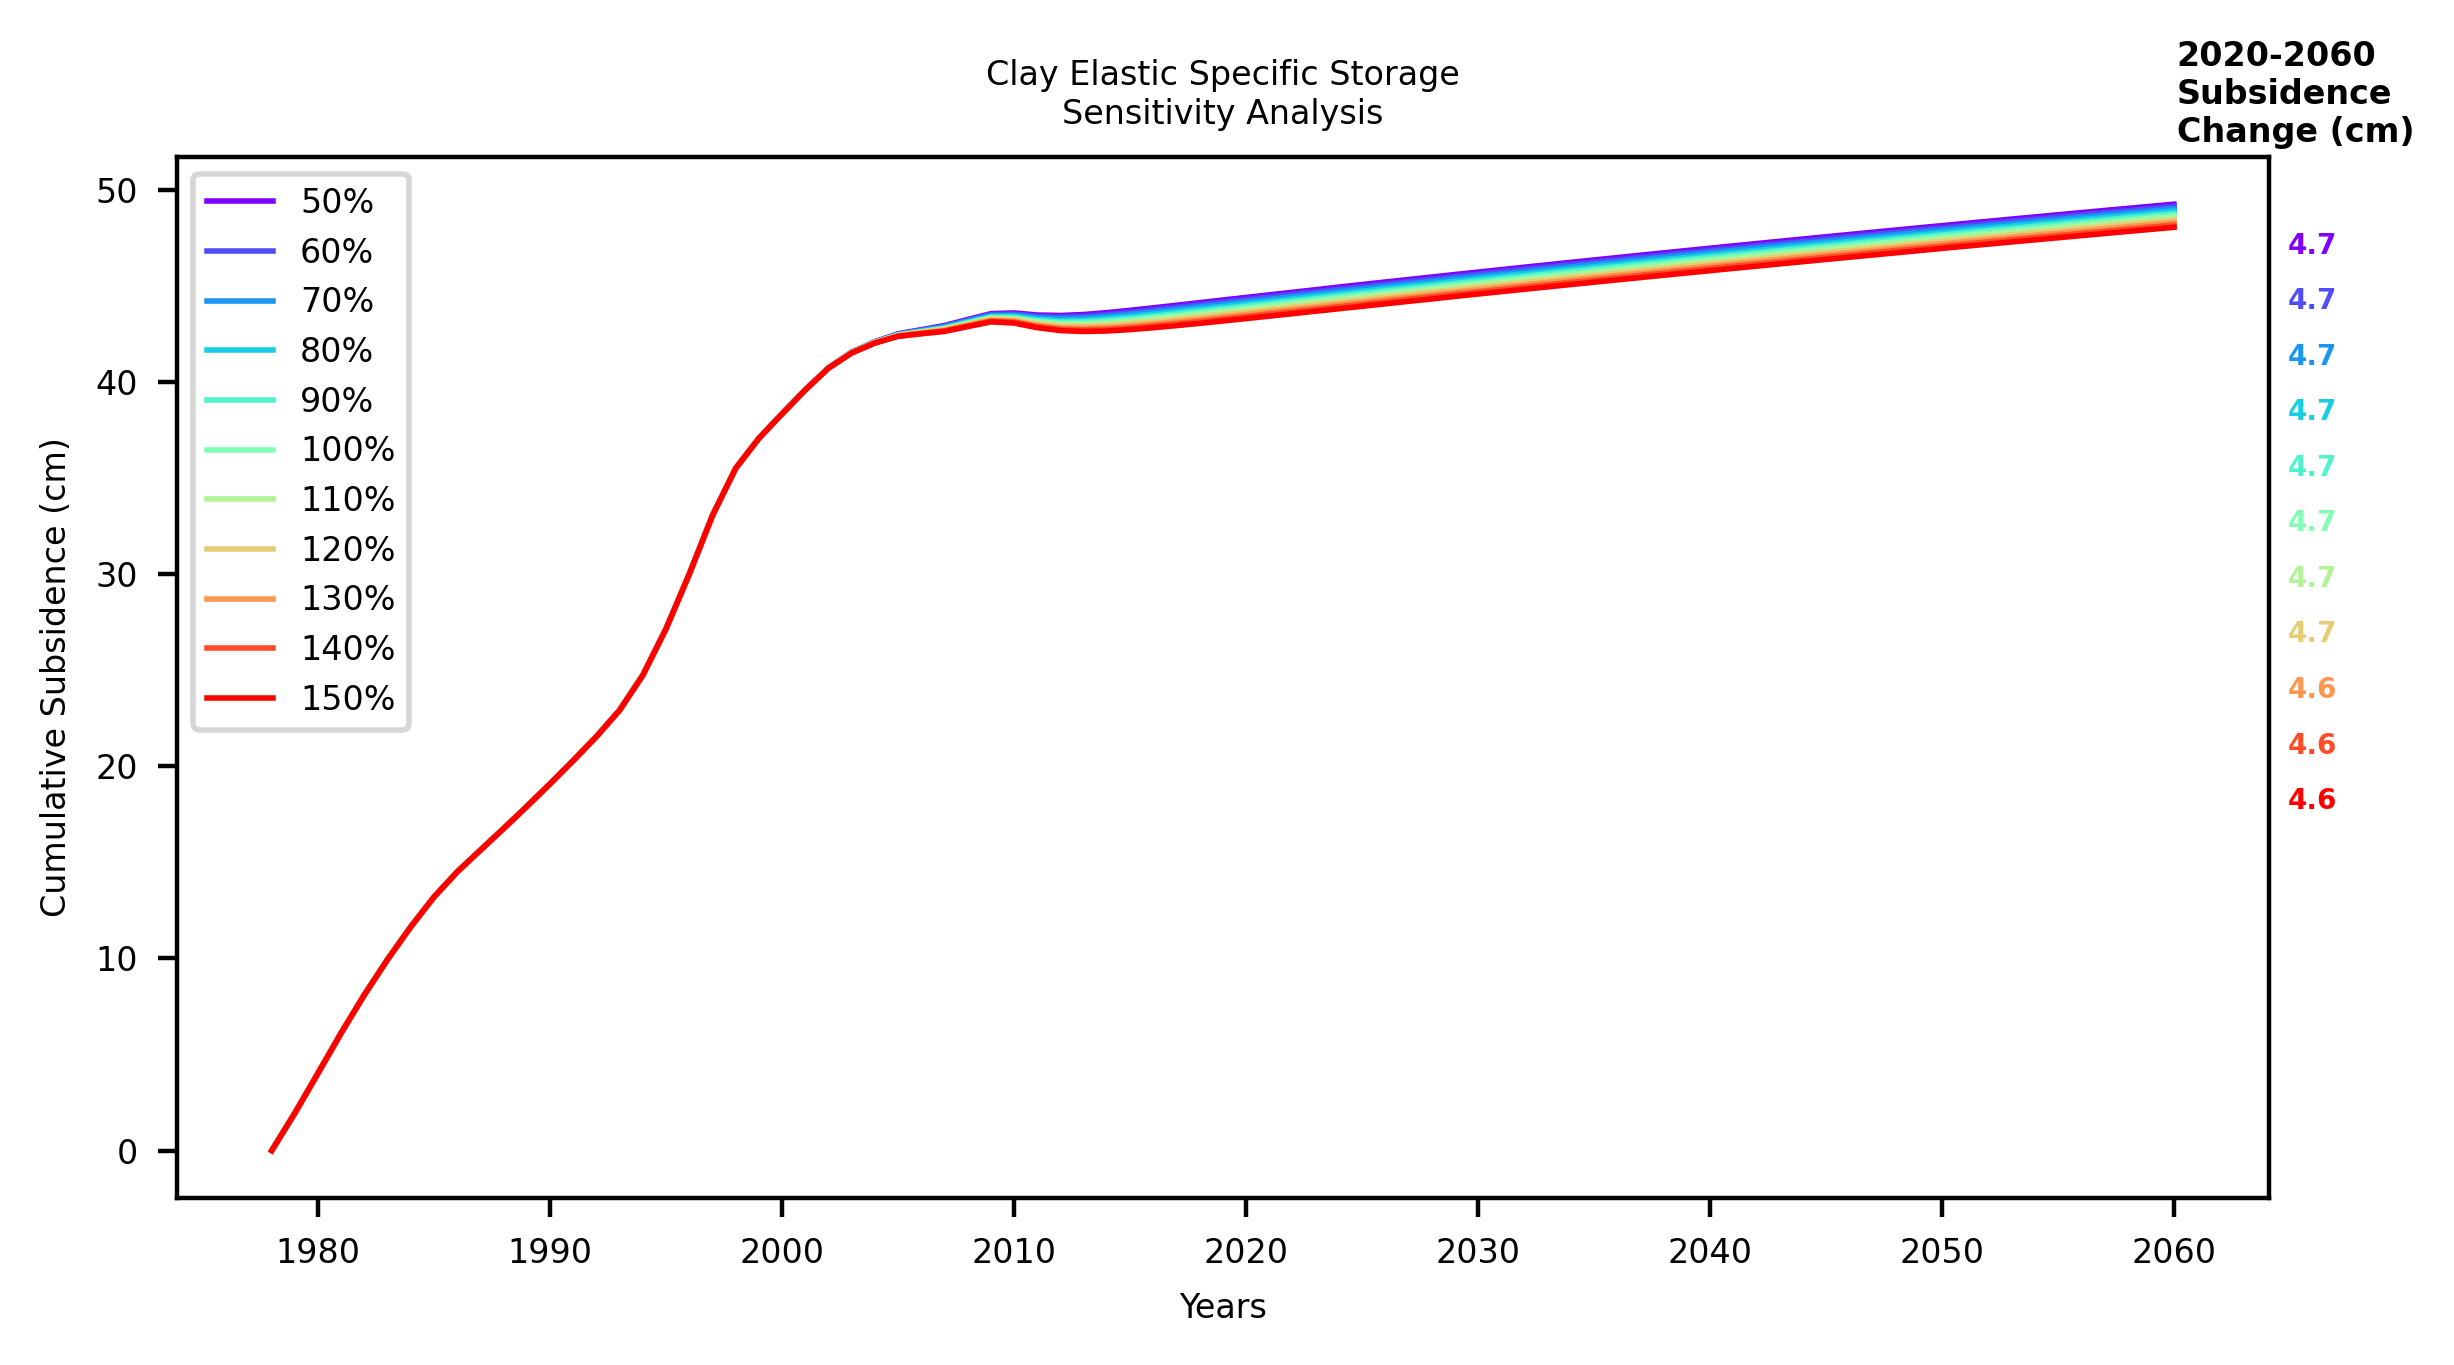

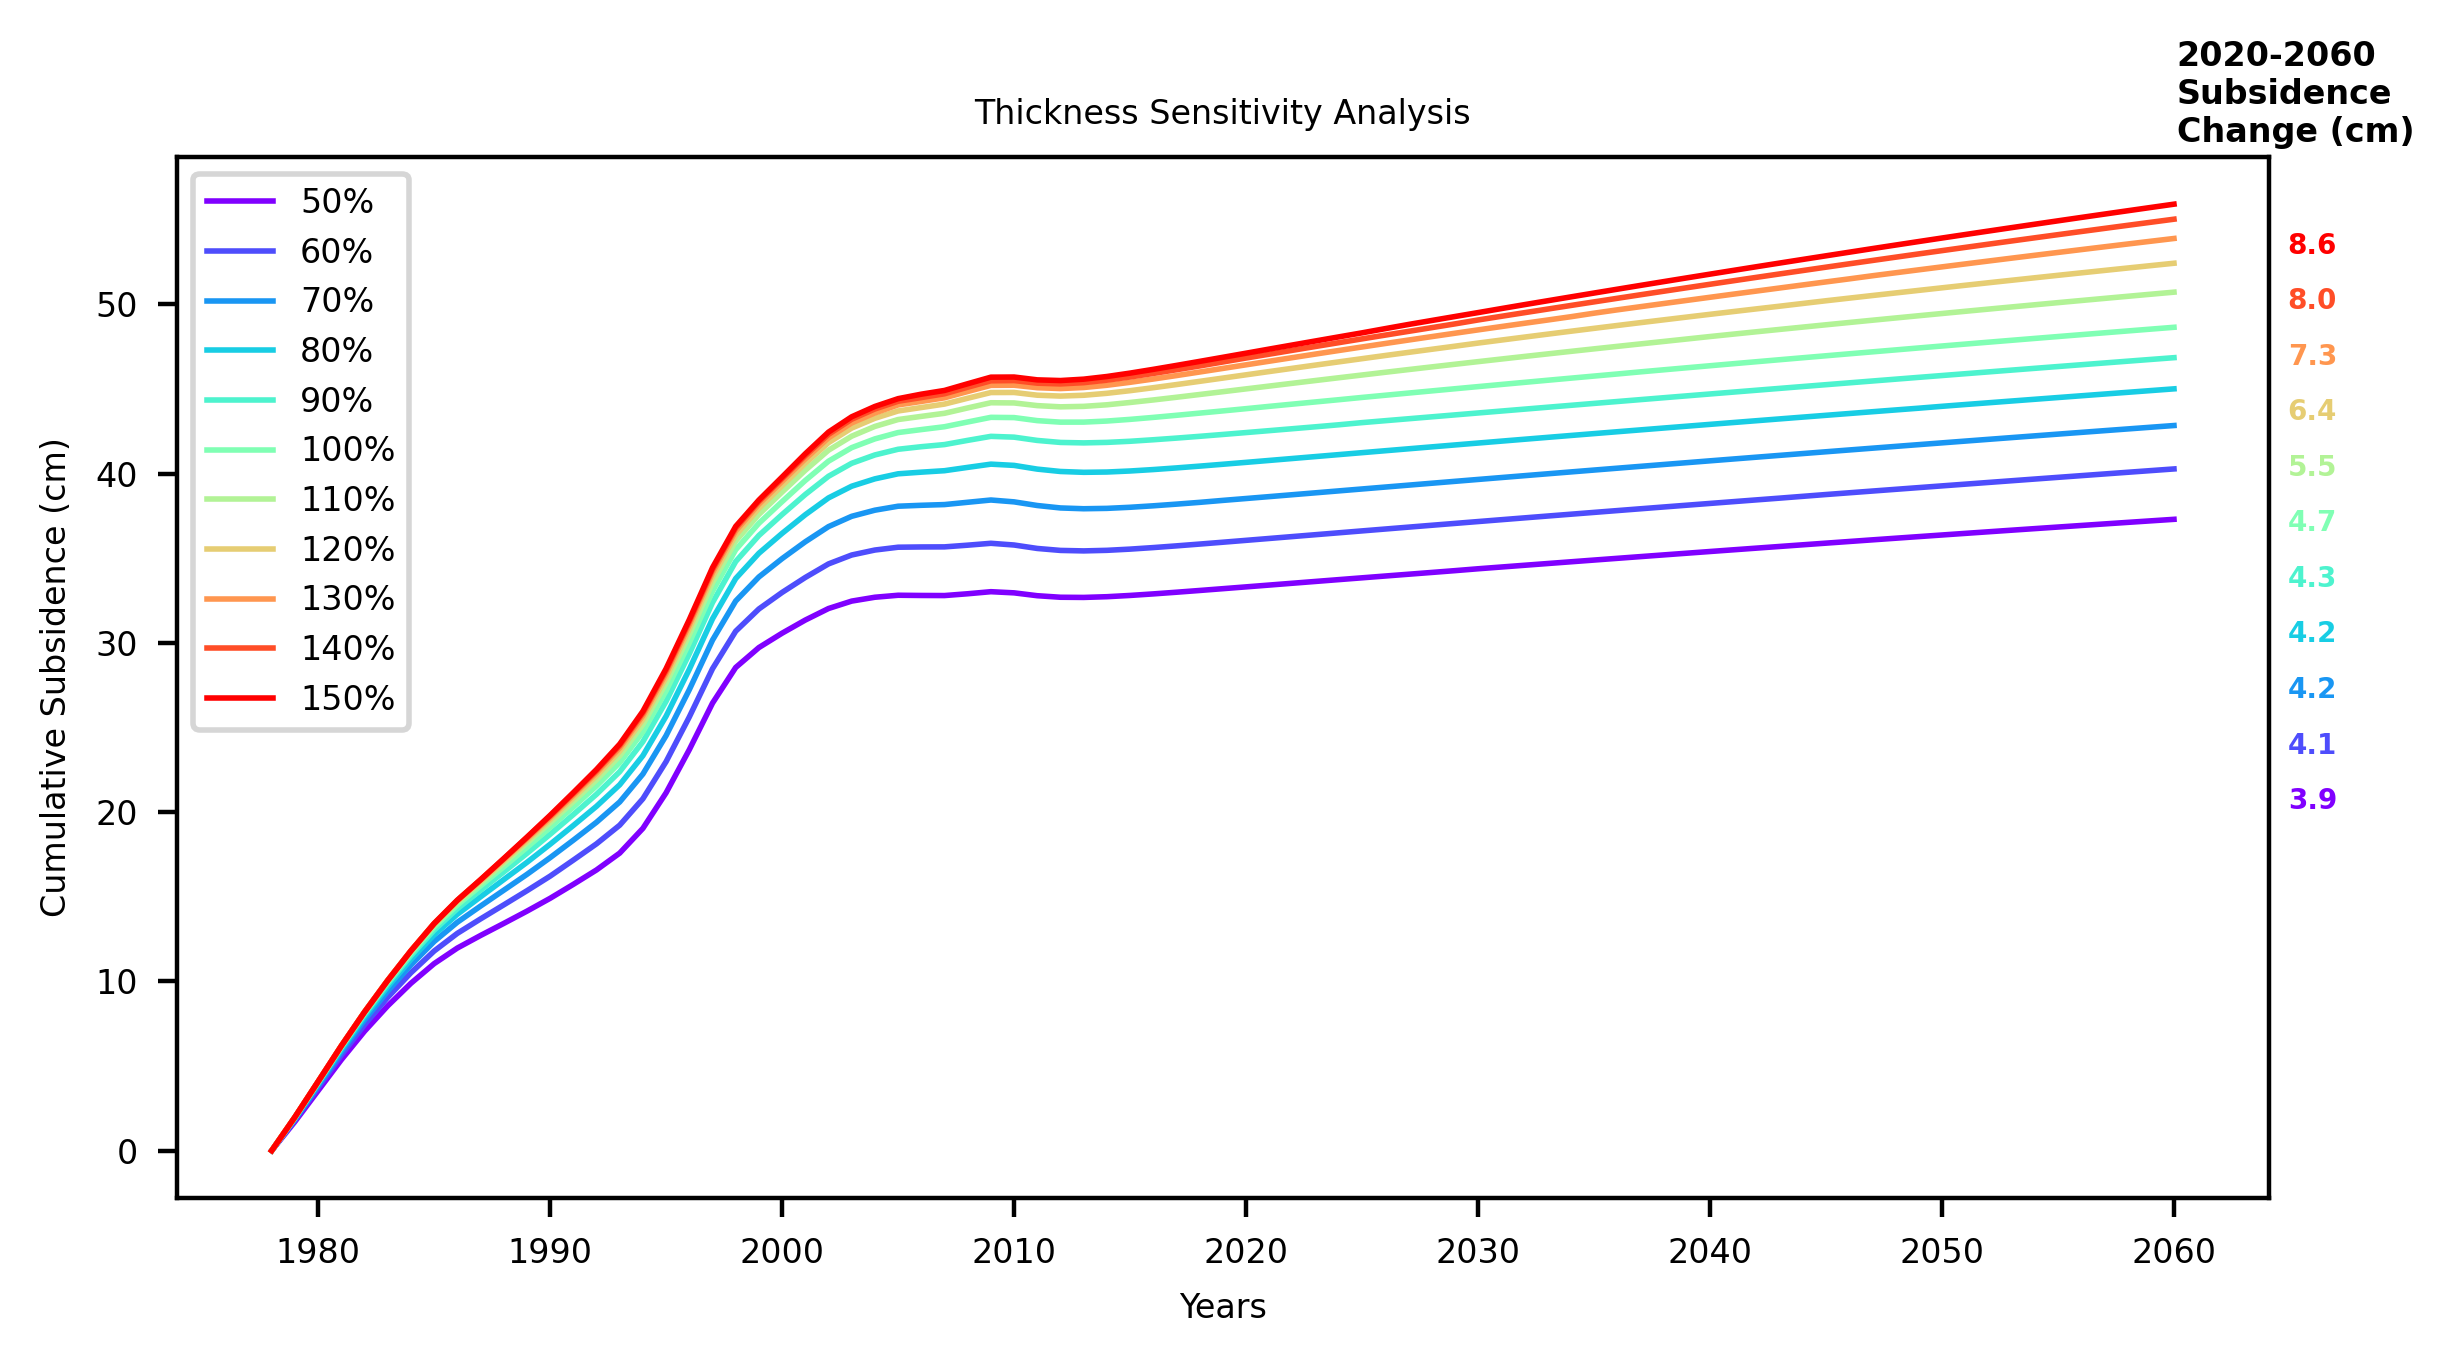

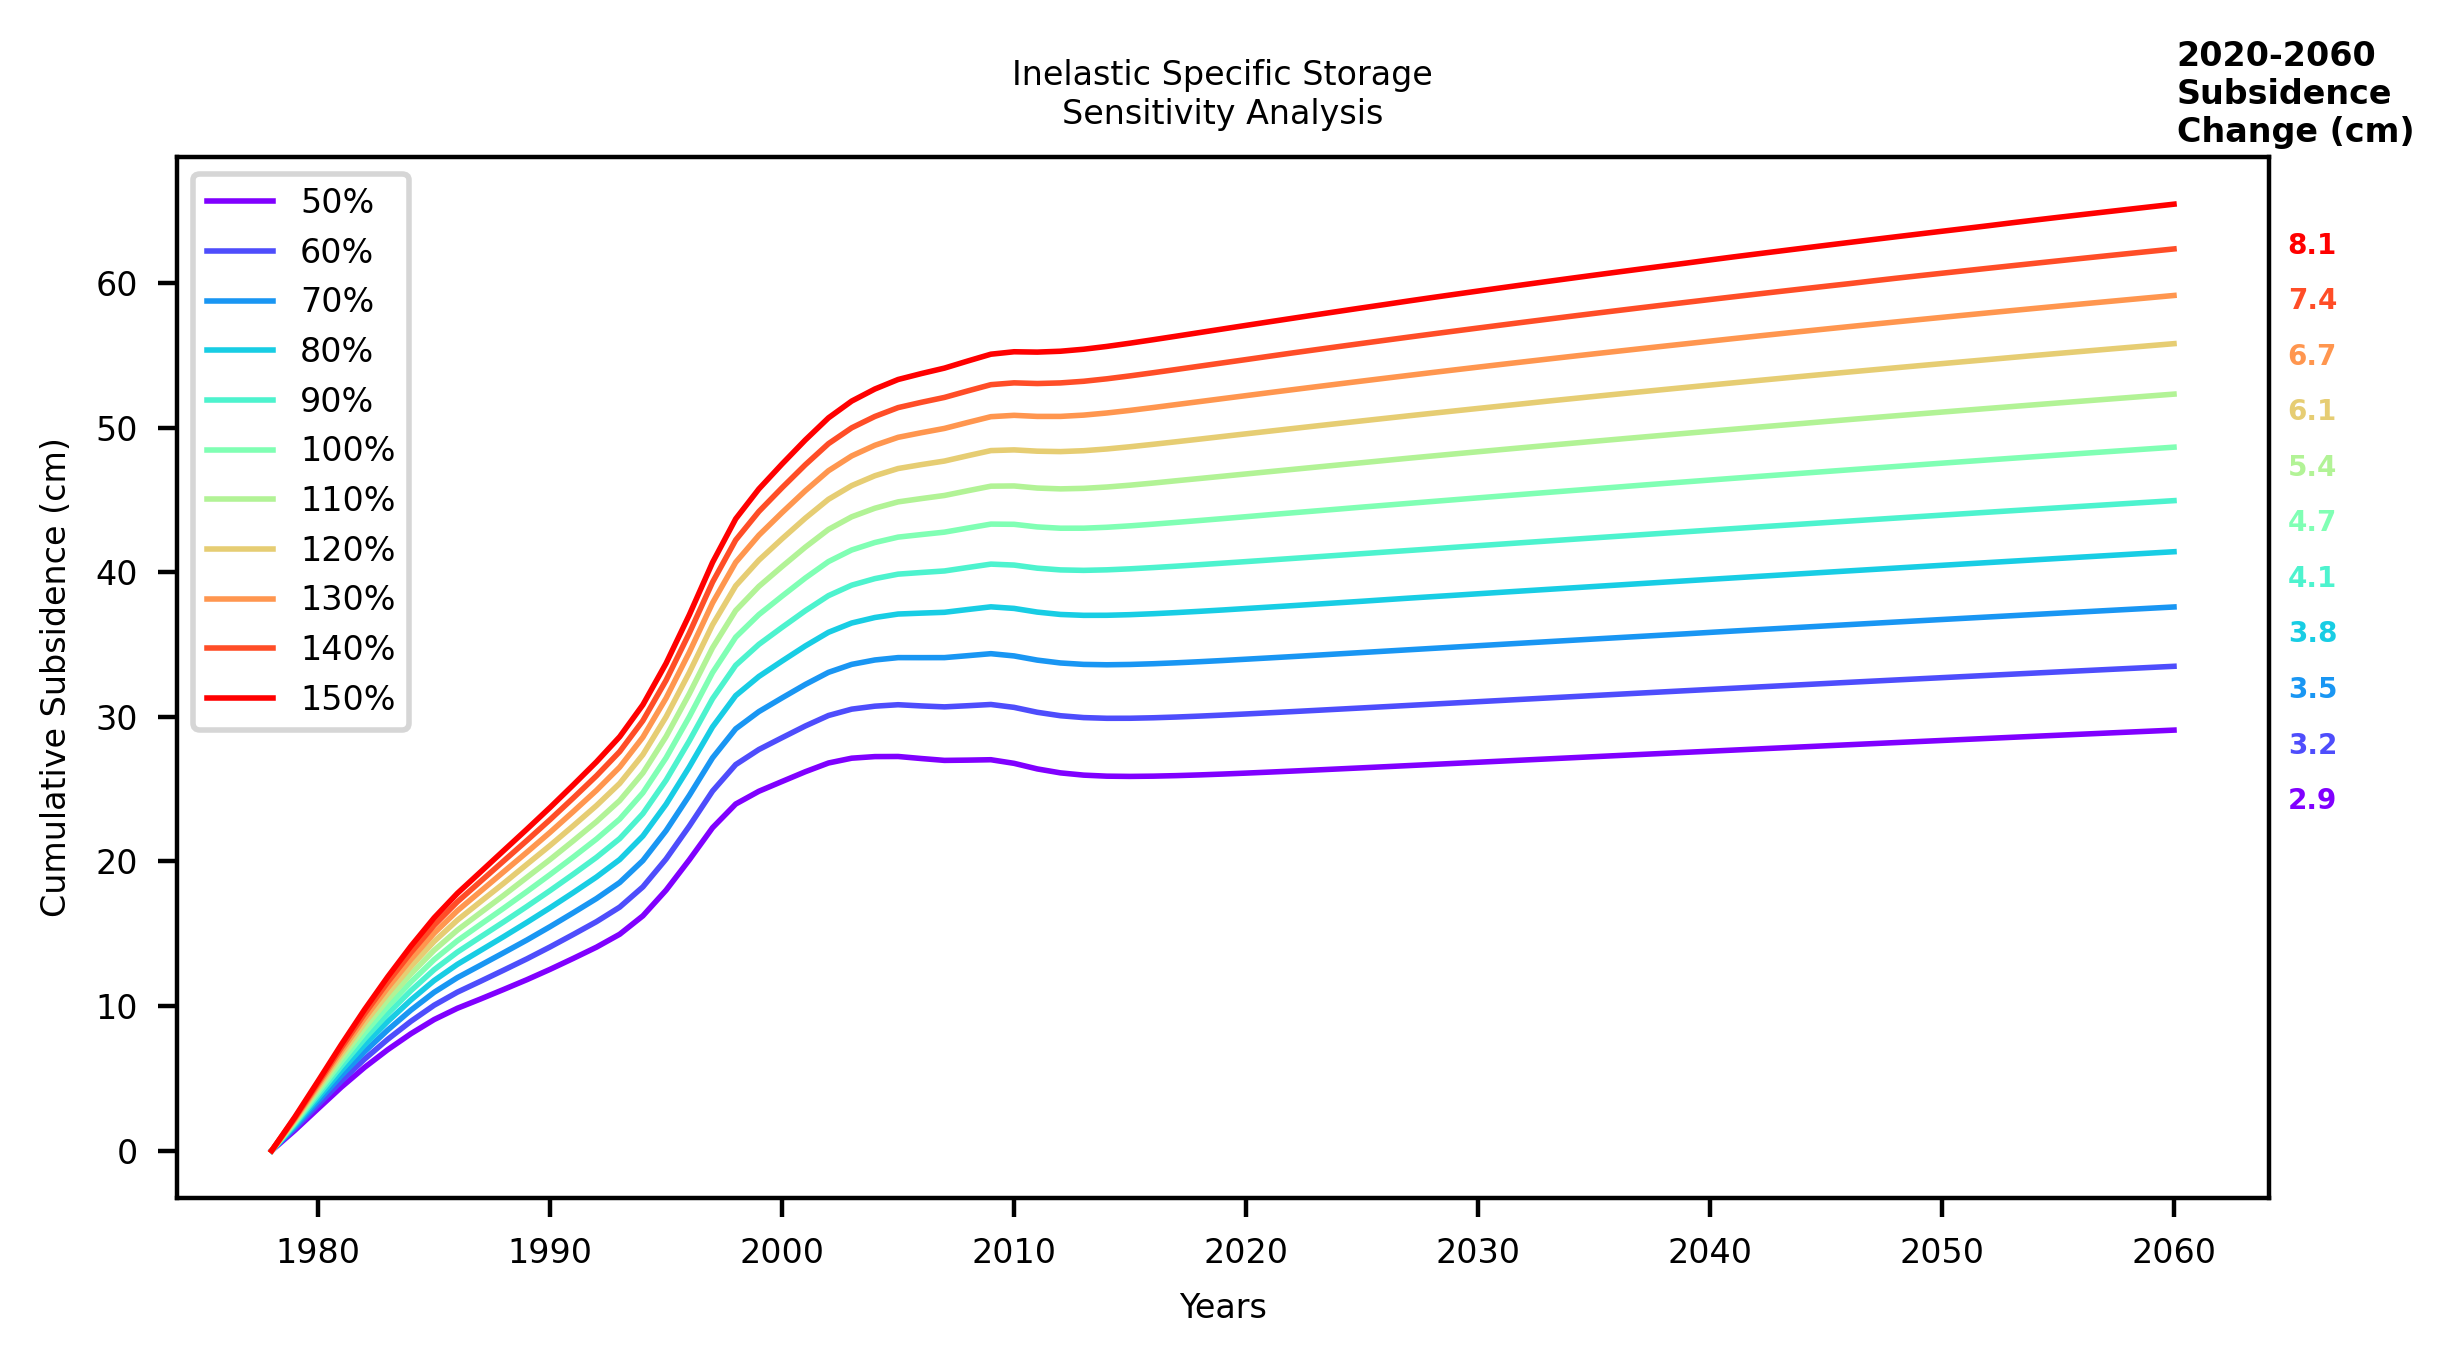

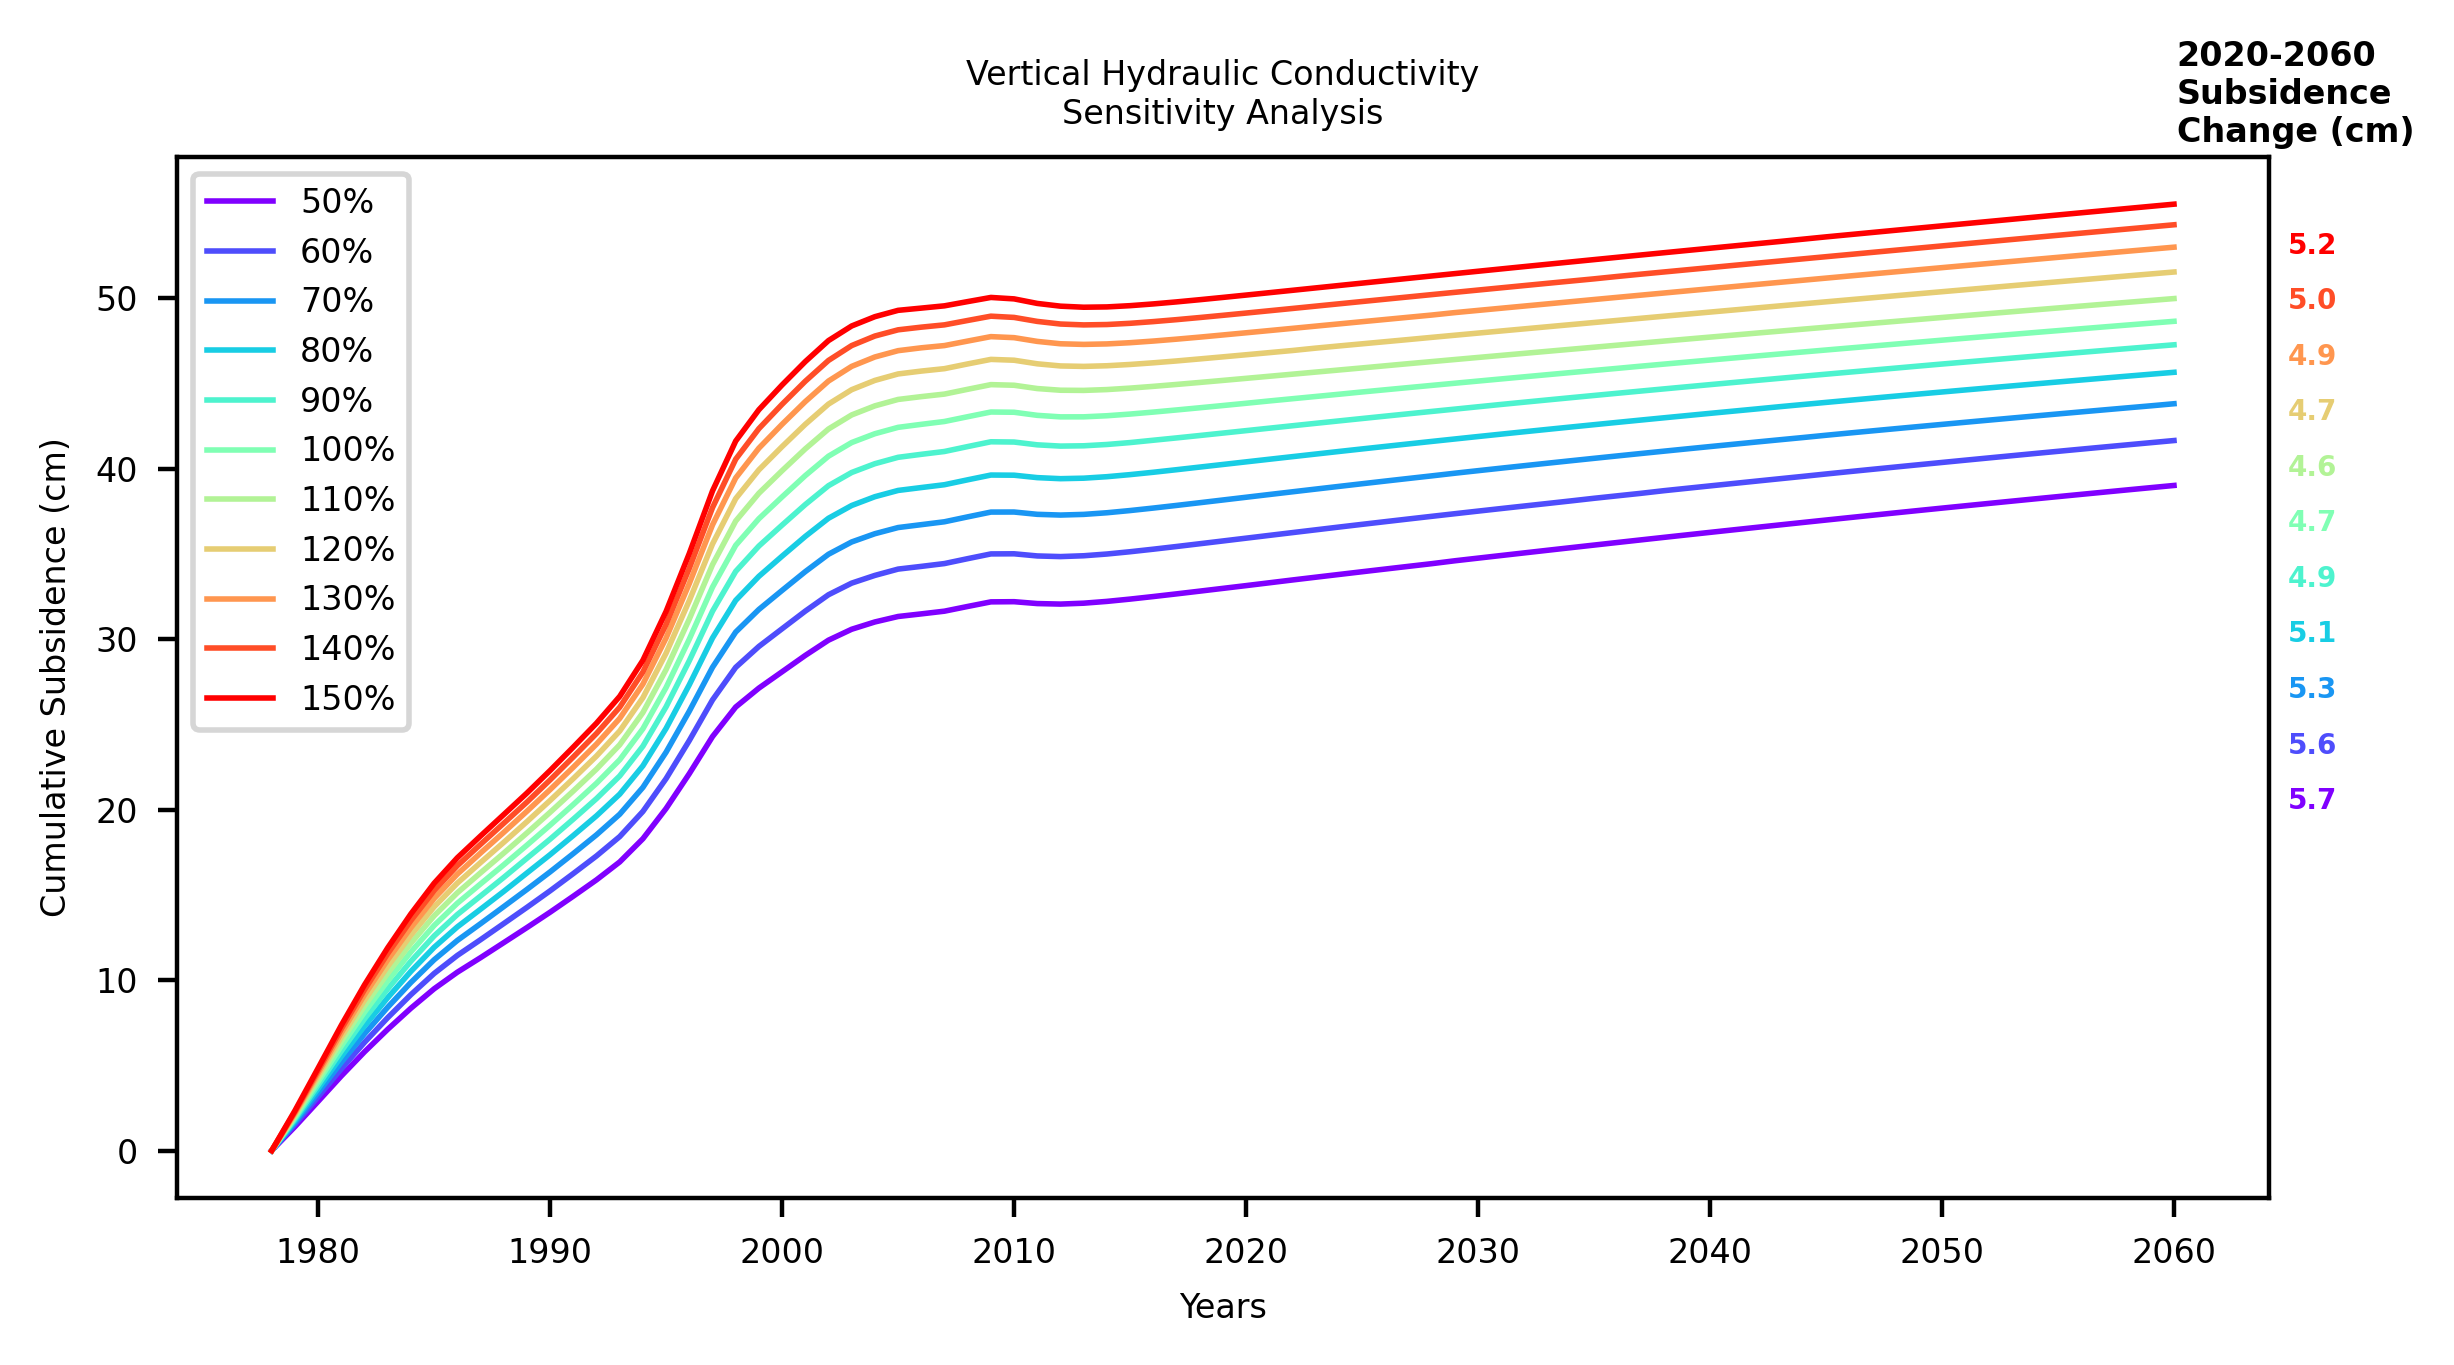

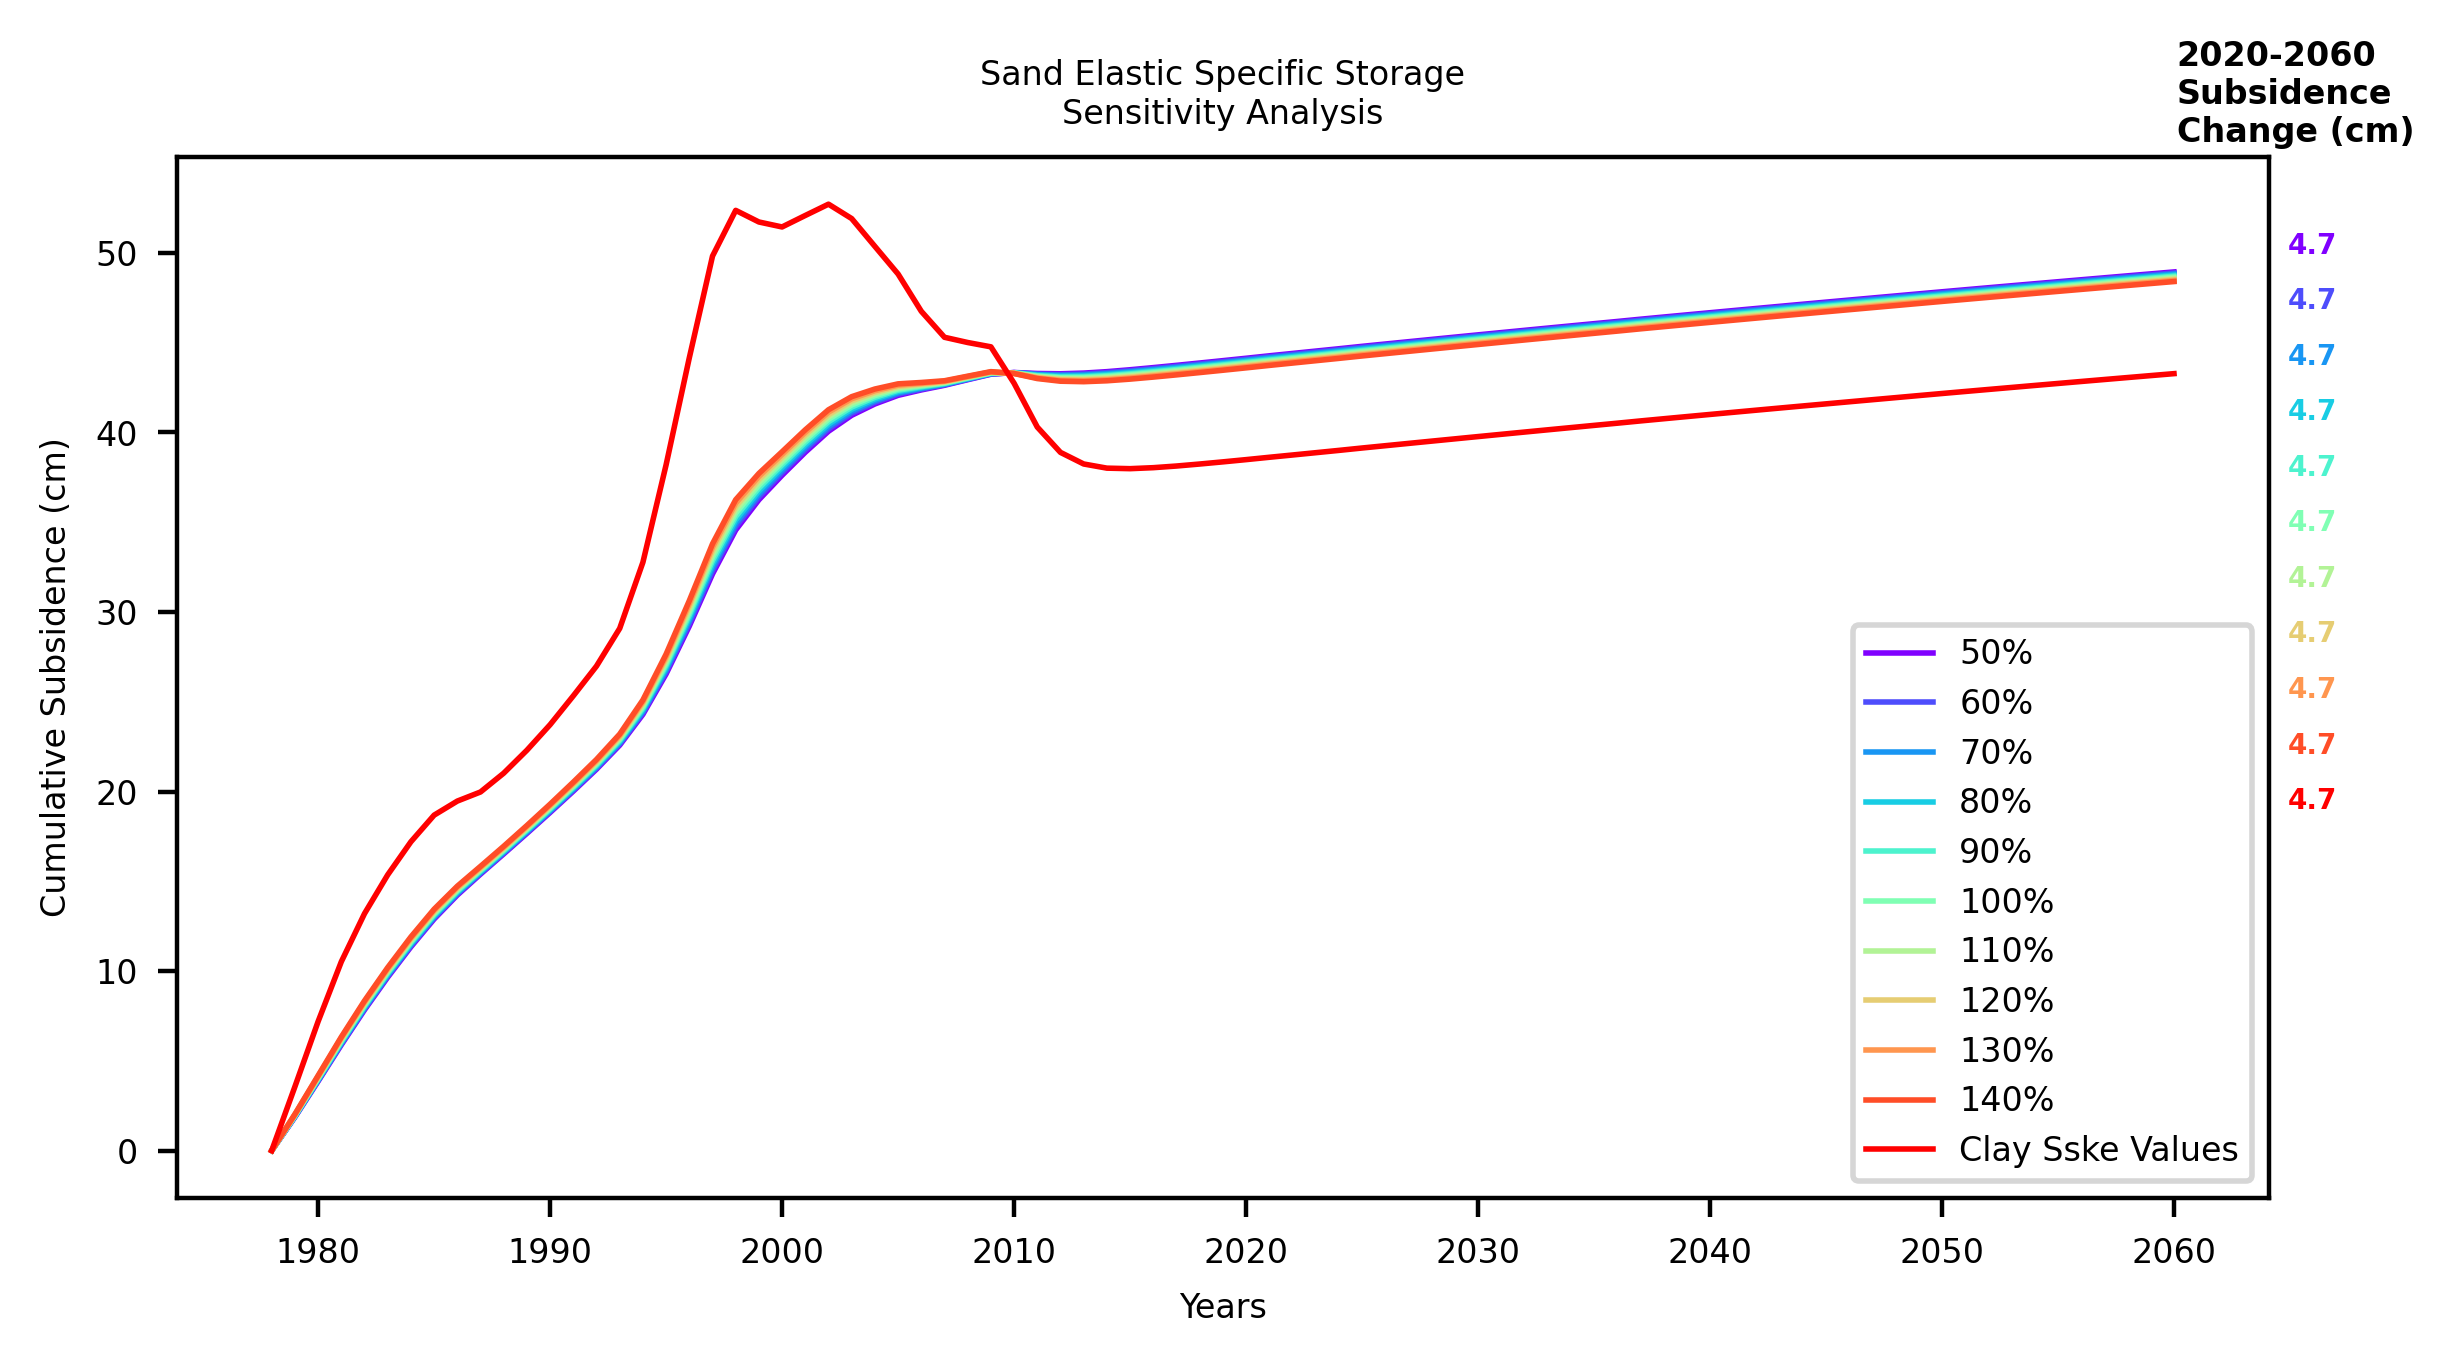

In [9]:
# Creating (0) or importing (1)
importing = 1

# If saving odels
saving = 0

# Sensitivity analysis
sens_modes = ["Sske_clay", "thick", "Sskv", "K", "Sske_sand"]

# Recommended looking at results from sensitivity analysis for only
# one well nest
# Well nest to run sensitivity analysis
wellnest_sens = ["LCBKK013"]

# For each sensitivity parameter set
for sens_mode in sens_modes:

    # Increasing by 10%
    coeff = .5
    num = 11  # Num of increases in percentage

    # Preallocation
    # All results from every sensitivity
    sens_results = []
    sens_sub = []
    sens_subv = []
    sens_ann = []

    # If creating results for first time
    if importing == 0:

        tmin = "1978"
        tmax = "2060"

        mode = "Pastas"

        # If mode is Pastas, need model path
        if mode == "Pastas":

            mpath = os.path.abspath("models")

        # Pumping flag, for PASTAS, if changing pumping scenario
        pumpflag = 1
        # If changing pumping scenario, need pumping sheet/path
        if pumpflag == 1:

            ppath = os.path.join(os.path.abspath("inputs"), "BasinPumping.xlsx")
            psheet = "EstTotalPump_54-60_Int50"

        # Convergence criteria
        CC = 1 * 10**-5

        # Number of nodes in clay
        node_num = 10

        # Using available heads as proxy for missing
        proxyflag = 1

        # For each parameter increase
        for i in range(num):

            # Reading in thickness and storage data
            path = os.path.join(os.path.abspath("inputs"), "SUBParameters.xlsx")
            Thick_data = pd.read_excel(path, sheet_name="Thickness",
                                       index_col=0)  # Thickness
            Sskv_data = pd.read_excel(path,
                                      sheet_name="Sskv",
                                      index_col=0)  # Sskv
            Sske_data = pd.read_excel(path,
                                      sheet_name="Sske",
                                      index_col=0)  # Ssk
            K_data = pd.read_excel(path,
                                   sheet_name="K",
                                   index_col=0)  # K

            # Sensitivity analyses depending on parameter
            # Inelastic specific storage
            if sens_mode == "Sskv":

                Sskv_data = Sskv_data.iloc[:, :9] * coeff

            # Elastic specific storage for clay
            elif sens_mode == "Sske_clay":

                Sske_data.iloc[:, 0:9:2] = Sske_data.iloc[:, 0:9:2] * coeff

            # Elastic specific storage for sand
            elif sens_mode == "Sske_sand":

                # If not the last sens
                if i != (num - 1):

                    Sske_data.iloc[:, 1:10:2] = Sske_data.iloc[:, 1:10:2] * coeff

                # If last sens, setting sand elastic storage to clay
                # which is typically one order of magnitude higher
                else:

                    Sske_data.iloc[:, 1:10:2] = Sske_data.iloc[:, 0:9:2]

            # Vertical hydraulic conductivity
            elif sens_mode == "K":

                K_data = K_data.iloc[:, :9] * coeff

            # Thickness
            elif sens_mode == "thick":

                Thick_data = Thick_data.iloc[:, :9] * coeff

            # Running subsidence model for every analysis value
            all_, sub_, subv_ = bkk_sub_gw.\
                bkk_sub.bkk_subsidence(wellnest_sens,
                                       mode, tmin,
                                       tmax,
                                       Thick_data,
                                       K_data,
                                       Sskv_data,
                                       Sske_data,
                                       CC=CC,
                                       Nz=node_num,
                                       ic_run=True,
                                       proxyflag=proxyflag,
                                       pumpflag=pumpflag,
                                       pump_path=ppath,
                                       pump_sheet=psheet,
                                       model_path=mpath)

            sub_, subv_, ann_, _ = bkk_sub_gw.bkk_sub.bkk_postproc(wellnest_sens,
                                                                   sub_,
                                                                   subv_,
                                                                   all_)

            # Saving results
            sens_results.append(all_)
            sens_sub.append(sub_)
            sens_subv.append(subv_)
            sens_ann.append(ann_)

            # Dictionary to store everything
            model_sub = {"wellnestlist": wellnest_sens,
                         "all_results": all_,
                         "sub_total": sub_,
                         "subv_total": subv_,
                         "ann_sub": ann_,
                         "sens_mode": sens_mode,
                         "tmin": tmin,
                         "tmax": tmax,
                         "Thick_data": Thick_data,
                         "Sske_data": Sske_data,
                         "Sskv_data": Sskv_data,
                         "K_data": K_data,
                         "pumping_scenario": psheet,
                         "CC": CC,
                         "clay_nodes": node_num,
                         "proxyflag": proxyflag}

            # If saving
            if saving == 1:

                # Path to save models
                path = os.path.abspath("models")

                # Saving dict for this model
                afile = open(path + "\\LCBKK013_sub_sens_" + str(round(coeff*100)) +
                             sens_mode + ".pkl", "wb")
                pickle.dump(model_sub, afile)
                afile.close()

            # Shifting parameter value
            coeff += .1

    # If importing model results
    else:

        # For each parameter increase
        for i in range(num):

            # Path to save models
            path = os.path.abspath("models")

            # Saving dict for this model
            afile = open(path + "\\LCBKK013_sub_sens_" + str(round(coeff*100)) +
                         sens_mode + ".pkl", "rb")
            model_sub = pickle.load(afile)
            afile.close()

            # Saving results
            sens_results.append(model_sub["all_results"])
            sens_sub.append(model_sub["sub_total"])
            sens_subv.append(model_sub["subv_total"])
            sens_ann.append(model_sub["ann_sub"])

            # Shifting parameter value
            coeff += .1

    # Plotting
    # path to save figures
    path = os.path.abspath("figures")

    # Plots results
    # New tmin for subsidence change
    tmin = "2020"
    tmax = "2060"
    bkk_sub_gw.bkk_plotting.sub_sens_line(path, wellnest_sens, sens_results,
                                          sens_sub, sens_subv, sens_ann,
                                          tmin=tmin, tmax=tmax, mode=sens_mode,
                                          num=num, save=0)

Finding outliers in subsidence observations

In [10]:
def find_outliers_IQR(df):
    """
    finds outliers

    Parameters
    ----------
    df : dataframe
        dataframe of data.

    Returns
    -------
    outliers : dataframe
        outliers.

    """
    q1 = df.quantile(0.25)

    q3 = df.quantile(0.75)

    IQR = q3-q1

    outliers = df[((df < (q1-1.5*IQR)) | (df > (q3+1.5*IQR)))]

    return outliers


# For each well nest
wellnestlist = ["LCBKK003",
                "LCBKK005",
                "LCBKK006",
                "LCBKK007",
                "LCBKK009",
                "LCBKK011",
                "LCBKK012",
                "LCBKK013",
                "LCBKK014",
                "LCBKK015",
                "LCBKK016",
                "LCBKK018",
                "LCBKK020",
                "LCBKK021",
                "LCBKK026",
                "LCBKK027",
                "LCBKK036",
                "LCBKK038",
                "LCBKK041",
                "LCNBI003",
                "LCNBI007",
                "LCSPK007",
                "LCSPK009"]

# For each well nest, finds outliers
IQRnum = 0
hampelnum = 0
for wellnest in wellnestlist:
    # BENCHMARK LEVELING
    # Subsidence plotting
    # Getting benchmark time series
    loc = os.path.join(os.path.abspath("inputs"),
                       "SurveyingLevels.xlsx")
    subdata = pd.read_excel(loc, sheet_name=wellnest + "_Leveling",
                            index_col=3)

    # SYNTHETIC DATA
    # loc = os.path.join(os.path.abspath("inputs"),
    #                    "synthetictruth_partial.xlsx")
    # subdata = pd.read_excel(loc, index_col=0)
    subdata = pd.DataFrame(subdata)
    subdata.index = pd.to_datetime(subdata.index)
    # Getting rid of benchmarks outside time period
    subdata = subdata[(subdata.Year <= 2020)]

    # Benchmarks should start at 0 at the first year.
    bench = subdata.loc[:, subdata.columns.str.contains("Land")]
    if (bench.iloc[0] != 0).any():
        bench.iloc[0] = 0

    # IMPORTANT INFO
    # For benchmark measurements, the first year is 0, the second year
    # is the compaction rate over that first year.
    # For implicit Calc, the first year has a compaction rate over that
    # year, so to shift benchmarks value to the previouse year to match
    # Index has the right years
    bench.index = bench.index.shift(-1, freq="D")
    bench["date"] = bench.index

    # Gets the last date of each year
    lastdate = bench.groupby(pd.DatetimeIndex(bench["date"]).year,
                             as_index=False).agg(
                                 {"date": max}).reset_index(drop=True)
    bench = bench.loc[lastdate.date]

    # Dataframe prep
    daterange = pd.date_range(dt.datetime(1978, 12, 31), periods=43,
                              freq="Y").tolist()
    df = pd.DataFrame(daterange, columns=["date"])

    # annual data in cm
    plot_data = df.merge(bench, left_on=df.date,
                         right_on=bench.index,
                         how="left")

    # plot_data = plot_data.drop(columns=["date_x", "date_y"])
    # Renaming for second merge
    plot_data = plot_data.rename(columns={"key_0": "key0"})

    plot_data = plot_data.dropna(axis=0)

    # OBSERVATION
    dobs = plot_data[plot_data.columns[
                     plot_data.columns.str.contains("Land")].item()]
    dobs = dobs[dobs != 0]
    dobs.index = plot_data.key0[dobs.index]

    # FINDS OUTLIERS
    IQRoutliers = find_outliers_IQR(-dobs)
    hampeloutliers = hampel(-dobs, window_size=3, n_sigma=3.5).outlier_indices

    print(wellnest)
    print("\n IQR Method")
    print("\nnumber of outliers: " + str(len(IQRoutliers)))

    if len(IQRoutliers) > 0:

        IQRnum += 1

    if len(hampeloutliers) > 0:

        hampelnum += 1

    print("\nmax outlier value: " + str(IQRoutliers.max()))

    print("\nmin outlier value: " + str(IQRoutliers.min()))

    print("\n Hampel Method")
    print("\nnumber of outliers: " + str(len(hampeloutliers)))

    print("\nmax outlier value: " + str(-dobs[hampeloutliers].max()))

    print("\nmin outlier value: " + str(-dobs[hampeloutliers].min()))

print("IQR number of well nests: " + str(IQRnum))
print("Hampel number of well nests: " + str(hampelnum))

LCBKK003

 IQR Method

number of outliers: 0

max outlier value: nan

min outlier value: nan

 Hampel Method

number of outliers: 0

max outlier value: nan

min outlier value: nan
LCBKK005

 IQR Method

number of outliers: 1

max outlier value: 13.73599999999999

min outlier value: 13.73599999999999

 Hampel Method

number of outliers: 4

max outlier value: 1.2249999999999943

min outlier value: 2.9200000000000017
LCBKK006

 IQR Method

number of outliers: 0

max outlier value: nan

min outlier value: nan

 Hampel Method

number of outliers: 1

max outlier value: 0.8100000000000023

min outlier value: 0.8100000000000023
LCBKK007

 IQR Method

number of outliers: 1

max outlier value: 2.3123000000000005

min outlier value: 2.3123000000000005

 Hampel Method

number of outliers: 0

max outlier value: nan

min outlier value: nan
LCBKK009

 IQR Method

number of outliers: 0

max outlier value: nan

min outlier value: nan

 Hampel Method

number of outliers: 0

max outlier value: nan

min o